In [63]:
import json
import pandas as pd
import requests
import time
import threading


## Definindo funções:


#### Distância usando Distância Euclidiana:
É criada uma nova coluna referente à distância até o próximo ponto, para o caso de ser o último ponto, marca a distância para o primeiro ponto.


In [64]:

def distancia(setor):
    setor['dist_per'] = ((setor['x']- setor['x'].shift(-1))**2 +
                            (setor['y']- setor['y'].shift(-1))**2 +
                            (setor['z']- setor['z'].shift(-1))**2)**(1/2)
    x= setor.columns.get_loc('x')
    y= setor.columns.get_loc('y')
    z =setor.columns.get_loc('z')

    setor.iat[len(setor)-1,setor.columns.get_loc('dist_per')] = ((setor.iat[0,x]- setor.iat[len(setor)-1,x])**2 
                                                 + (setor.iat[0,y]- setor.iat[len(setor) -1,y])**2
                                                 + (setor.iat[0,z]- setor.iat[len(setor)-1,y])**2)**(1/2)


####  Calculando a velocidade na curva:

É obtida a velocidade na curva em km/h, utilizando a escala de conversão da distância arbitrária da API para distância real, e dividindo a distância percorrida pelo tempo que o piloto está no setor da curva.

In [65]:

def velocidade_curva(curva,escala):
    distancia(curva)
    distancia_curva = curva['dist_per'].sum()- curva.iat[len(curva)-1, curva.columns.get_loc('dist_per')]
    temp_inicio = pd.to_datetime(curva.index.min())
    temp_final = pd.to_datetime(curva.index.max())
    intervalo = (temp_final-temp_inicio).total_seconds()
    velocidade = distancia_curva/((intervalo/3600)*escala)
    return velocidade

#### Obtendo os pilotos em uma sessão:

Dada uma sessão específica, obtemos quais pilotos participaram dessa sessão.

In [66]:
def pilotos_na_sessao(sessao):
    retorno1 =requests.get(f"https://api.openf1.org/v1/drivers?session_key={sessao}", timeout= 20)
    while retorno1.status_code != 200:
        time.sleep(2)
        retorno1 =requests.get(f"https://api.openf1.org/v1/drivers?session_key={sessao}", timeout= 20)
    pilotos = pd.DataFrame(json.loads(retorno1.text))
    pilotos = pilotos.drop(columns=['meeting_key','session_key','broadcast_name','team_colour','first_name','last_name','headshot_url','country_code'])
    return pilotos


#### Obtendo as voltas de um piloto em uma sessão:

Dado um piloto, retorna as voltas realizadas, filtrando algumas colunas como duração de setores específicos e velocidades em determinados pontos da pista.
Se um piloto não concluiu 3 voltas (saiu dos boxes, fez uma volta rápida e retornou aos boxes, pelo menos), retorna None.

In [67]:
def voltas(piloto,sessao):
    retorno2 = requests.get(f"https://api.openf1.org/v1/laps?driver_number={piloto}&session_key={sessao}", timeout=20)
    while retorno2.status_code != 200:
        time.sleep(2)
        retorno2 = requests.get(f"https://api.openf1.org/v1/laps?driver_number={piloto}&session_key={sessao}", timeout=20)
    classificacao = pd.DataFrame(json.loads(retorno2.text))
    classificacao = classificacao.drop(columns=['meeting_key','duration_sector_1','duration_sector_2','duration_sector_3','i1_speed','i2_speed'])
    if len(classificacao)>2:
        return classificacao
    else:
        return None

#### Obtendo a volta mais rápida, e seus tempos de começo e fim:

Recebe a lista de voltas do piloto e identifica a volta mais rápida em toda a sessão, salvando também seus tempos de início e fim.
Depois, gera o dataframe das posições do piloto nessa volta, utilizando os tempos.

In [68]:
def volta_rapida(classificacao,piloto,sessao):
    linha = list(classificacao[classificacao['lap_duration'] == classificacao['lap_duration'].min()].index)
    inicio_volta = classificacao.iloc[linha[0], 3]
    final_volta = classificacao.iloc[linha[0]+1,3]
    retorno3 =  requests.get(f"https://api.openf1.org/v1/location?driver_number={piloto}&session_key={sessao}&date>={inicio_volta}&date<={final_volta}", timeout = 20)
    while retorno3.status_code != 200:
        time.sleep(2)
        retorno3 =  requests.get(f"https://api.openf1.org/v1/location?driver_number={piloto}&session_key={sessao}&date>={inicio_volta}&date<={final_volta}", timeout = 20)
    voltas_base = pd.DataFrame(json.loads(retorno3.text))
    return voltas_base,inicio_volta,final_volta


#### Coleta do endpoint contendo velocidades:

Utilizando os tempos de início e fim da volta mais rápida, gera um novo dataframe contendo a telemetria geral do carro durante a volta.

In [69]:
def telemetria(piloto,sessao,inicio_volta,final_volta):
    retorno4 =  requests.get(f"https://api.openf1.org/v1/car_data?driver_number={piloto}&session_key={sessao}&date>={inicio_volta}&date<={final_volta}", timeout = 20)
    while retorno4.status_code != 200:
        time.sleep(2)
        retorno4 =  requests.get(f"https://api.openf1.org/v1/car_data?driver_number={piloto}&session_key={sessao}&date>={inicio_volta}&date<={final_volta}", timeout = 20)
    carro = pd.DataFrame(json.loads(retorno4.text))
    carro = carro.drop(columns=['session_key','meeting_key','driver_number'])
    return carro

#### Unindo os dois endpoints:

Junta os dois dataframes, da posição e da telemetria, utilizando o tempo como base.

In [70]:
def unir_telemetria_volta_rapida(voltas_base,carro):
    voltas_base['date']= pd.to_datetime(voltas_base['date'],format ='ISO8601')
    voltas_base.set_index('date', inplace=True)
    carro['date']= pd.to_datetime(carro['date'], errors='coerce', format ='ISO8601')
    carro.set_index('date', inplace=True)

    voltas_completa = voltas_base.join(carro, how='outer', lsuffix='_base',rsuffix='_carro')
    return voltas_completa

#### Reindexação:

Altera o index para a coluna de tempo, e insere intervalos de tempo tentando simular a frequência estipulada pela API, de 3.7 Hz

In [71]:
def mudar_index(voltas_base,voltas_completa,carro):
    novo_tempo = pd.date_range(start=min(voltas_base.index.min(),carro.index.min()),end=max(voltas_base.index.max(),carro.index.max()),freq=pd.to_timedelta(1 / 3.7, unit='s'))
    novo_index = novo_tempo.union(voltas_completa.index)
    voltas_reindex = voltas_completa.reindex(novo_index)
    return voltas_reindex

#### Completando o dataframe:

Ao inserir novos pontos e unir os dataframes, há linhas com valores nulos em cada coluna. Para corrigir isso, interpolamos cada linha, utilizando o tempo como parâmetro.

In [72]:
def interpolar(voltas_reindex):
    voltas_final = voltas_reindex.interpolate(method='time')
    distancia(voltas_final)
    return voltas_final

#### Escolha das curvas:

Cria uma lista contendo as coordenadas selecionadas para filtrar cada curva, podendo ser escolhidas n curvas na sessão.

In [73]:
def curvas_escolha(sessao):
    etapa = f'Etapa de {sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'circuit_short_name']}'
    numero_curvas = int(input(f"Quantas curvas selecionar em {etapa}? "))
    curvas_etapa = []
    for i in range(numero_curvas):
        curvax_max = int(input(f"Qual a coord. X máxima da {i+1}ª curva de {etapa}?" ))
        curvax_min = int(input(f"Qual a coord. X mínima da {i+1}ª curva de {etapa}?" ))
        curvay_max = int(input(f"Qual a coord. Y máxima da {i+1}ª curva de {etapa}?" ))
        curvay_min = int(input(f"Qual a coord. Y mínima da {i+1}ª curva de {etapa}?" ))

        curva = [curvax_max,curvax_min,curvay_max,curvay_min]
        curvas_etapa.append(curva)
    return curvas_etapa


#### Filtrando os pontos nos quais a velocidade do piloto vai ser analisada:

Dadas as coordenadas de curva e o dataframe da volta mais rápida de um piloto, filtra as linhas nos quais ele percorre as curvas selecionadas, separadamente.

In [74]:
def curvas_piloto(volta_final,curvas_etapa):
    setores = []
    for i in range(len(curvas_etapa)):
        curvax = (volta_final['x']<=curvas_etapa[i][0]) & (volta_final['x']>=curvas_etapa[i][1])
        curvay = (volta_final['y']<=curvas_etapa[i][2]) & (volta_final['y']>=curvas_etapa[i][3])
        curva = volta_final[curvax & curvay].copy()      
        setores.append(curva)

    return setores


#### Usando um piloto como exemplo para selecionar as curvas:

Para uma sessão, coletamos e processamos a volta mais rápida de um piloto qualquer (nesse exemplo, o piloto 16), e construímos um gráfico com essa volta, para que possamos selecionar as áreas de cada curva do circuito.

In [75]:
def exemplo(sessao):
    classificacao_exemplo = voltas(16, sessao)
    volta_exemplo,inicio_volta,final_volta = volta_rapida(classificacao_exemplo,16,sessao)
    dados_carro = telemetria(16,sessao,inicio_volta,final_volta)
    volta_final= interpolar(mudar_index(volta_exemplo,unir_telemetria_volta_rapida(volta_exemplo,dados_carro),dados_carro))
    volta_final.plot.scatter(x='x',y='y',c='speed',xlabel = f'Etapa de {sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'circuit_short_name']}', grid = True, figsize = (20,20)                             )
    return volta_final


#### Coletando para cada piloto na sessão:

Após utilizar um piloto exemplo para obter a escala entre a distância arbitrária da API e a distância real, calcula a velocidade média em cada curva, para todo piloto na sessão.
Se um piloto não tiver completado voltas suficientes, atribui NA para suas velocidades.

Ao final, cria uma coluna para cada curva, tomando como base o dataframe de pilotos na sessão.

In [76]:

def coleta(sessao,distancia_real,curvas):
    pilotos = pilotos_na_sessao(sessao)
    classificacao_exemplo = voltas(16, sessao)
    volta_exemplo,inicio_volta,final_volta = volta_rapida(classificacao_exemplo,16,sessao)
    dados_carro = telemetria(16,sessao,inicio_volta,final_volta)
    volta_final= interpolar(mudar_index(volta_exemplo,unir_telemetria_volta_rapida(volta_exemplo,dados_carro),dados_carro))
    distancia_volta = volta_final['dist_per'].sum() 
    escala = distancia_volta/distancia_real 

    for i in range(len(curvas)):
        pilotos[f'curva {i+1}'] = pd.NA

    for piloto in pilotos['driver_number']:
    
        classificacao_exemplo = voltas(piloto, sessao)
        if classificacao_exemplo is not None:
            volta_exemplo,inicio_volta,final_volta = volta_rapida(classificacao_exemplo,piloto,sessao)
            dados_carro = telemetria(piloto,sessao,inicio_volta,final_volta)
            volta_final= interpolar(mudar_index(volta_exemplo,unir_telemetria_volta_rapida(volta_exemplo,dados_carro),dados_carro))
            for i in range(len(curvas)):
                setores = curvas_piloto(volta_final,curvas)
                indice = pilotos[pilotos['driver_number']== piloto].index[0]
                pilotos.at[indice, f'curva {i+1}']= velocidade_curva(setores[i],escala)
            print(f'Piloto {piloto},Etapa de {sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'circuit_short_name']} OK!') 
        else:
            for i in range(len(setores)):
                indice = pilotos[pilotos['driver_number']== piloto].index[0]
                pilotos.loc[indice, f'curva {i+1}']= pd.NA
                print(f'Piloto {piloto} Sem voltas!') 
    return pilotos


#### Coletando para todas as sessões e salvando:

Gera arquivos .csv para cada sessão ao repetir o processo para cada etapa.
Há qualificações que ocorrem em um mesmo circuito, dado um final de semana que inclui uma corrida mais curta focada em velocidade, e menos em estratégia de gerenciamento de pneus, chamada "Sprint". Para esses casos, é criado um .csv separado.

In [77]:
def coletar_salvar(sessao,distancias,todas_curvas,i):
    pilotos = coleta(sessao,distancias[i],todas_curvas[i])
    if sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'session_name'] == 'Sprint Qualifying':
        pilotos.to_csv(f'resultados_{sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'circuit_short_name']}_S')
    else:
        pilotos.to_csv(f'resultados_{sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'circuit_short_name']}')

## A coleta:

#### Verificando as etapas/sessões:

Obtemos todas as sessões desde 01/03/2025 a 29/08/2025, compreendendo a primeira parte da temporada de corridas do ano antes das férias de verão.

In [78]:
retorno0 = requests.get("https://api.openf1.org/v1/sessions?date_start%3E%3D2025-03-01&date_end%3C%3D2025-08-29&session_type=Qualifying", timeout= 20)
while retorno0.status_code != 200:
    time.sleep(2)
    retorno0 = requests.get("https://api.openf1.org/v1/sessions?date_start%3E%3D2025-03-01&date_end%3C%3D2025-08-29&session_type=Qualifying", timeout= 20)
    
sessoes = pd.DataFrame(json.loads(retorno0.text))
sessoes

meeting_key  session_key           location                 date_start  \
0          1254         9689          Melbourne  2025-03-15T05:00:00+00:00   
1          1255         9989           Shanghai  2025-03-21T07:30:00+00:00   
2          1255         9994           Shanghai  2025-03-22T07:00:00+00:00   
3          1256        10002             Suzuka  2025-04-05T06:00:00+00:00   
4          1257        10010             Sakhir  2025-04-12T16:00:00+00:00   
5          1258        10018             Jeddah  2025-04-19T17:00:00+00:00   
6          1259        10024              Miami  2025-05-02T20:30:00+00:00   
7          1259        10029              Miami  2025-05-03T20:00:00+00:00   
8          1260         9983              Imola  2025-05-17T14:00:00+00:00   
9          1261         9975             Monaco  2025-05-24T14:00:00+00:00   
10         1262         9967          Barcelona  2025-05-31T14:00:00+00:00   
11         1263         9959           Montréal  2025-06-14T20:00:00+00:00   
12         1264         9951          Spielberg  2025-06-28T14:00:00+00:00   
13         1277         9943        Silverstone  2025-07-05T14:00:00+00:00   
14         1265         9930  Spa-Francorchamps  2025-07-25T14:30:00+00:00   
15         1265         9935  Spa-Francorchamps  2025-07-26T14:00:00+00:00   
16         1266         9924           Budapest  2025-08-02T14:00:00+00:00   

                     date_end session_type       session_name  country_key  \
0   2025-03-15T06:00:00+00:00   Qualifying         Qualifying            5   
1   2025-03-21T08:14:00+00:00   Qualifying  Sprint Qualifying           53   
2   2025-03-22T08:00:00+00:00   Qualifying         Qualifying           53   
3   2025-04-05T07:00:00+00:00   Qualifying         Qualifying            4   
4   2025-04-12T17:00:00+00:00   Qualifying         Qualifying           36   
5   2025-04-19T18:00:00+00:00   Qualifying         Qualifying          153   
6   2025-05-02T21:14:00+00:00   Qualifying  Sprint Qualifying           19   
7   2025-05-03T21:00:00+00:00   Qualifying         Qualifying           19   
8   2025-05-17T15:00:00+00:00   Qualifying         Qualifying           13   
9   2025-05-24T15:00:00+00:00   Qualifying         Qualifying          114   
10  2025-05-31T15:00:00+00:00   Qualifying         Qualifying            1   
11  2025-06-14T21:00:00+00:00   Qualifying         Qualifying           46   
12  2025-06-28T15:00:00+00:00   Qualifying         Qualifying           17   
13  2025-07-05T15:00:00+00:00   Qualifying         Qualifying            2   
14  2025-07-25T15:14:00+00:00   Qualifying  Sprint Qualifying           16   
15  2025-07-26T15:00:00+00:00   Qualifying         Qualifying           16   
16  2025-08-02T15:00:00+00:00   Qualifying         Qualifying           14   

   country_code    country_name  circuit_key circuit_short_name gmt_offset  \
0           AUS       Australia           10          Melbourne   11:00:00   
1           CHN           China           49           Shanghai   08:00:00   
2           CHN           China           49           Shanghai   08:00:00   
3           JPN           Japan           46             Suzuka   09:00:00   
4           BRN         Bahrain           63             Sakhir   03:00:00   
5           KSA    Saudi Arabia          149             Jeddah   03:00:00   
6           USA   United States          151              Miami  -04:00:00   
7           USA   United States          151              Miami  -04:00:00   
8           ITA           Italy            6              Imola   02:00:00   
9           MON          Monaco           22        Monte Carlo   02:00:00   
10          ESP           Spain           15          Catalunya   02:00:00   
11          CAN          Canada           23           Montreal  -04:00:00   
12          AUT         Austria           19          Spielberg   02:00:00   
13          GBR  United Kingdom            2        Silverstone   01:00:00   
14          BEL         

#### Distâncias reais:

Para cada etapa listada, a distância real do circuito foi incluída na lista abaixo.

In [79]:
distancias = [5.278, 5.451, 5.451, 5.807, 5.412, 6.174, 5.412, 5.412, 4.909, 3.337, 4.657, 4.631, 4.318, 5.891, 7.004, 7.004, 4.381]


#### Preparando a seleção de curvas:

Utilizando o processo de um piloto como exemplo, criamos o gráfico de cada pista, no qual vamos nos basear para selecionar recortes de área (retângulos) que compreendam curvas.

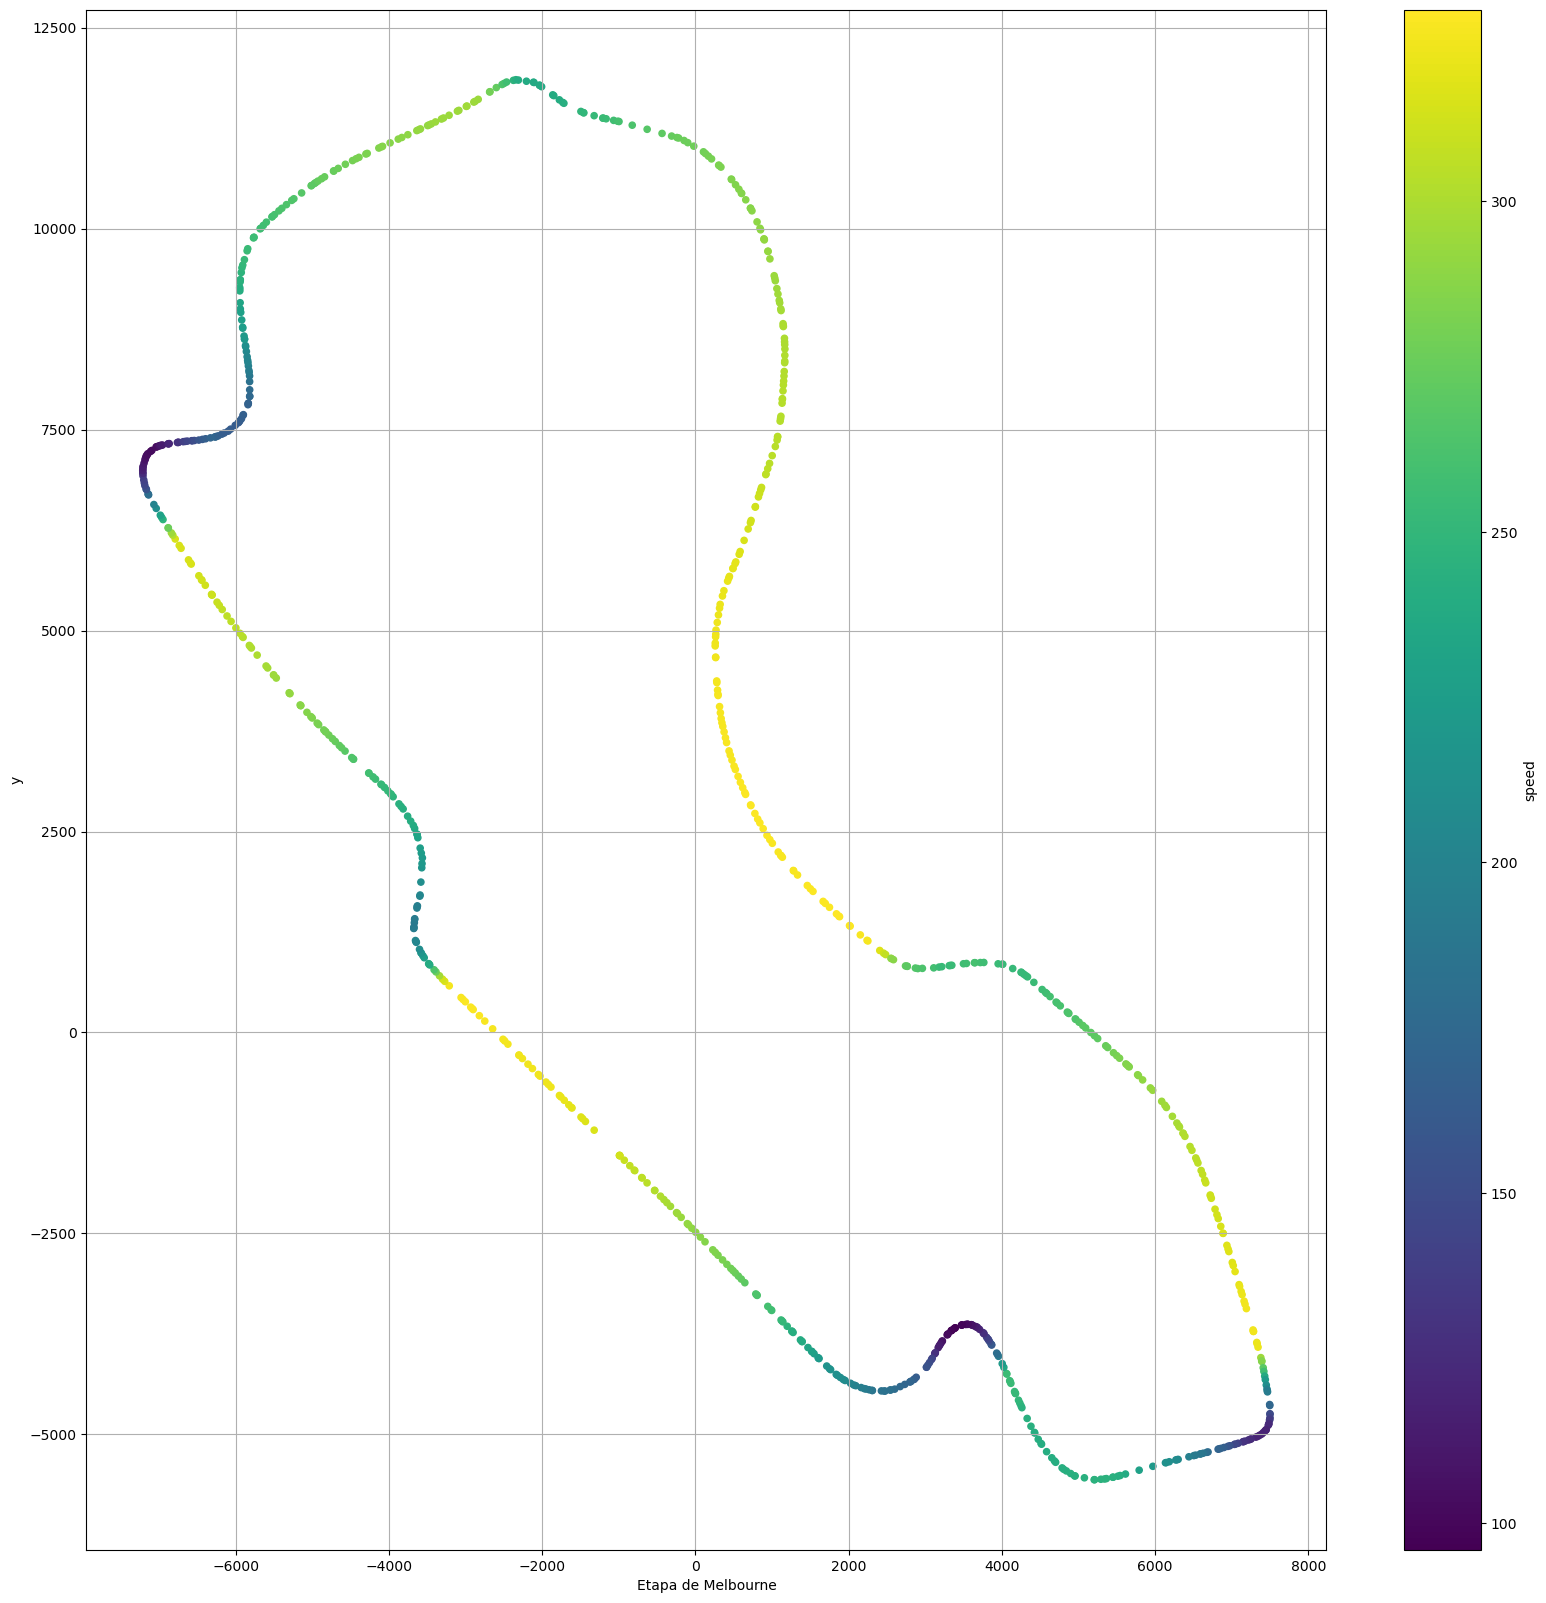

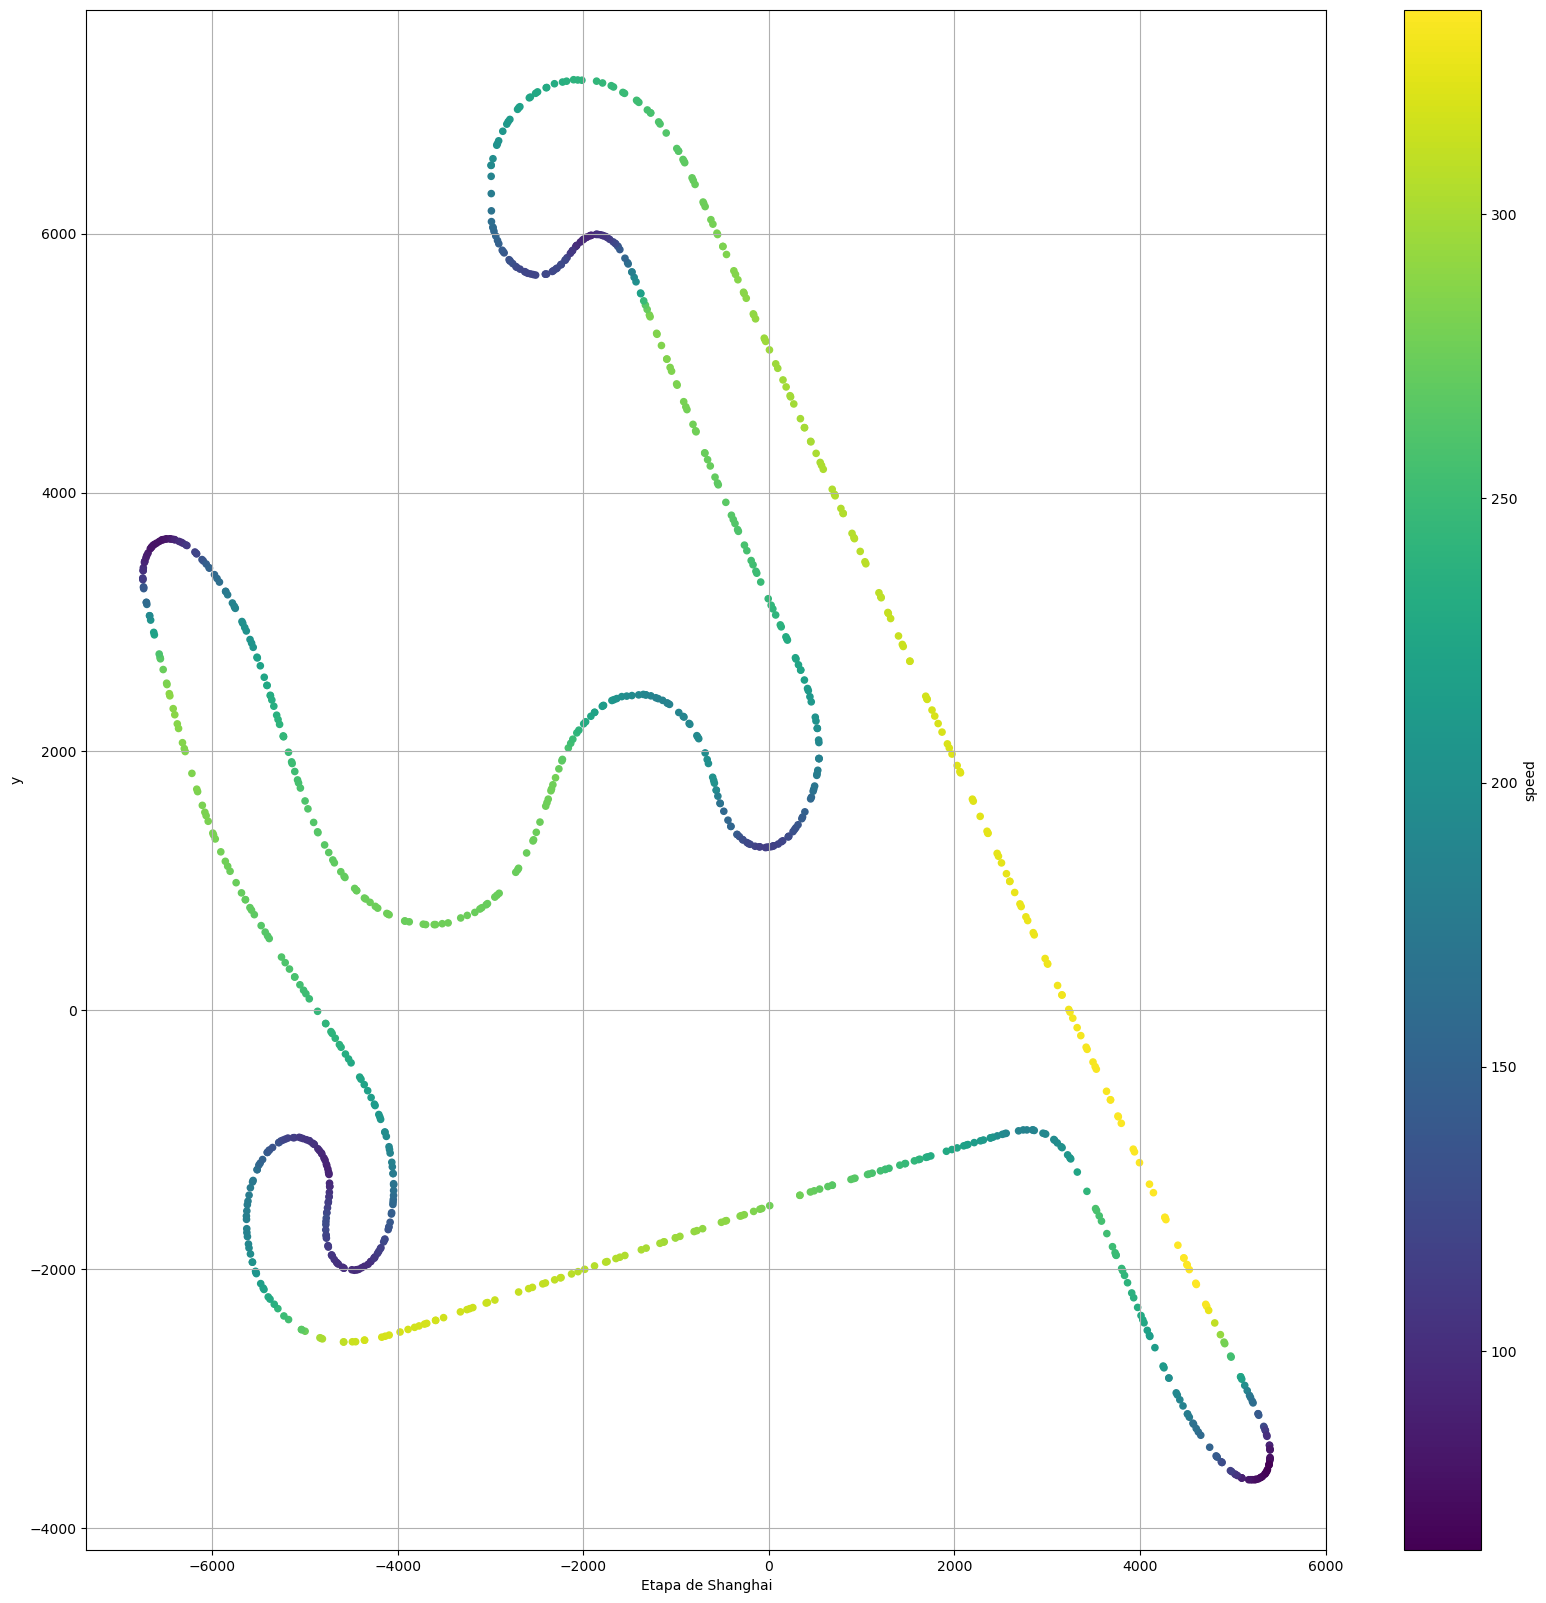

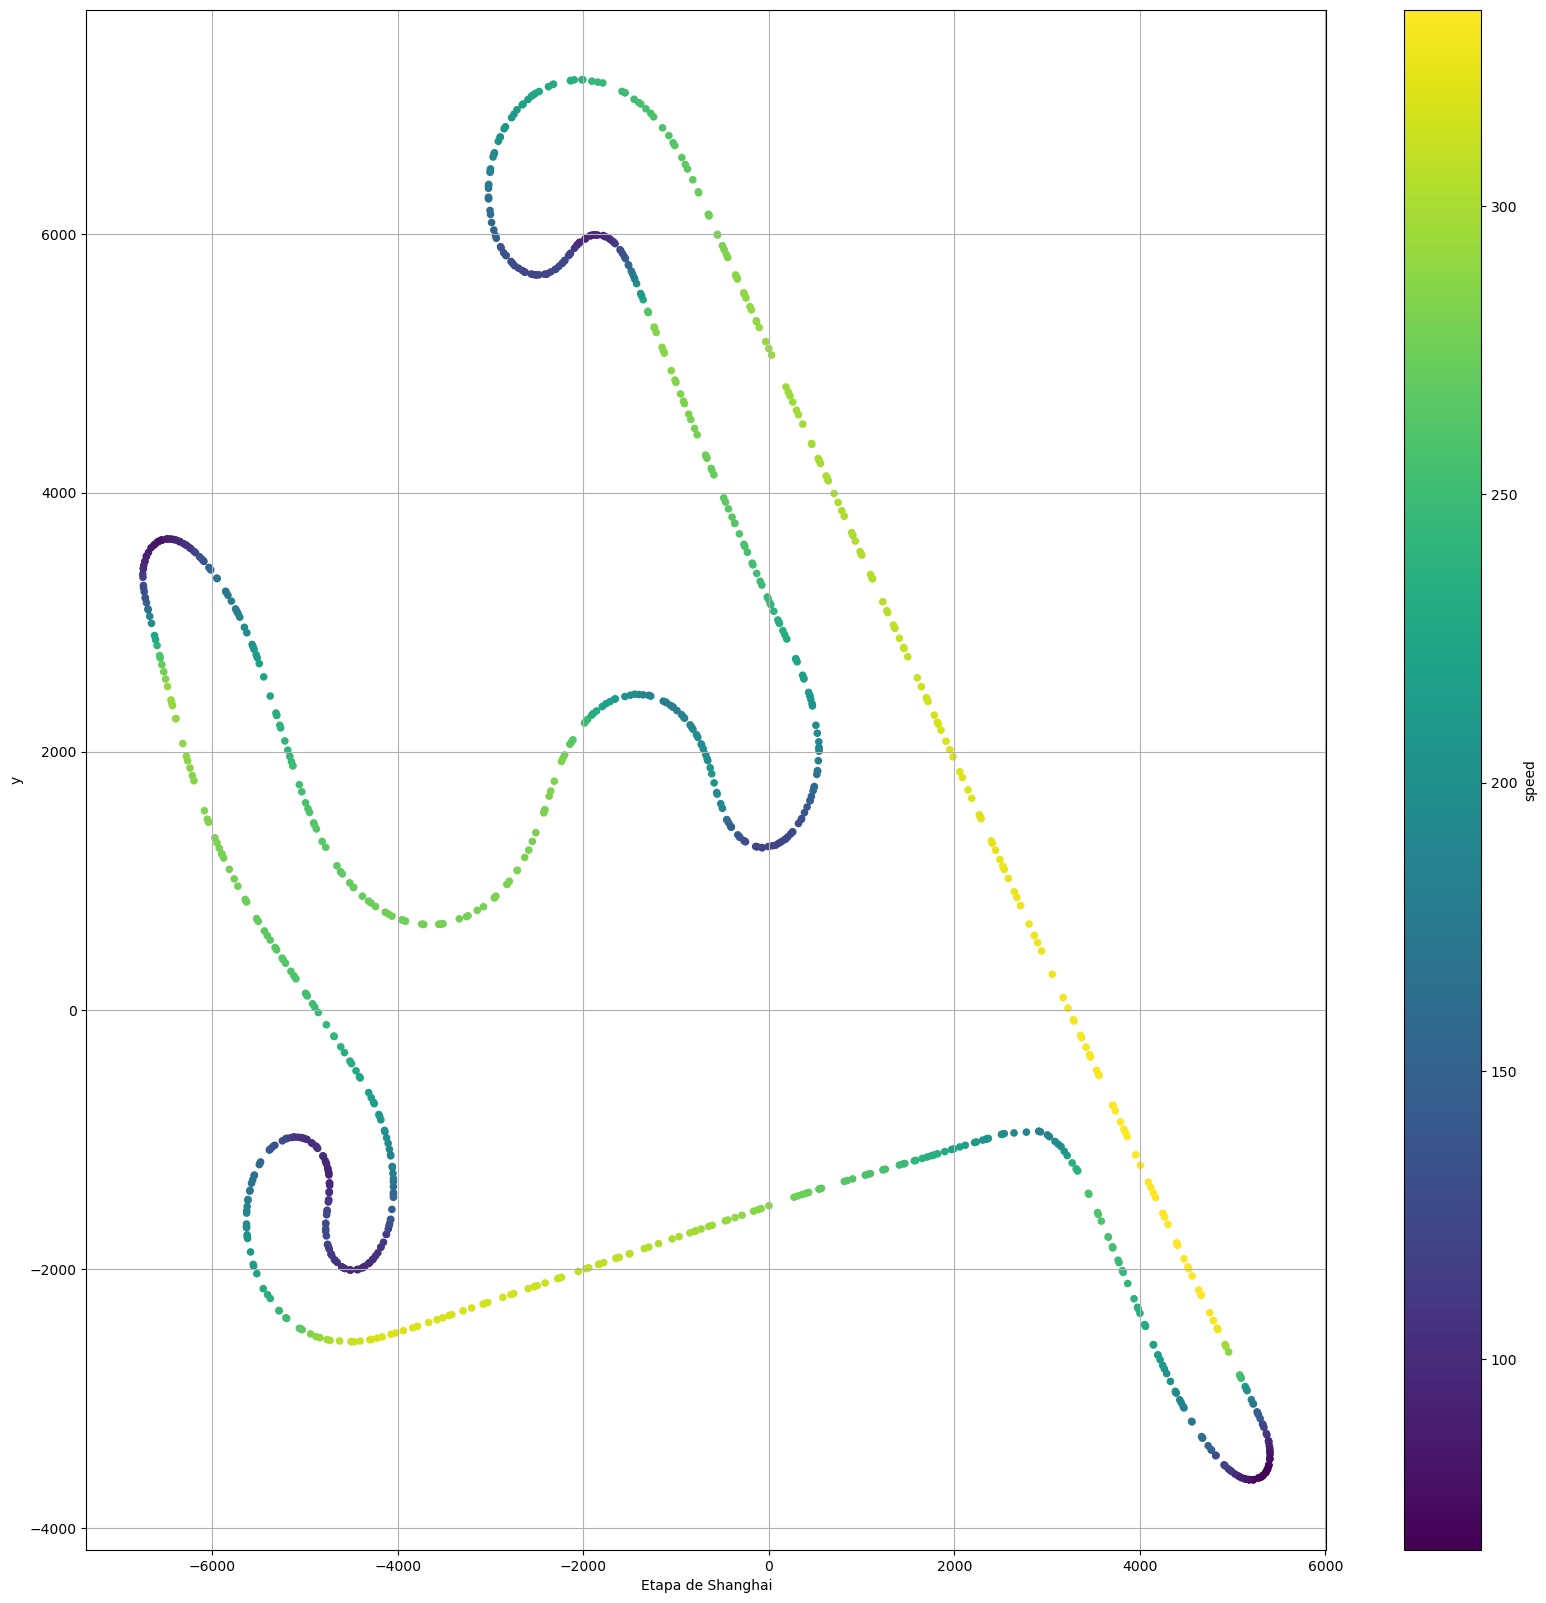

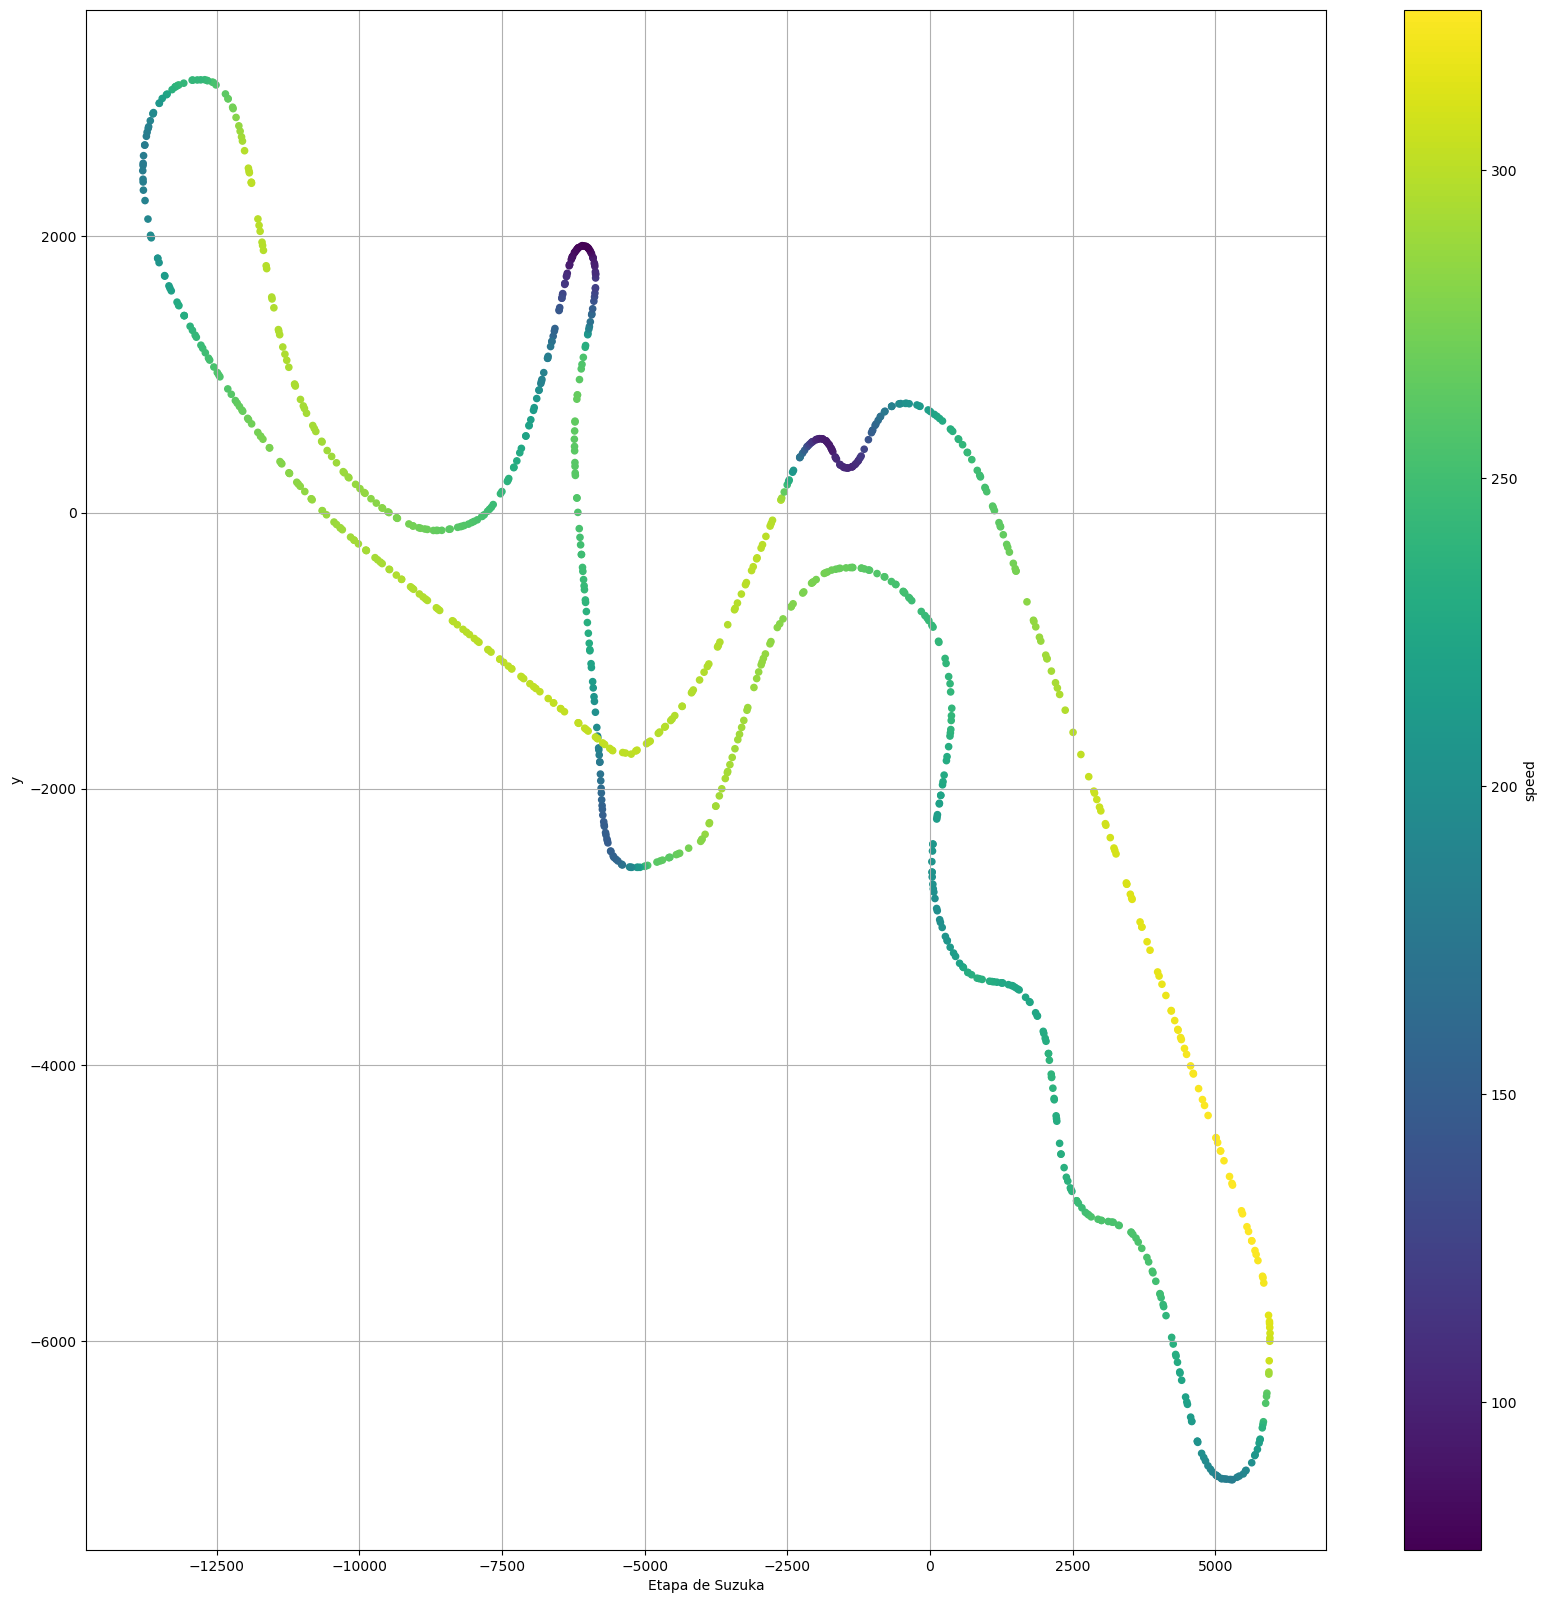

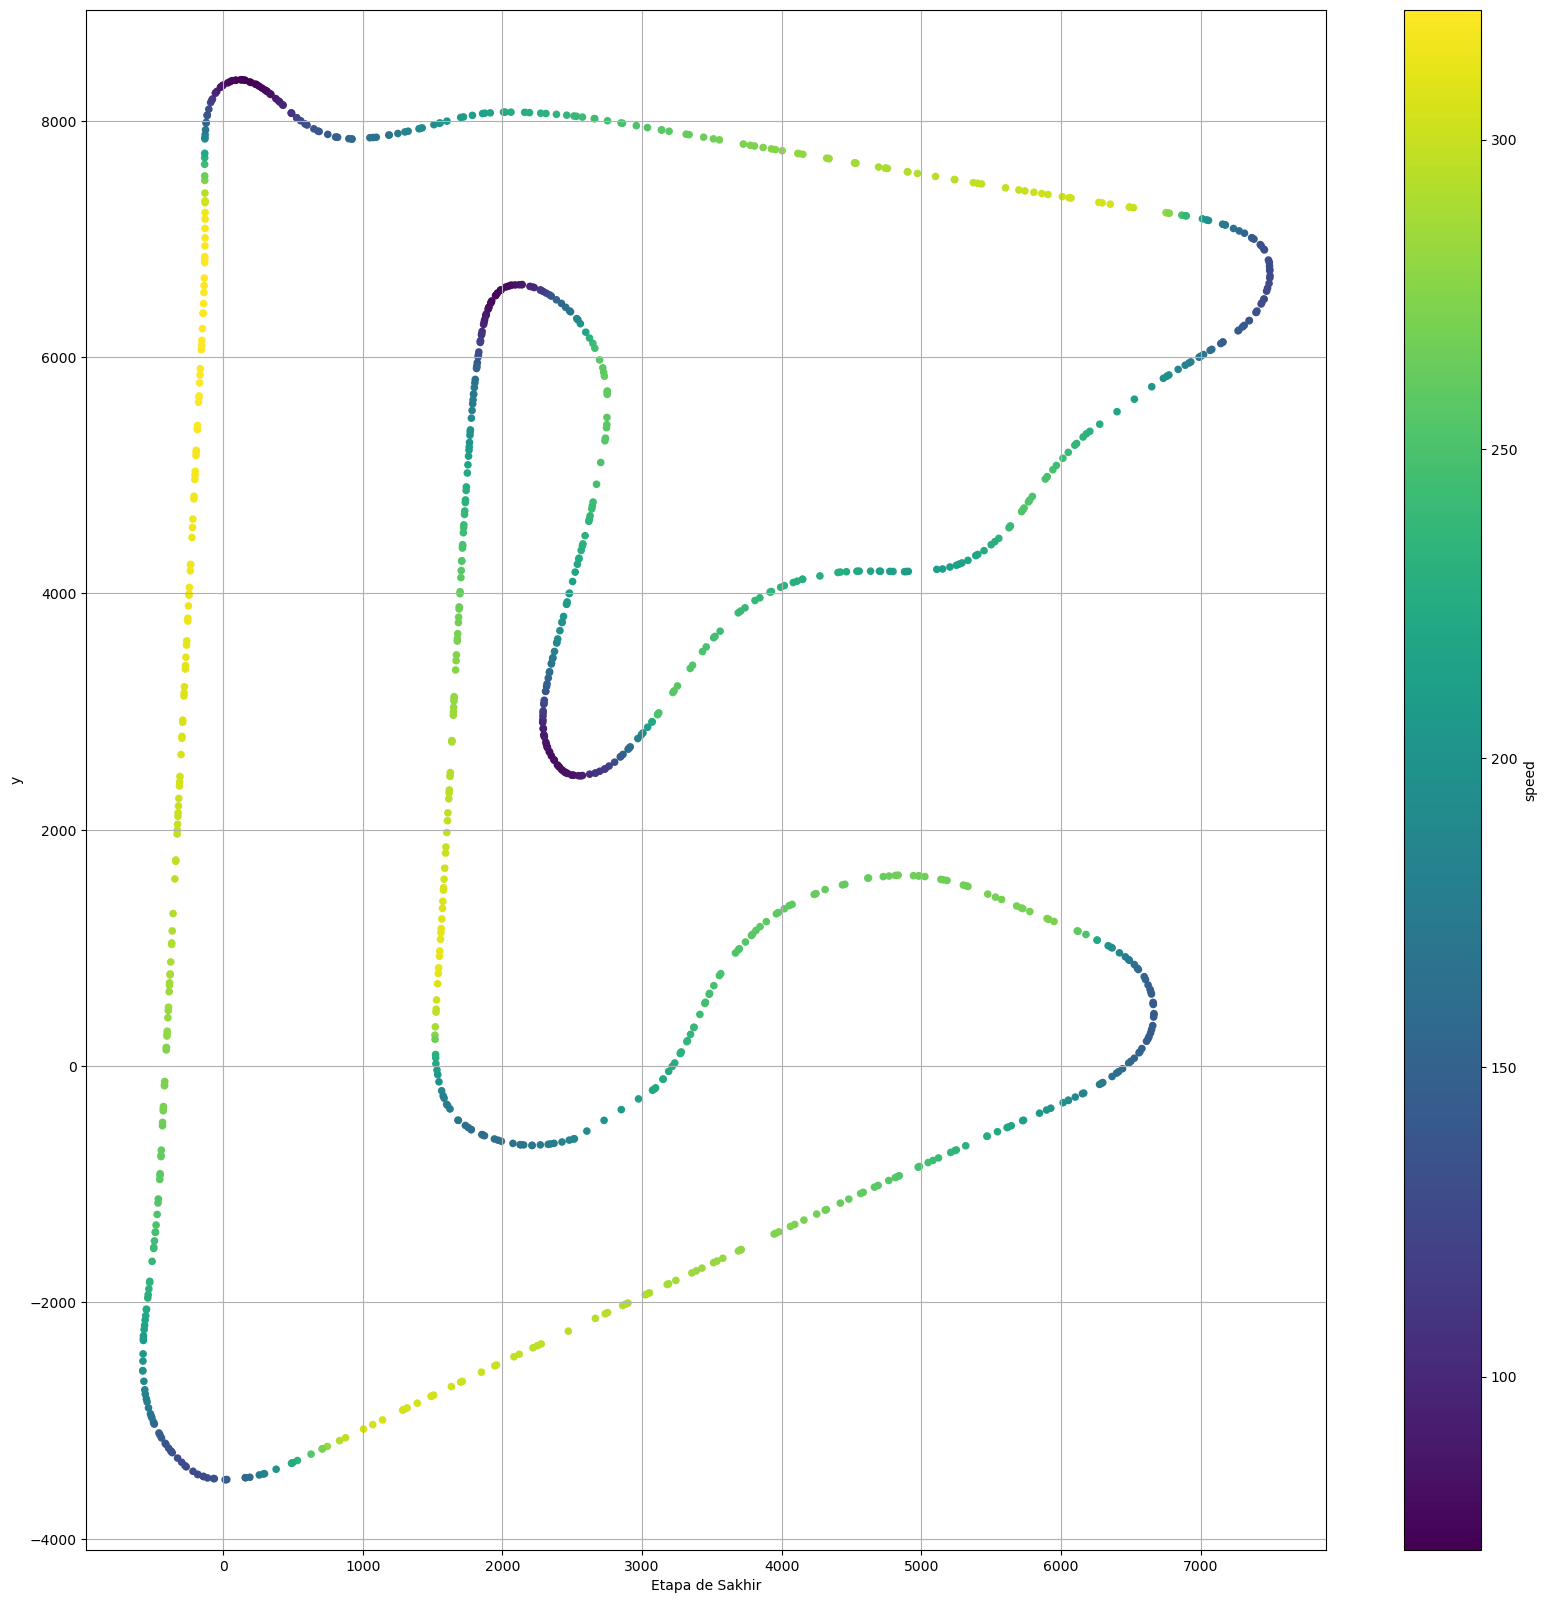

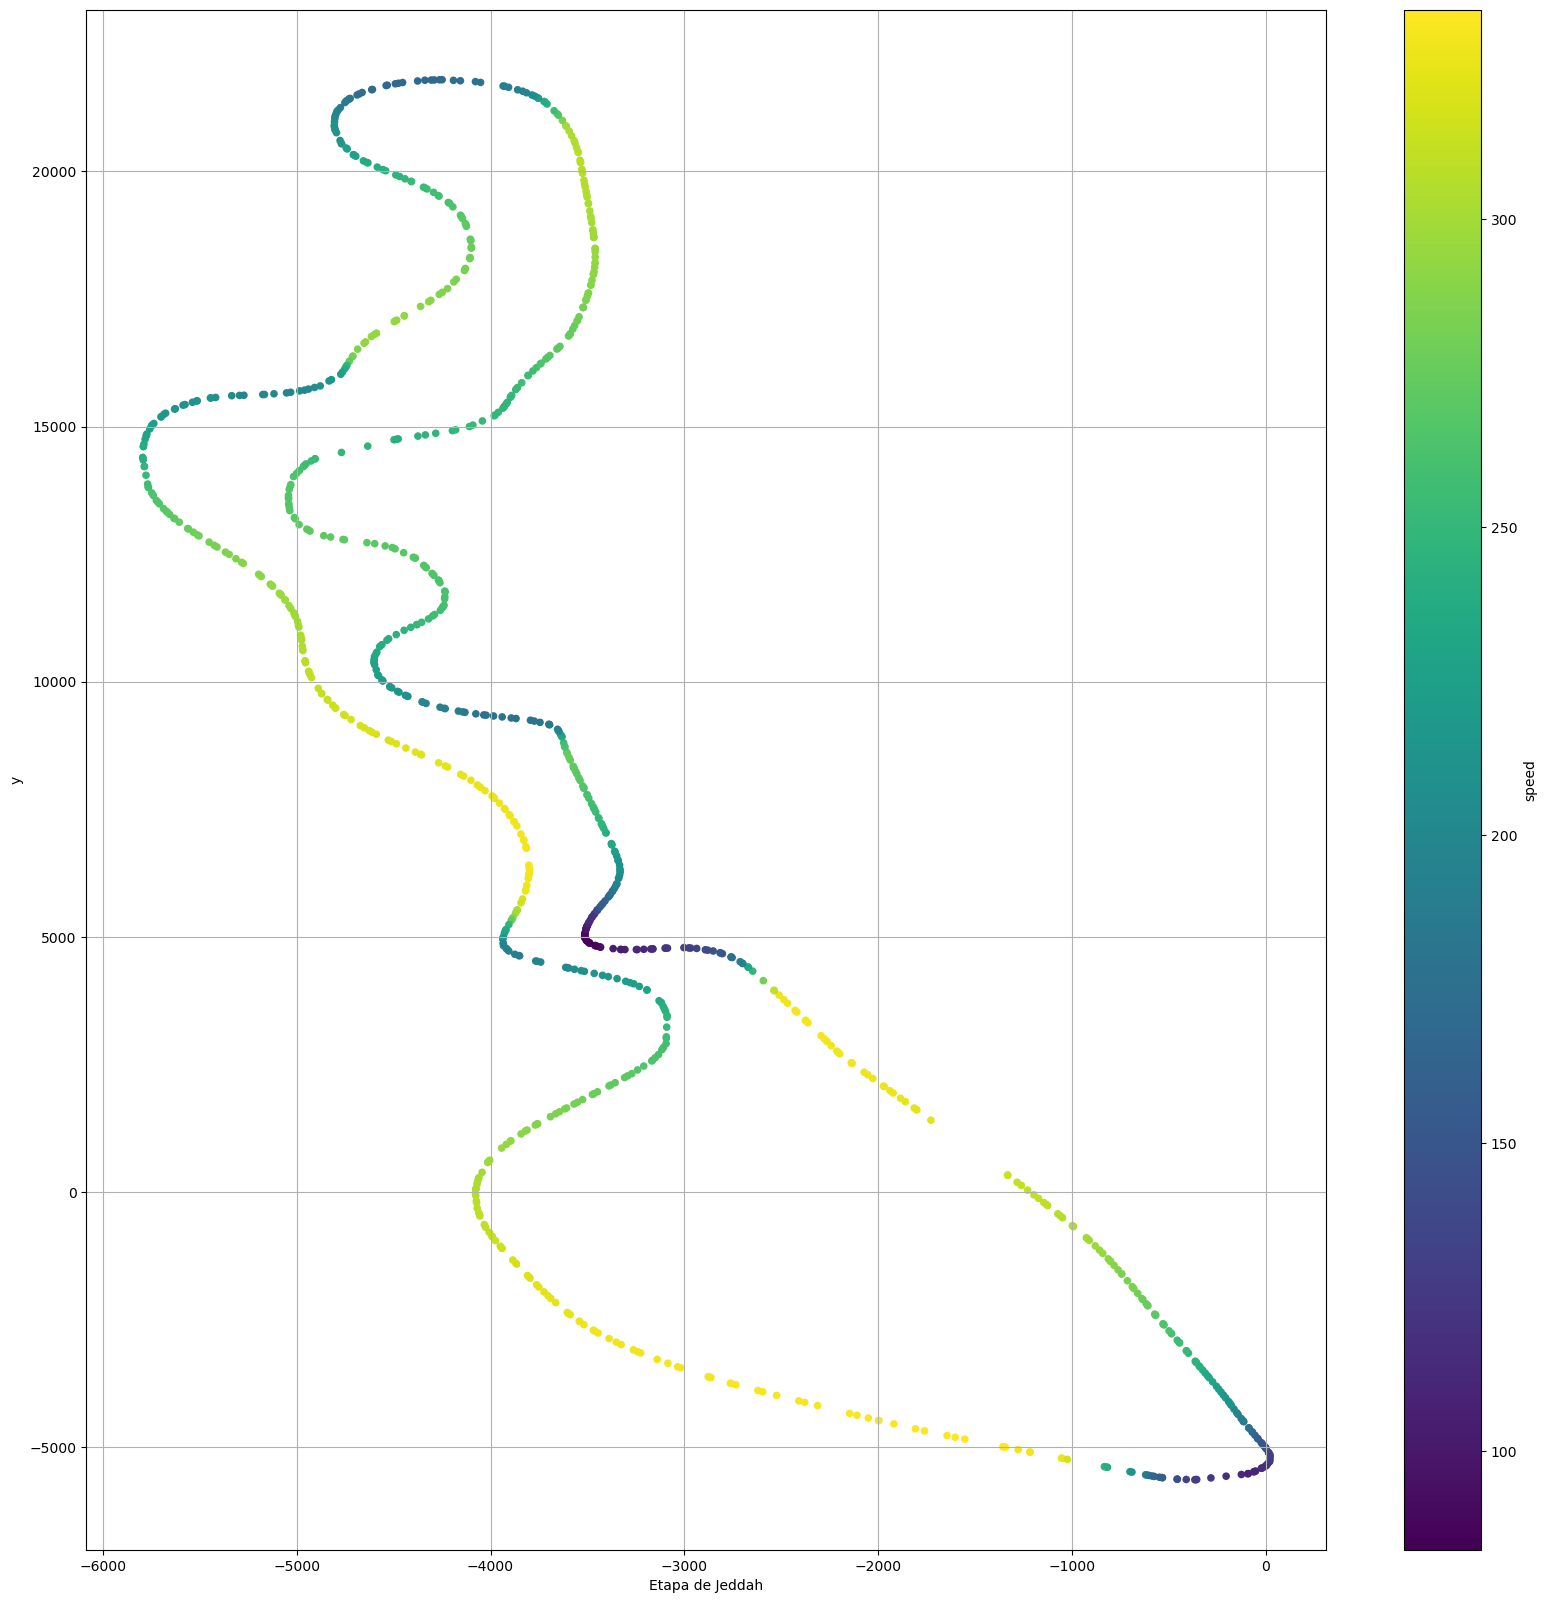

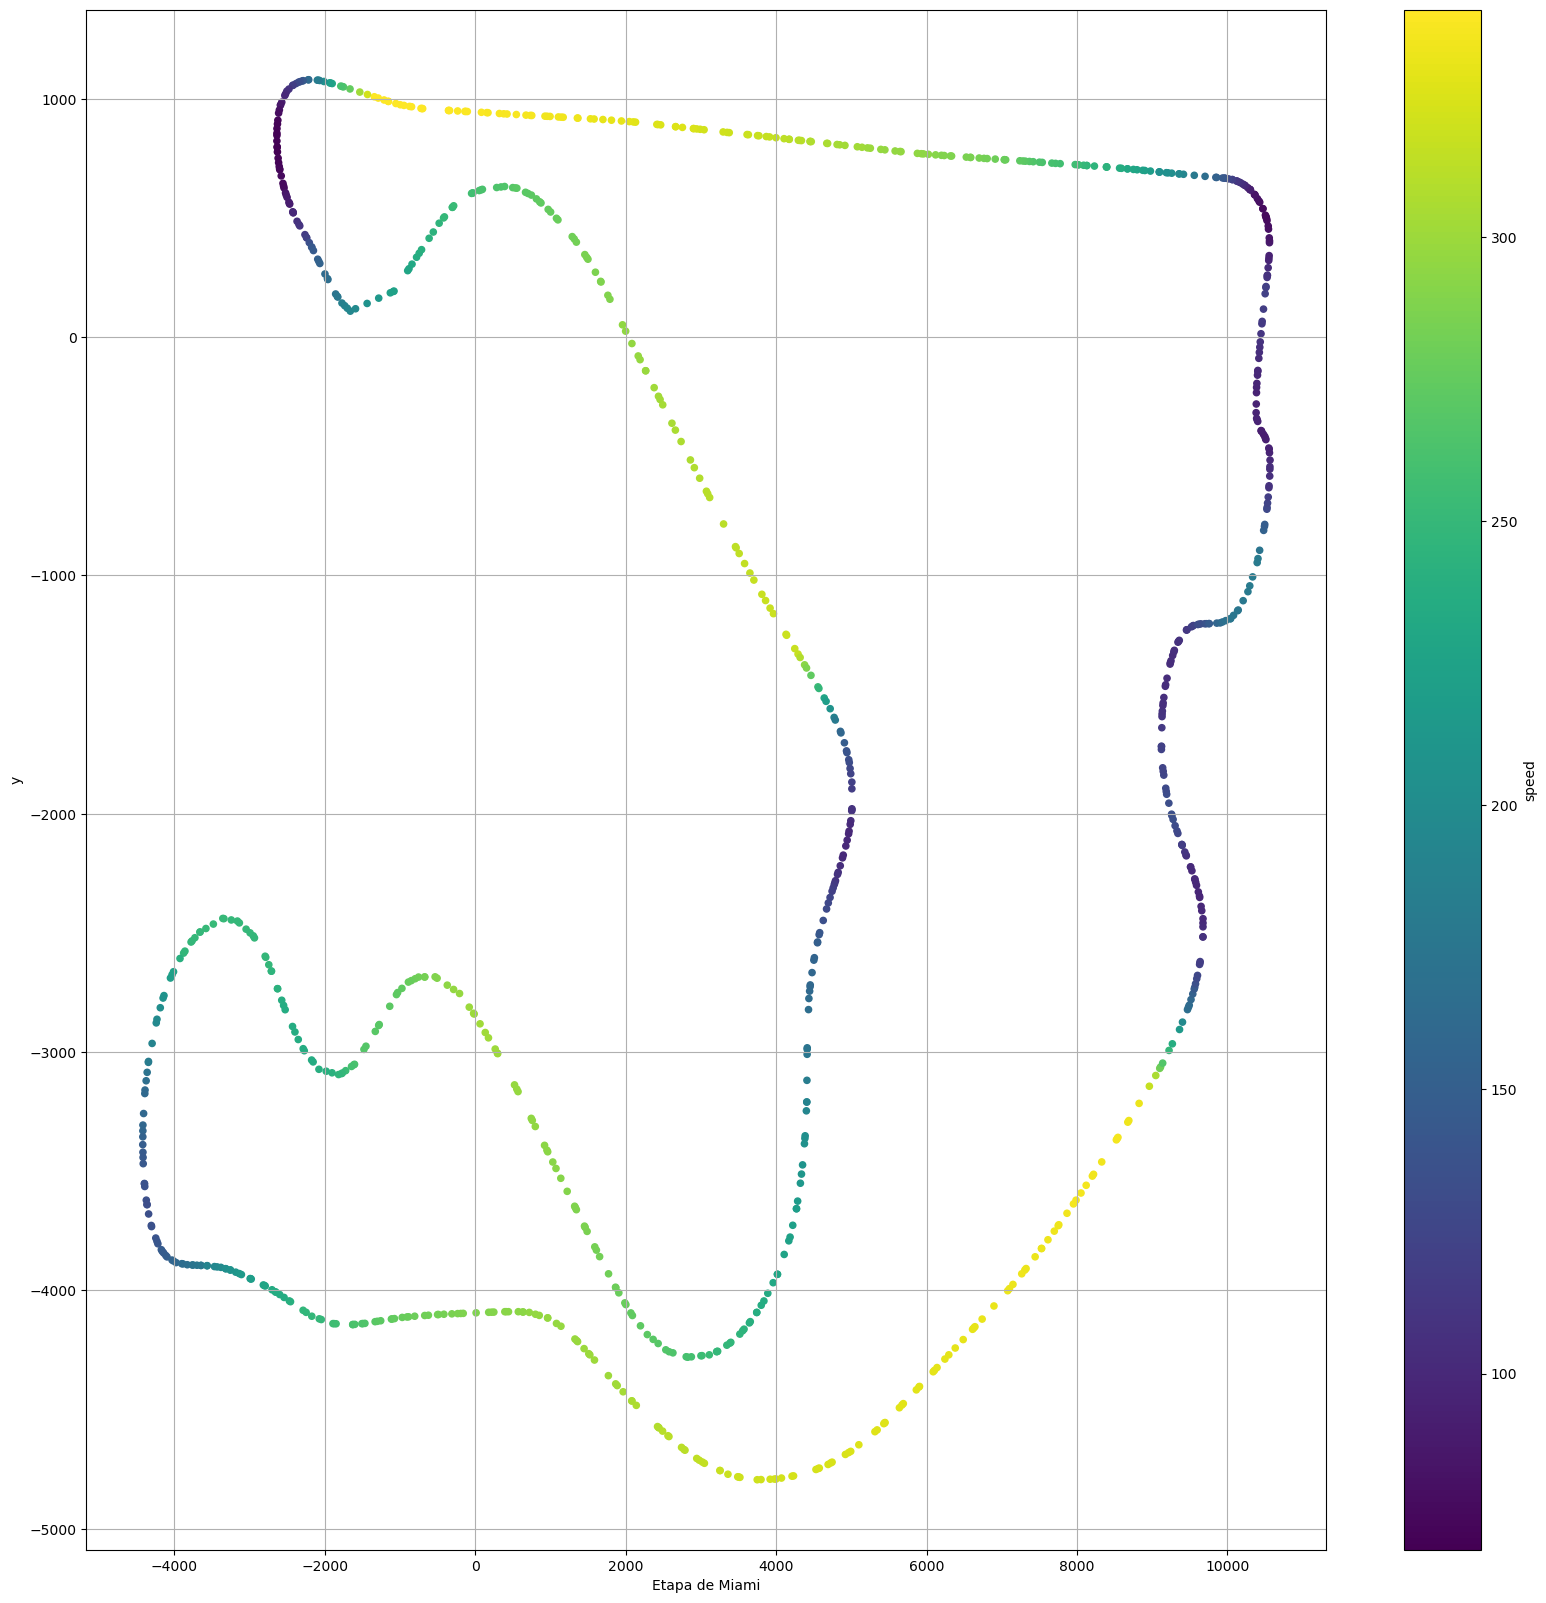

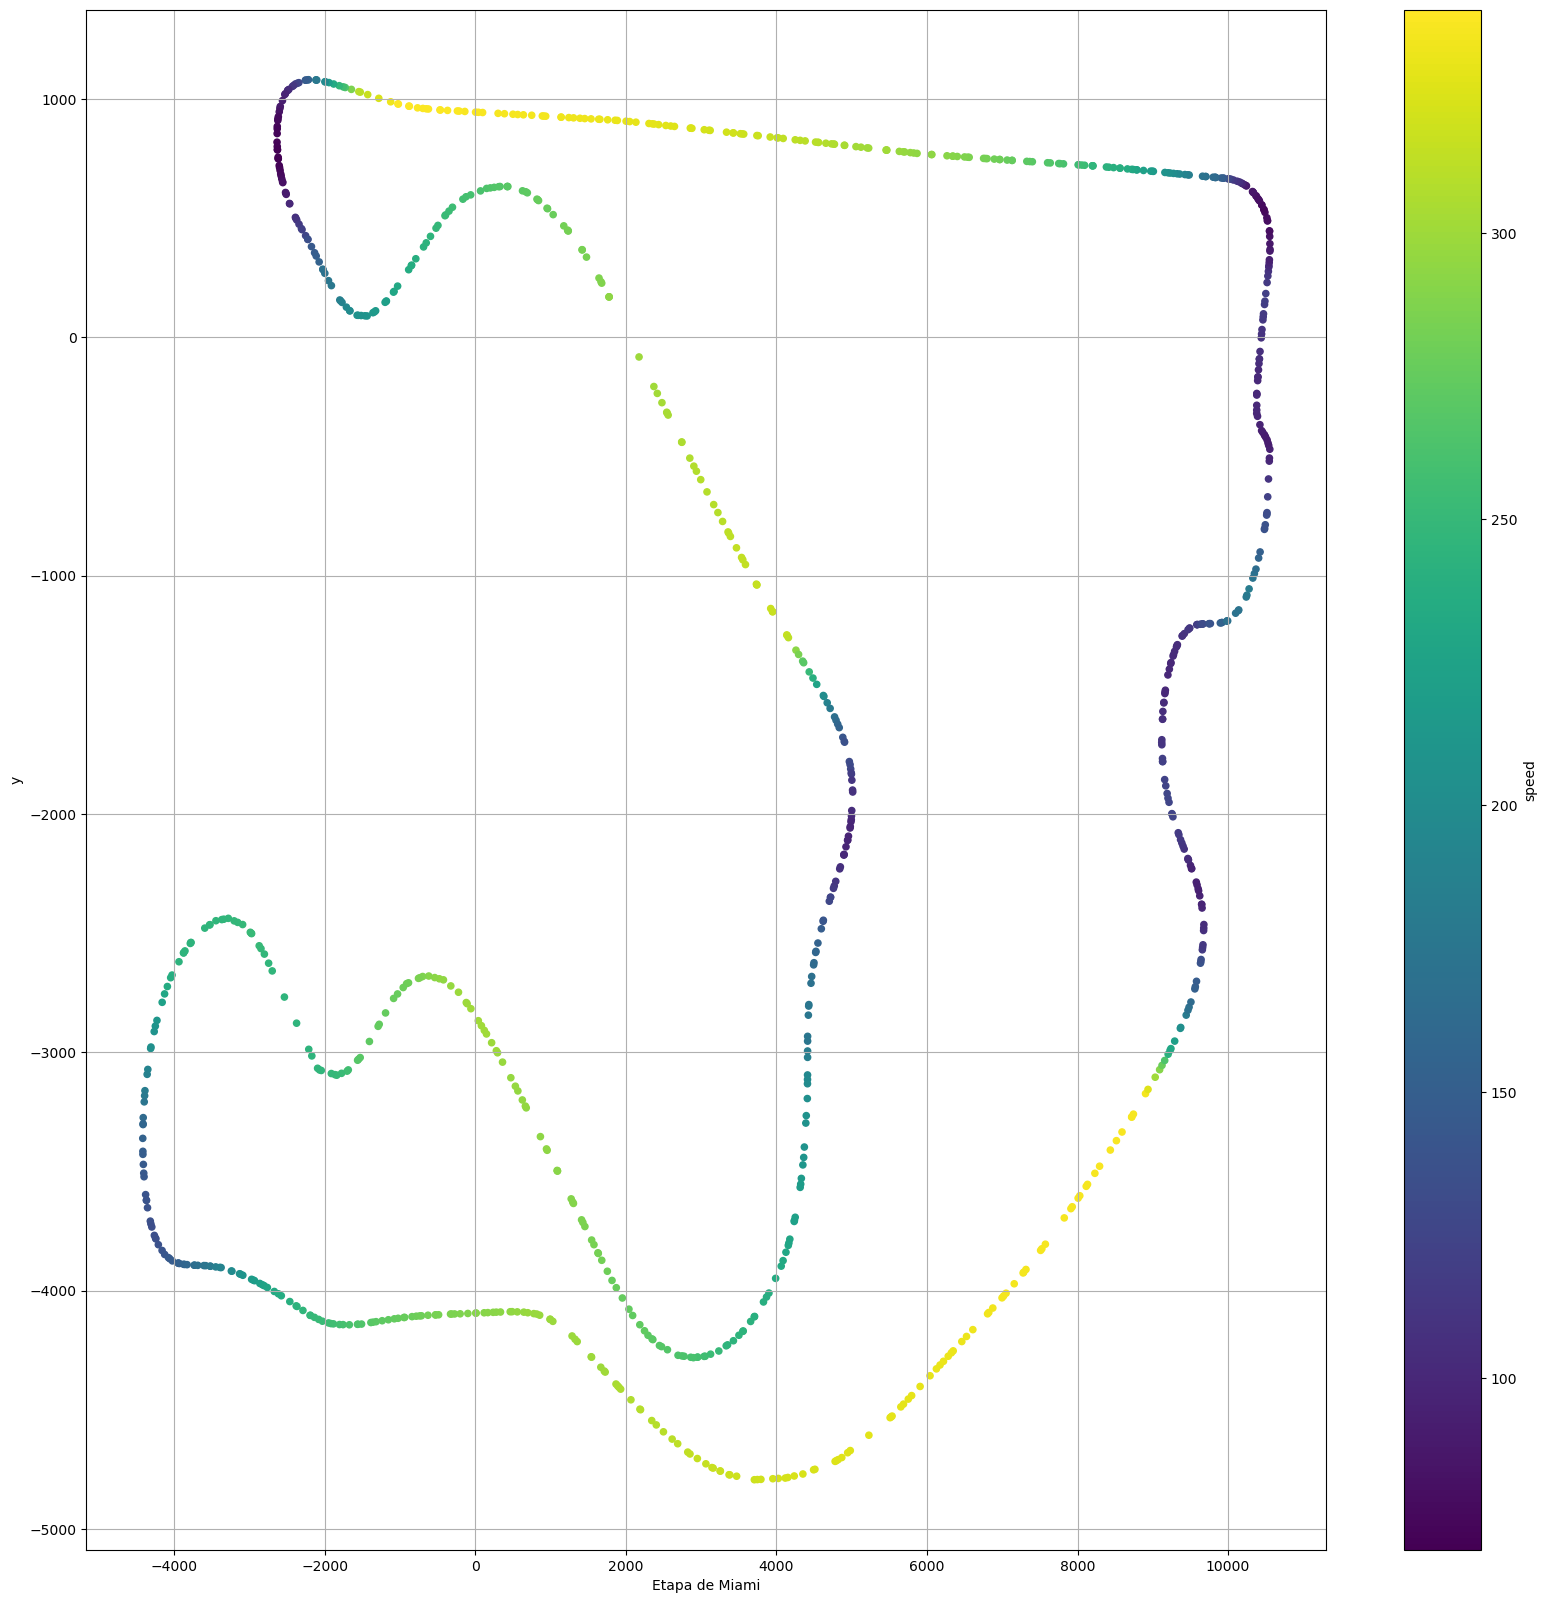

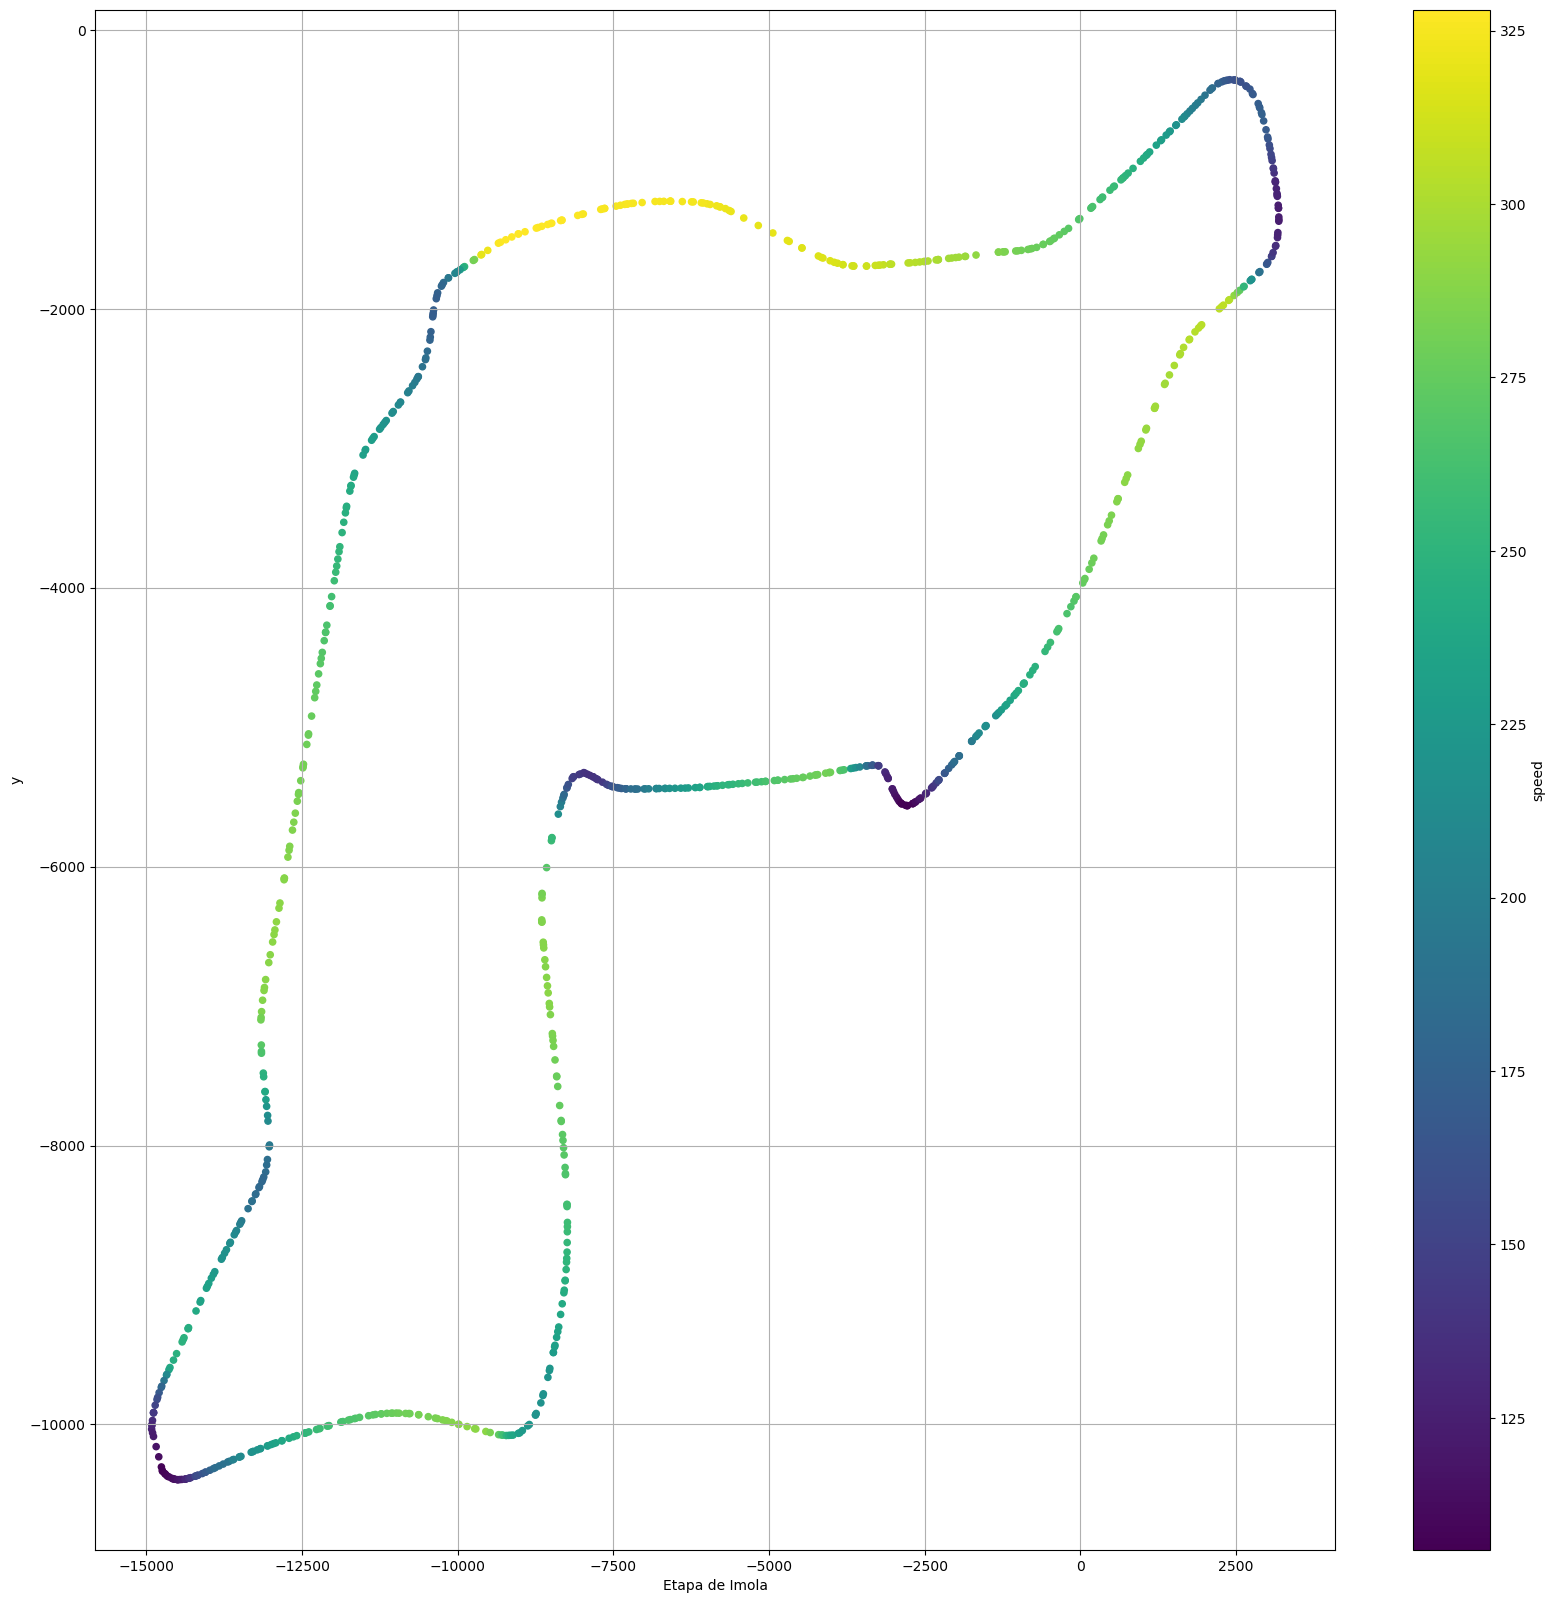

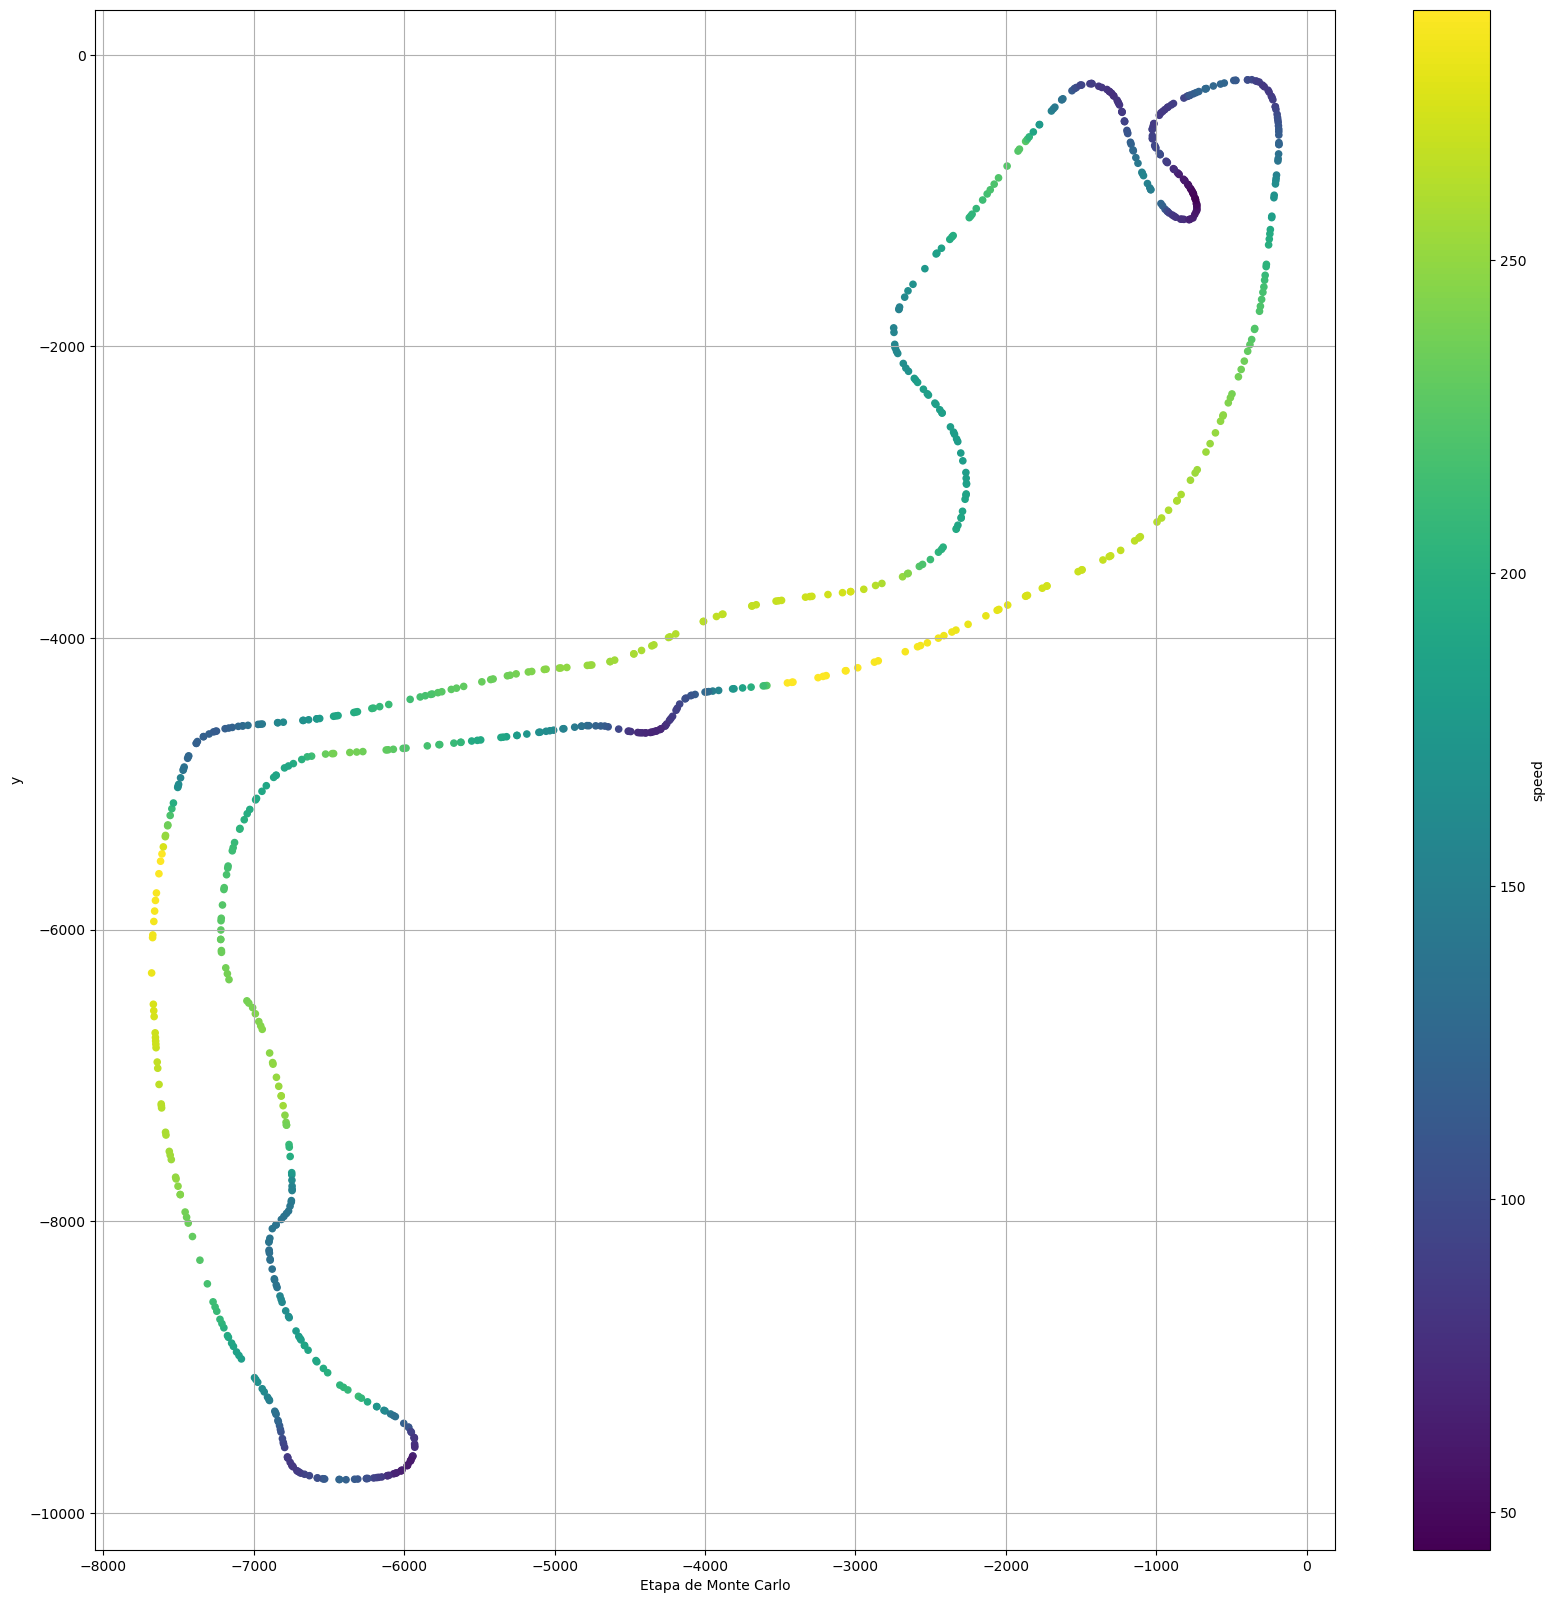

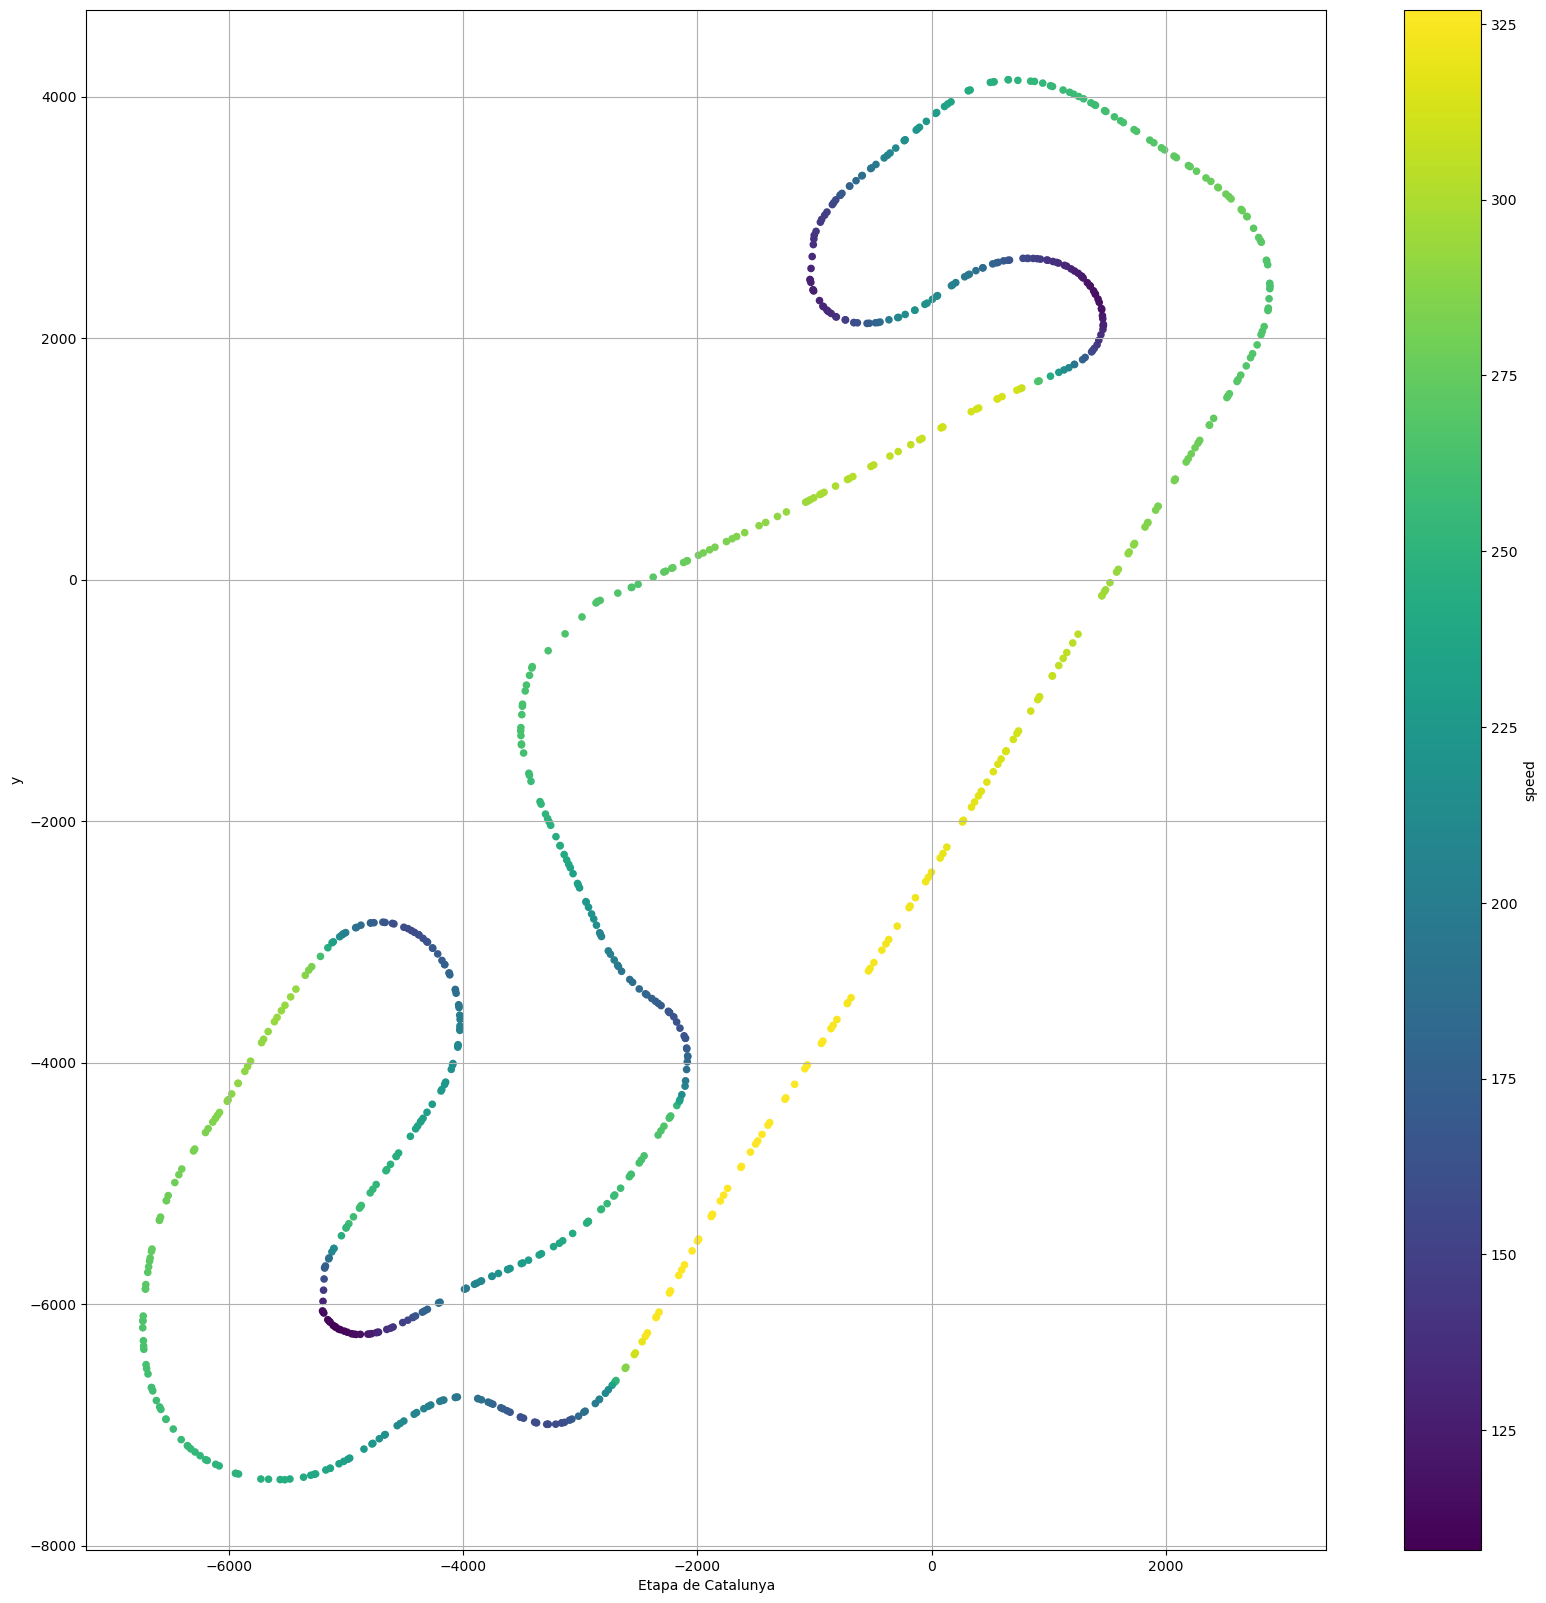

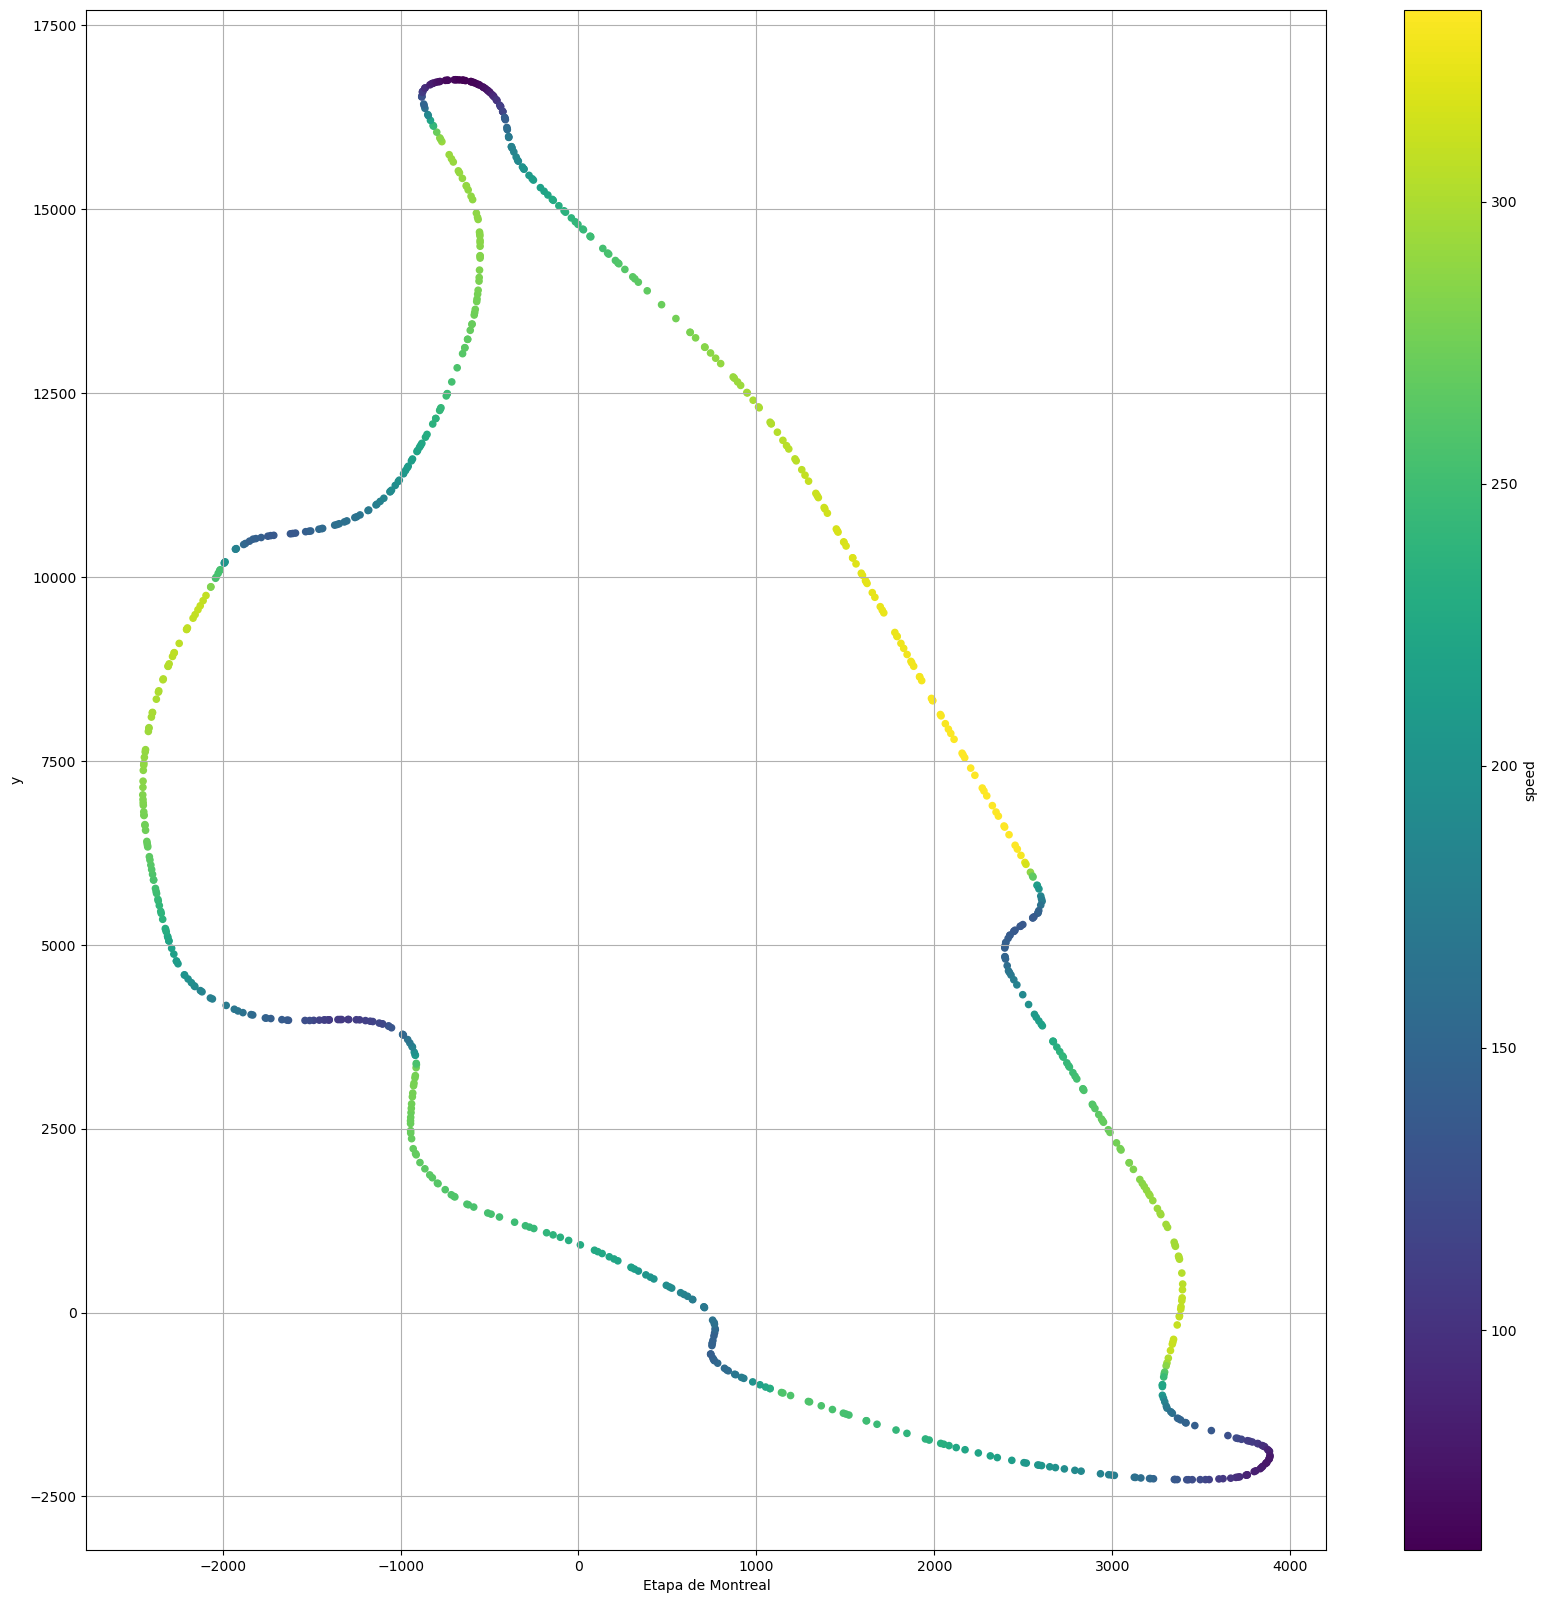

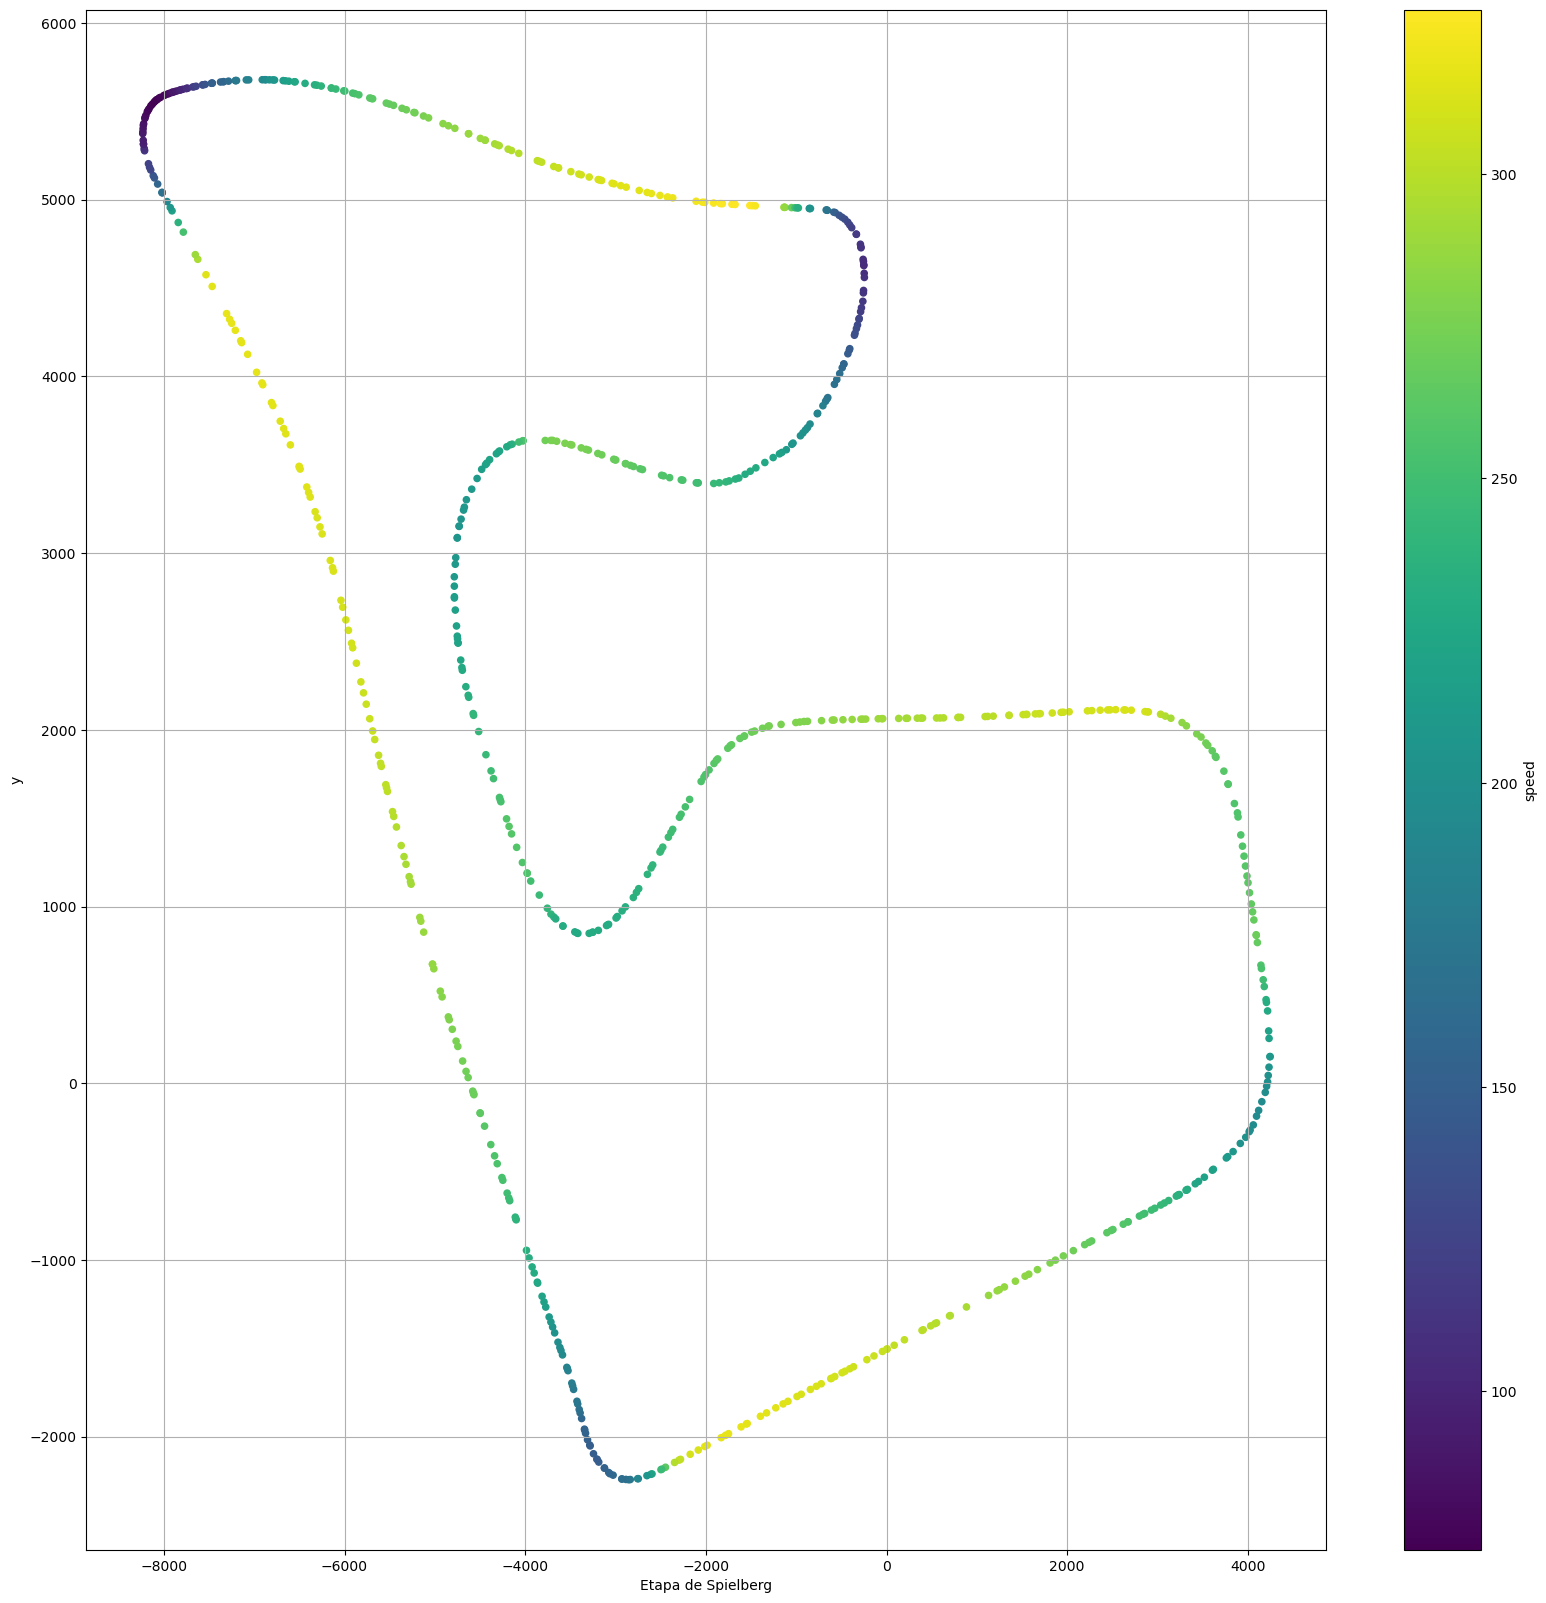

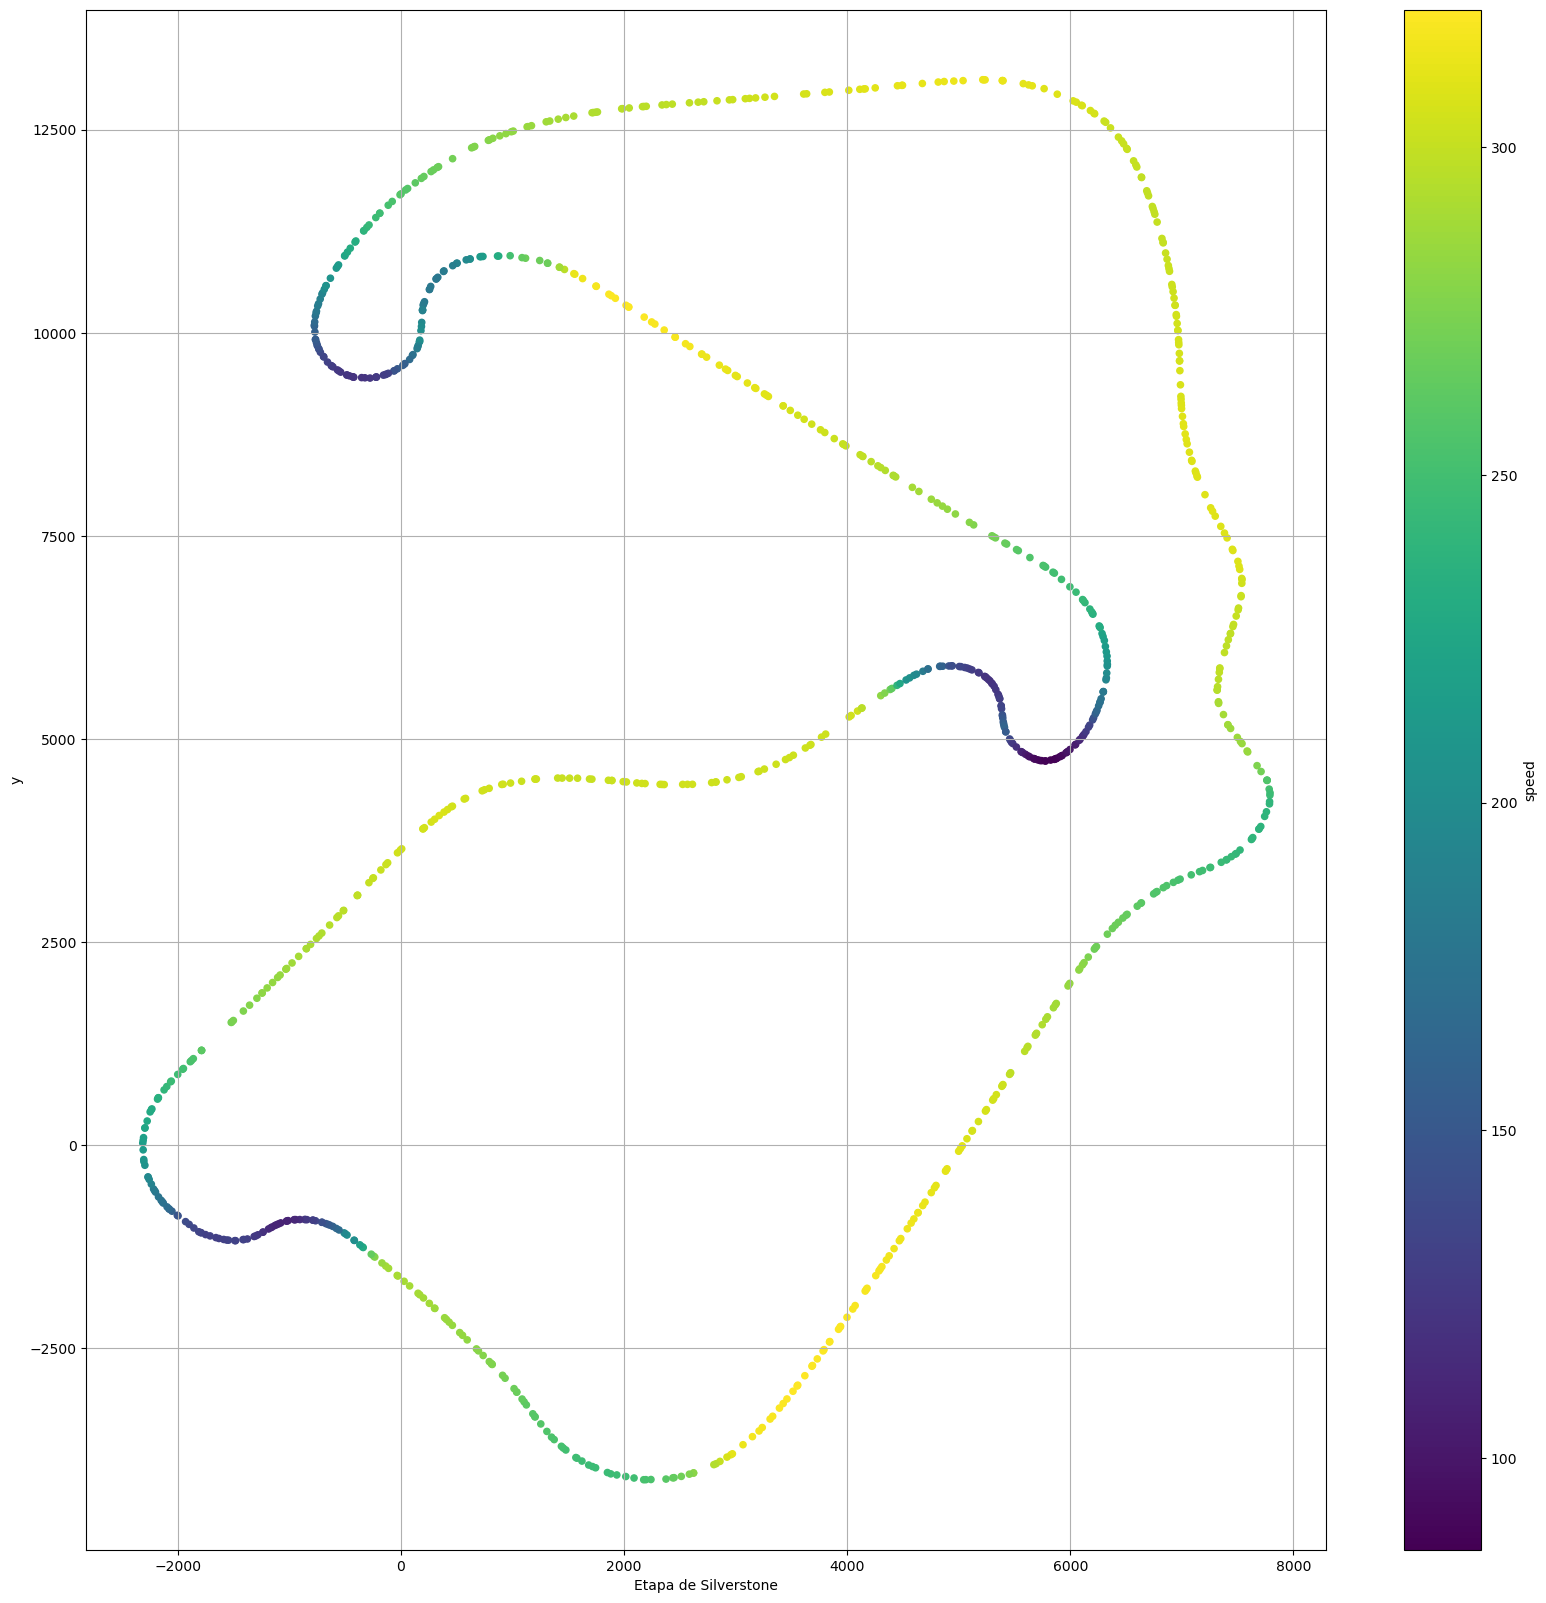

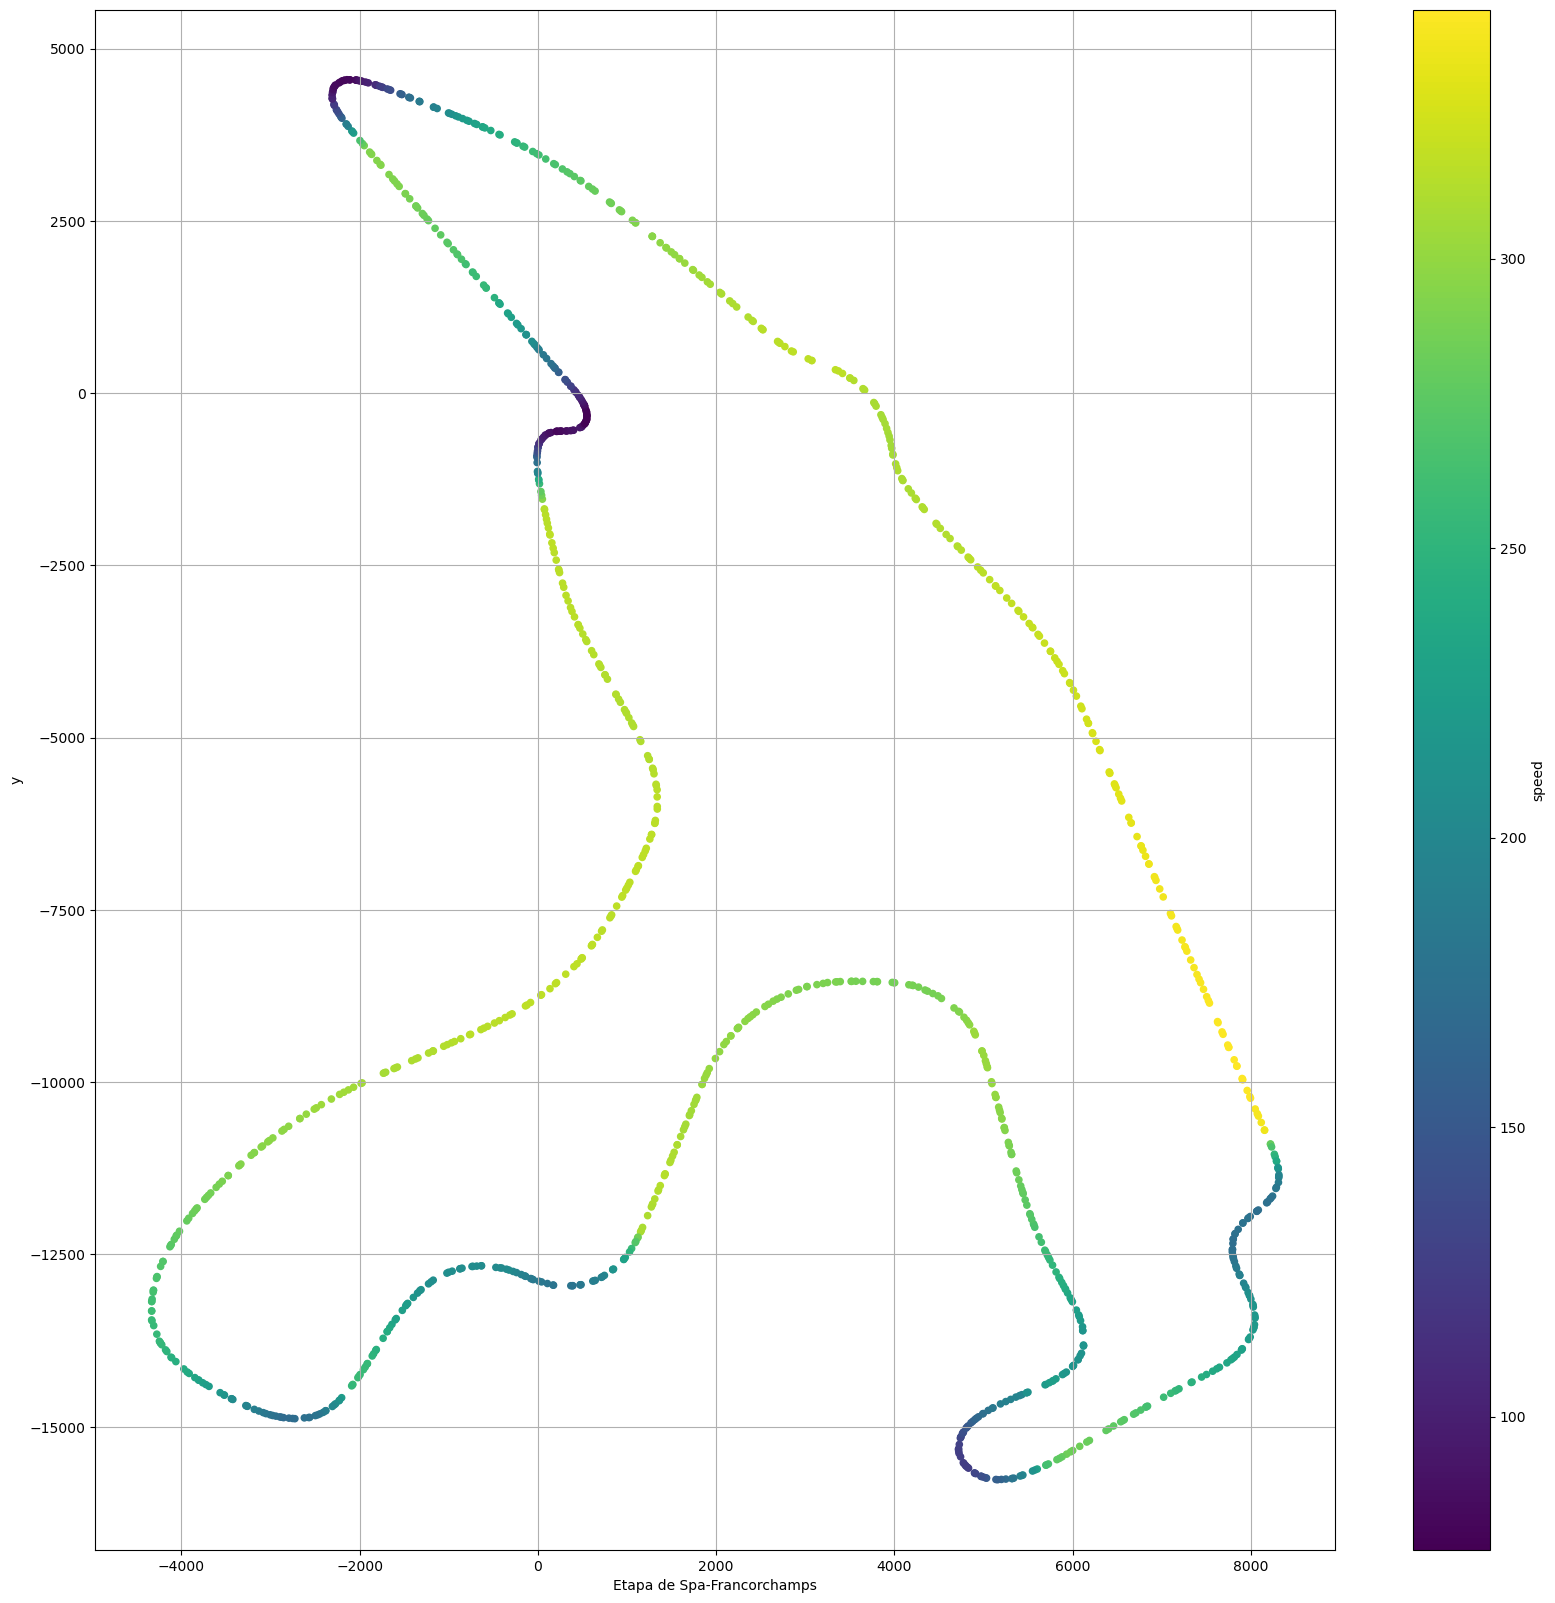

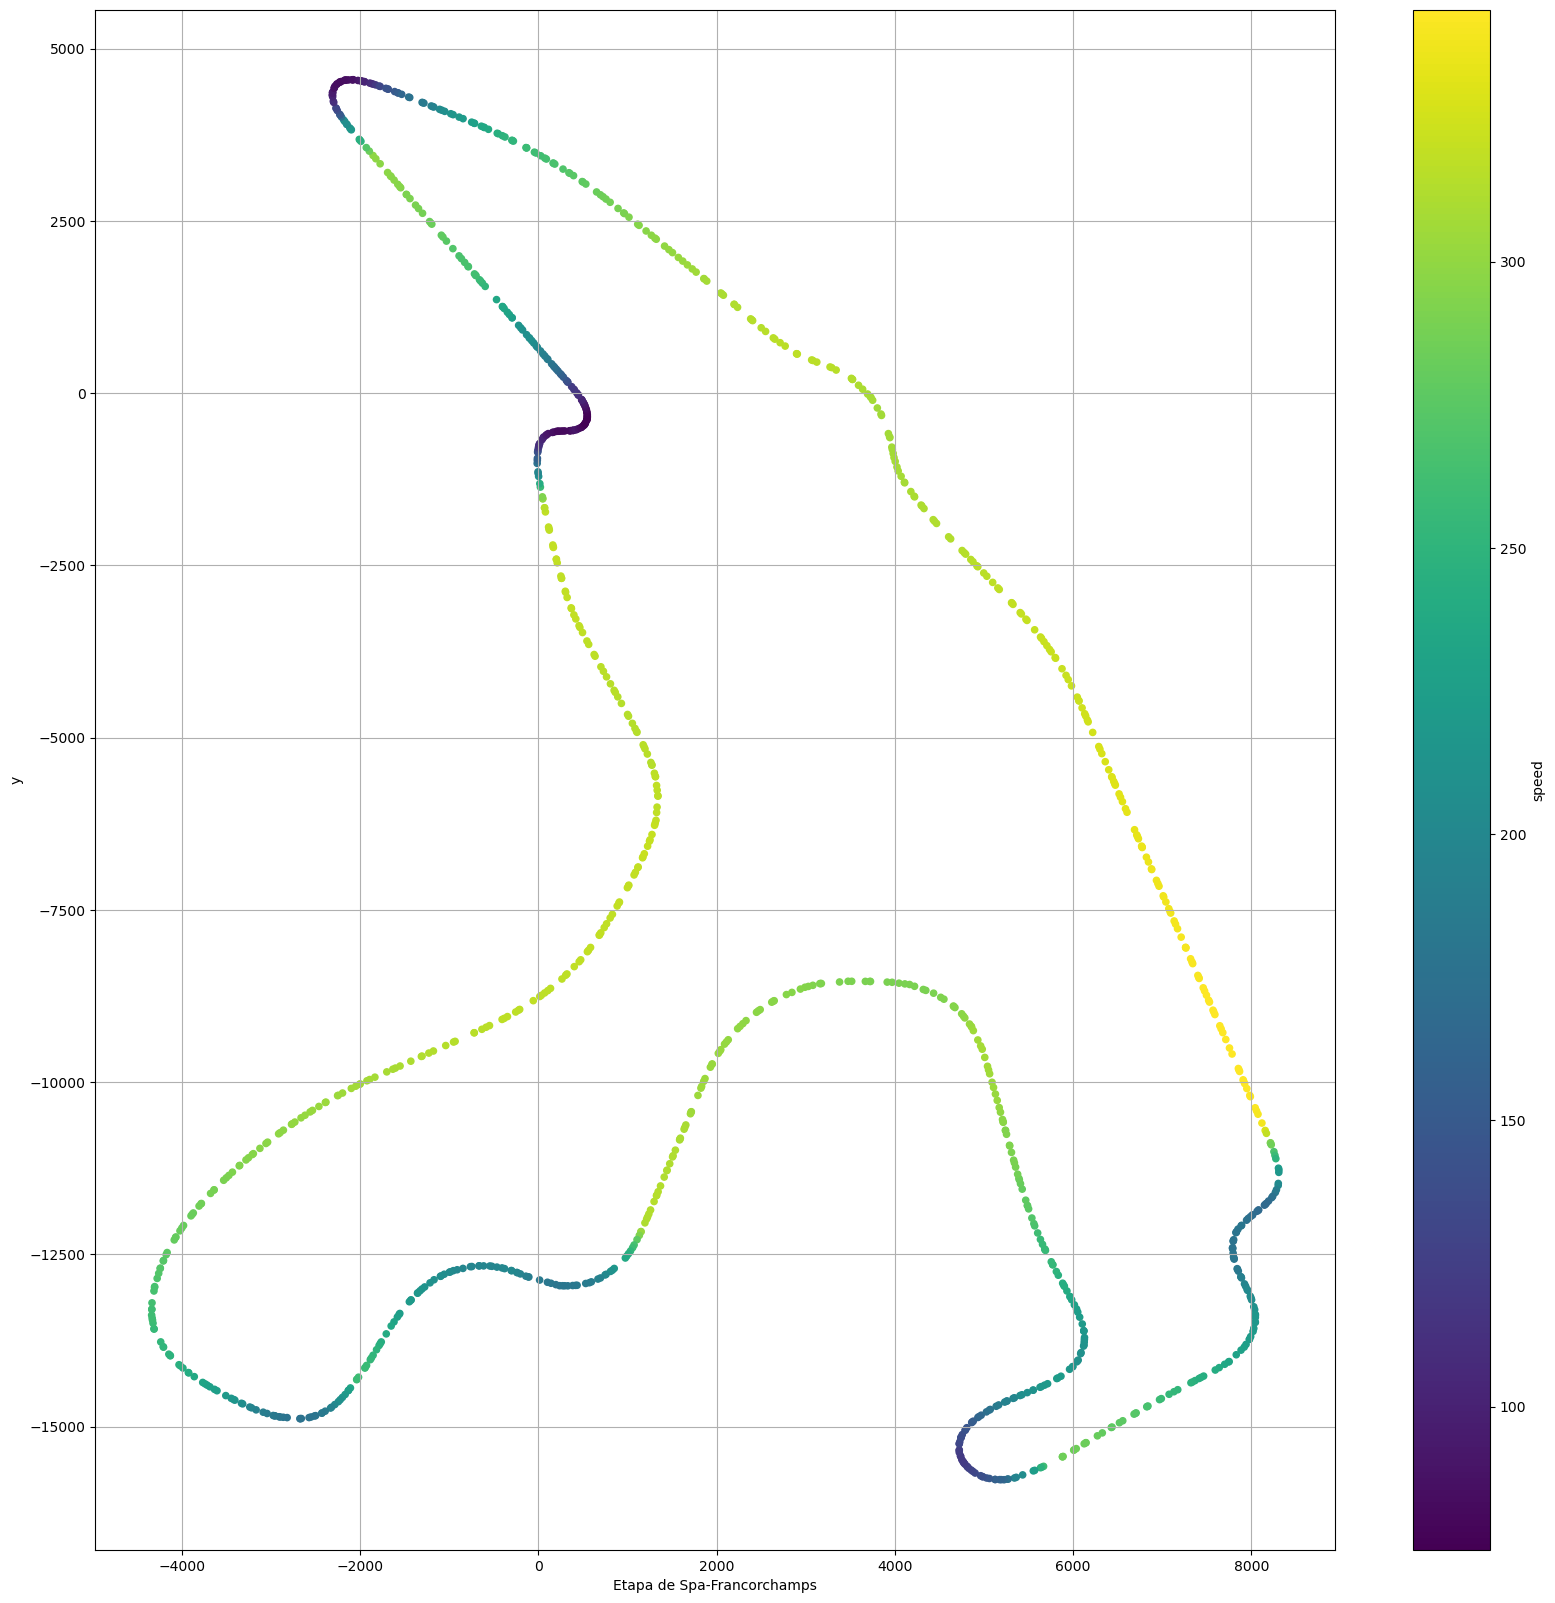

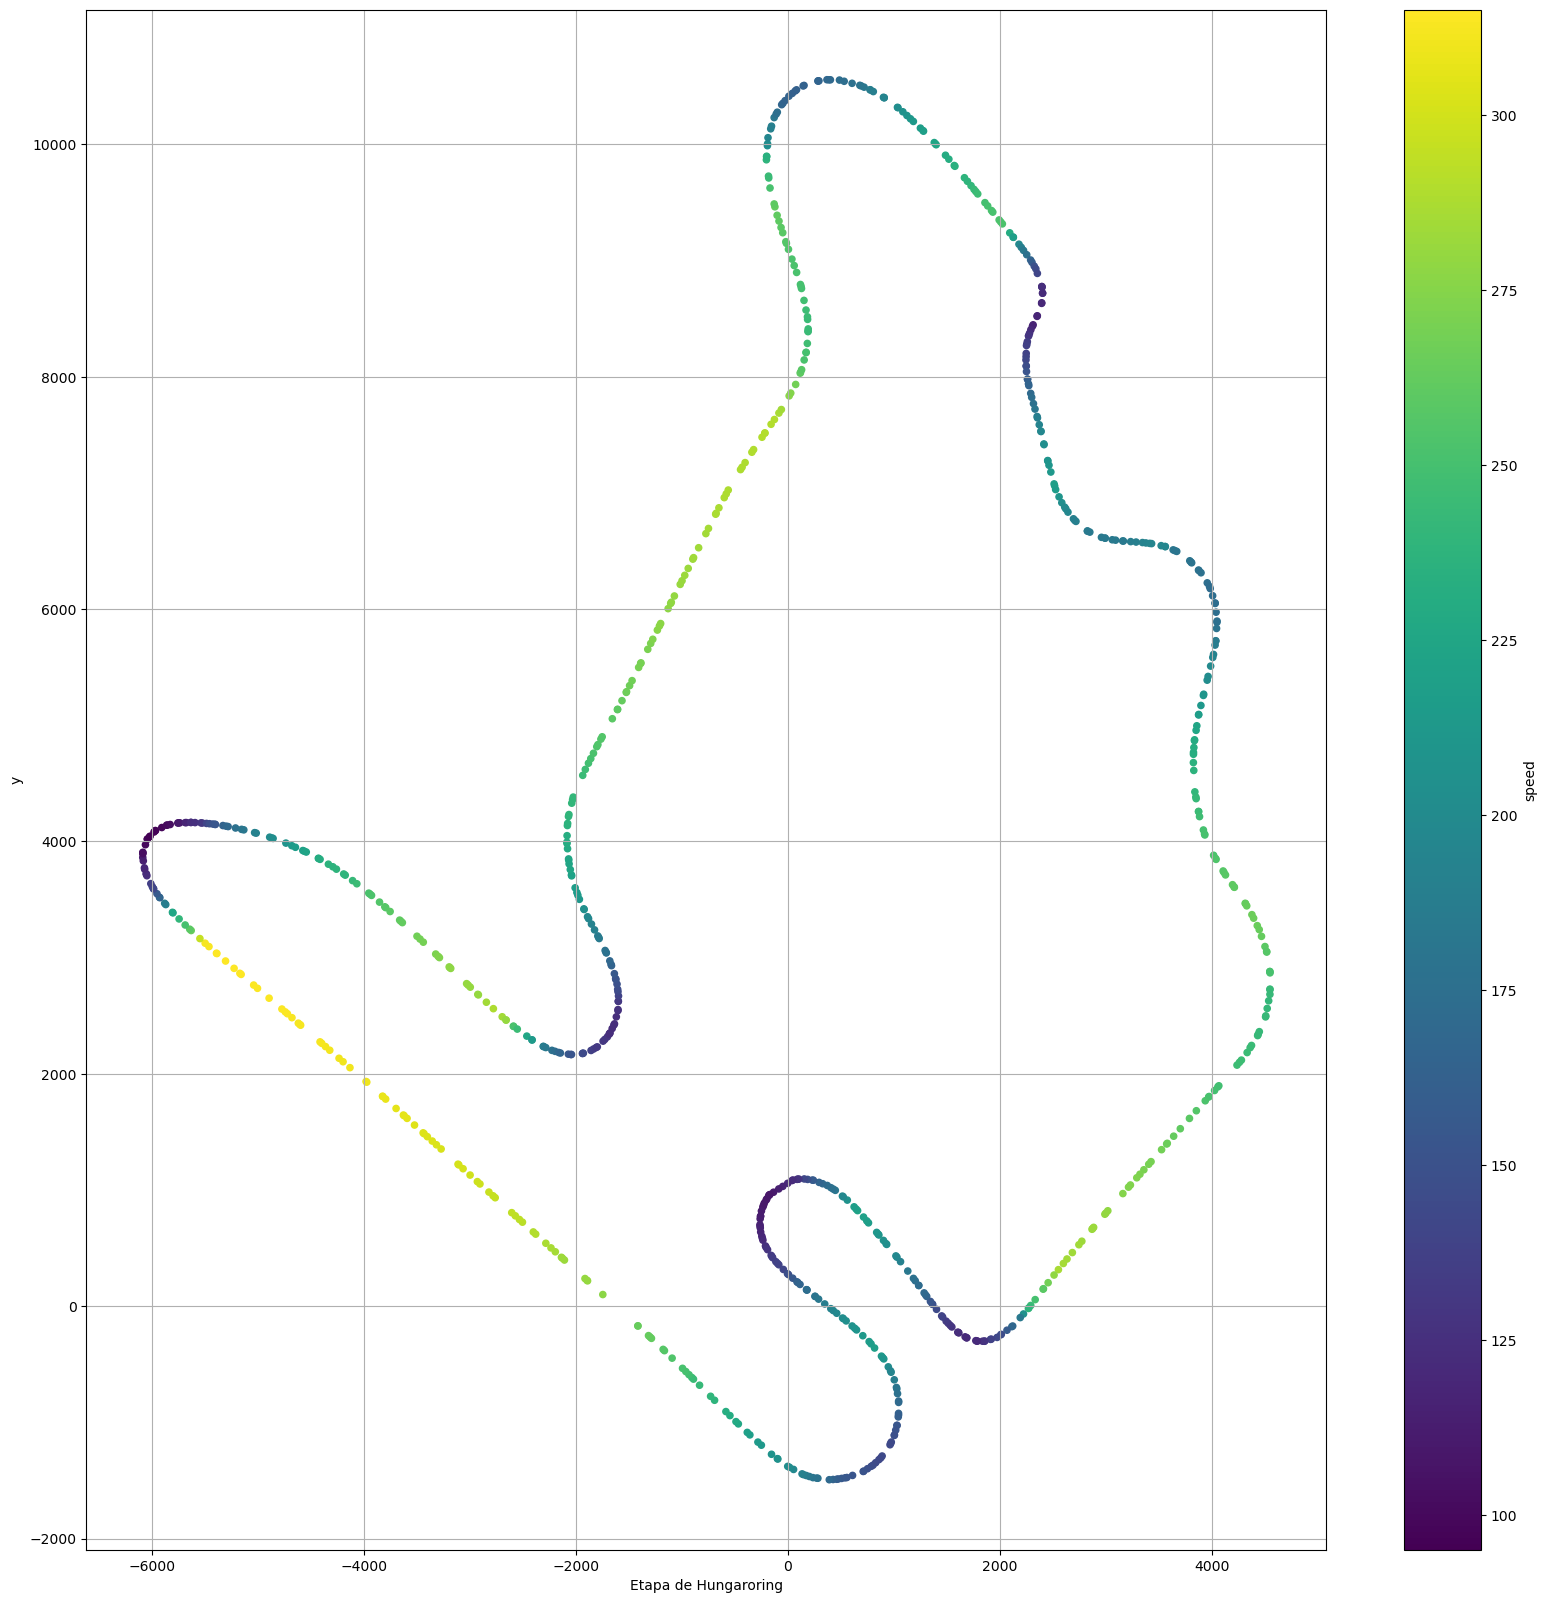

In [ ]:
for sessao in sessoes['session_key']:
    exemplo(sessao)

#### Selecionando curvas:

Com os gráficos criados, podemos selecionar as coordenadas de cada curva.

In [ ]:
todas_curvas = []
for sessao in sessoes['session_key']:
    todas_curvas.append(curvas_escolha(sessao))


#### Salvando as curvas:

Salva as curvas em um arquivo .json.

In [ ]:
conf = str(input("Deseja salvar as curvas? Pressione 1 "))
if conf == '1':
        curvas = open('Curvas.json', 'w', encoding='utf-8')
        json.dump(todas_curvas, curvas)
        curvas.close()

#### Recuperar as curvas salvas no arquivo:

Lê o arquivo .json das curvas, e salva em uma variável.


In [80]:
curvas = open('Curvas.json', 'r', encoding='utf-8')
todas_curvas = json.load(curvas)
curvas.close()

#### Verificação das curvas:

Refaz o processo de mostrar o gráfico para um piloto exemplo, dessa vez também mostrando cada curva selecionada, para fins de validação.

/usr/lib/python3.13/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


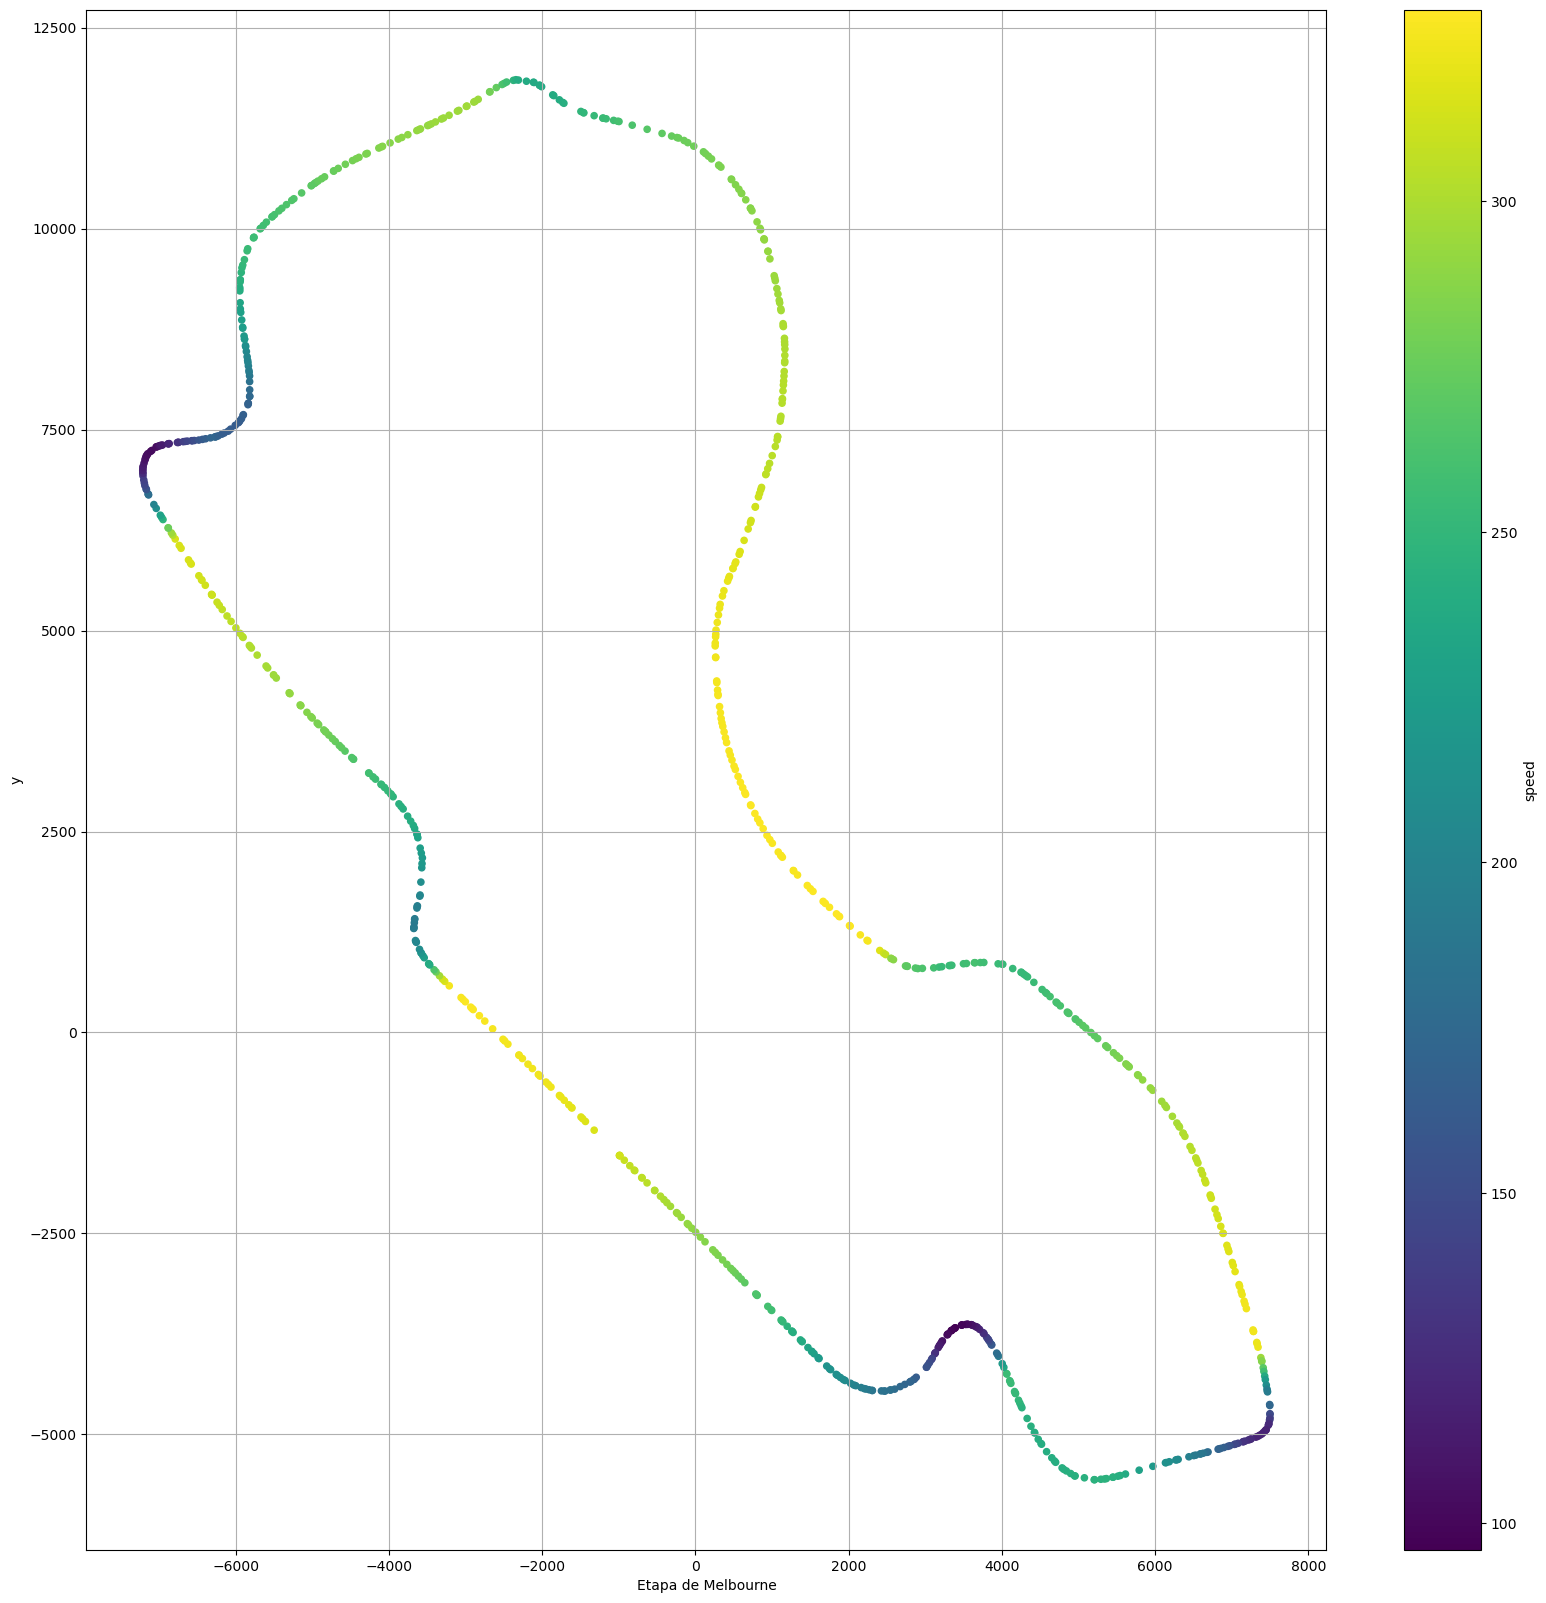

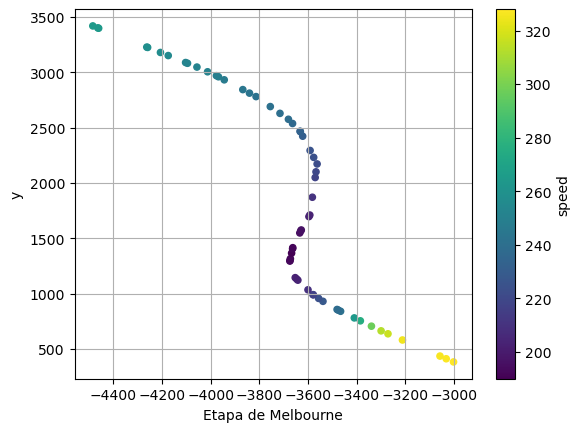

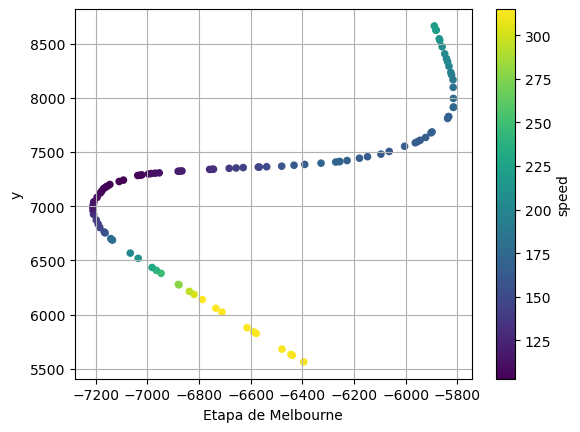

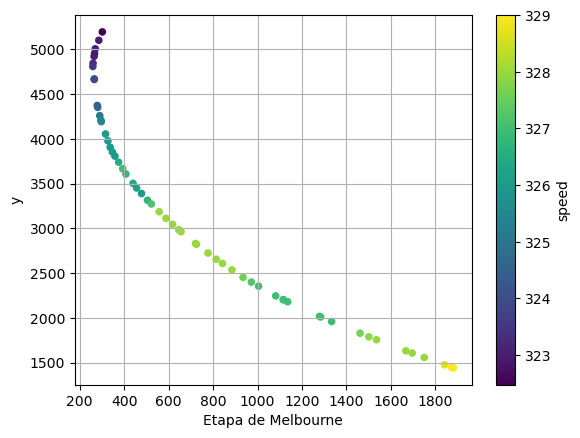

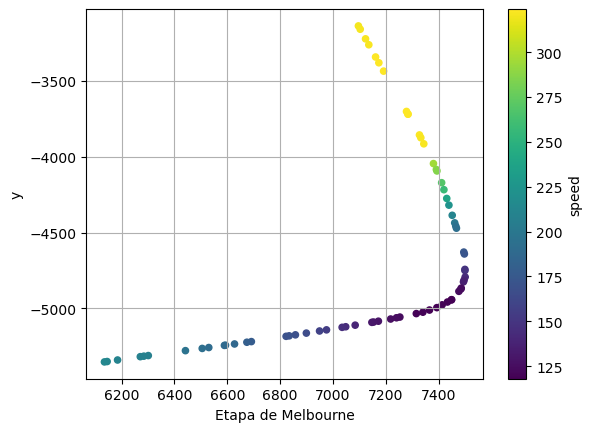

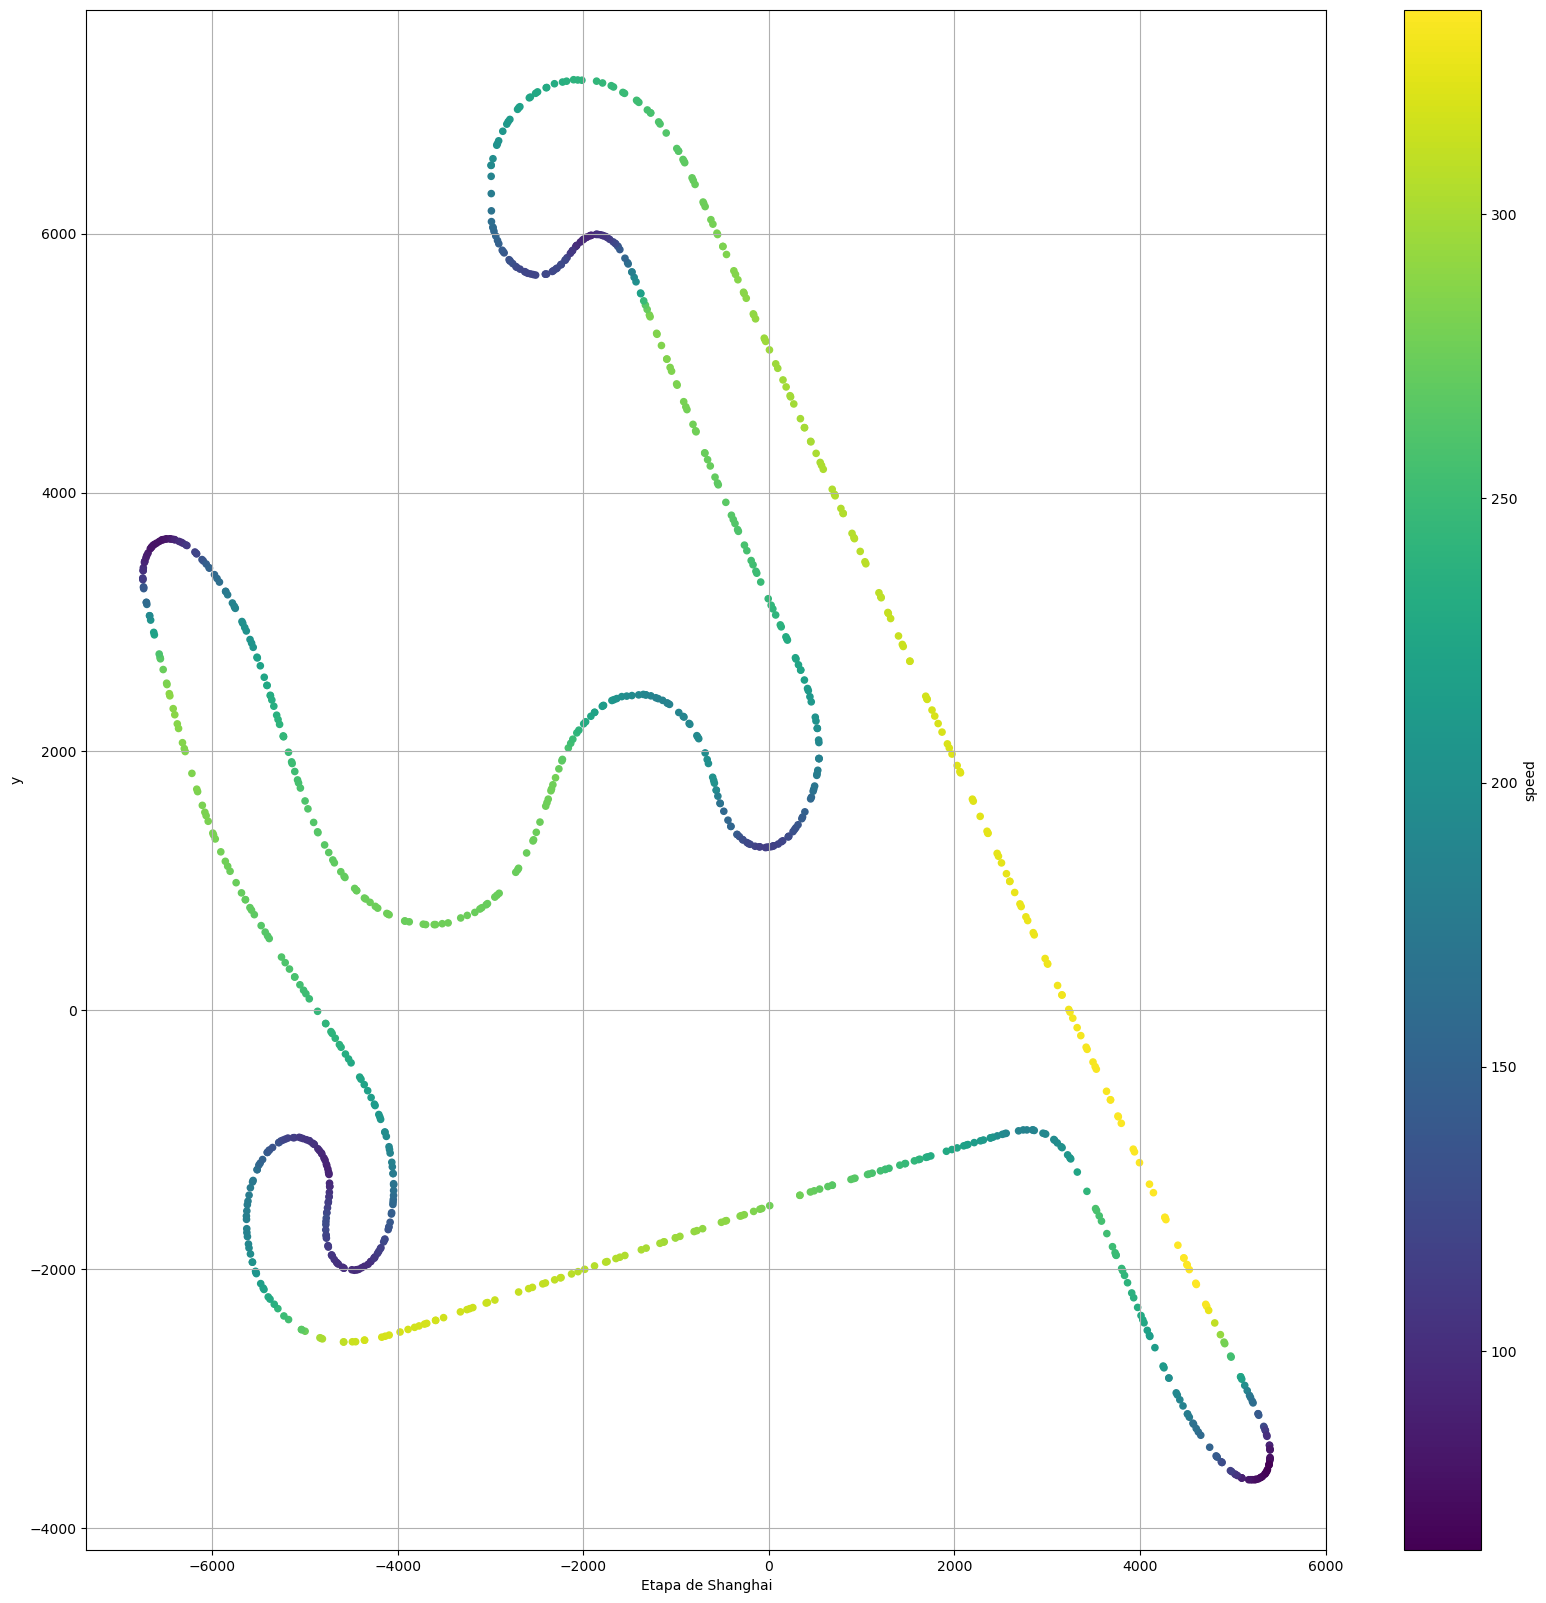

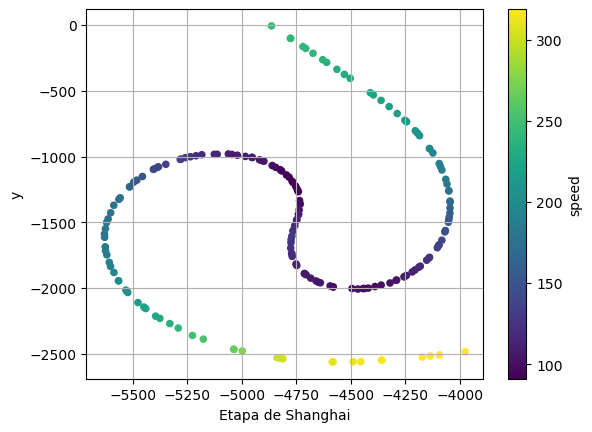

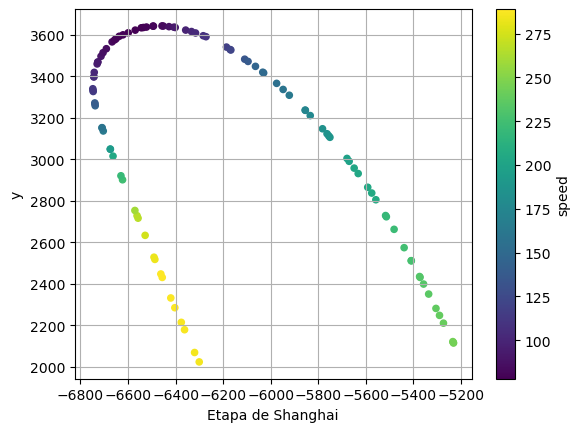

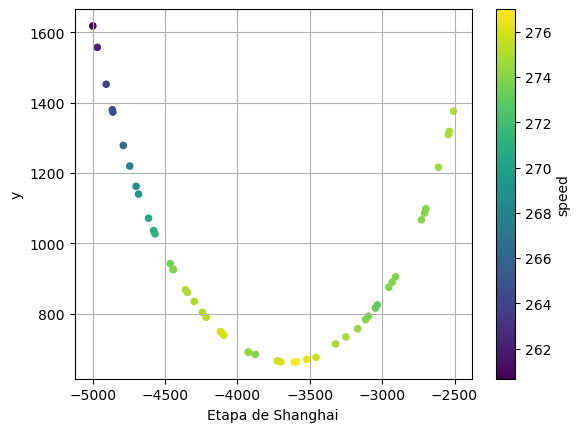

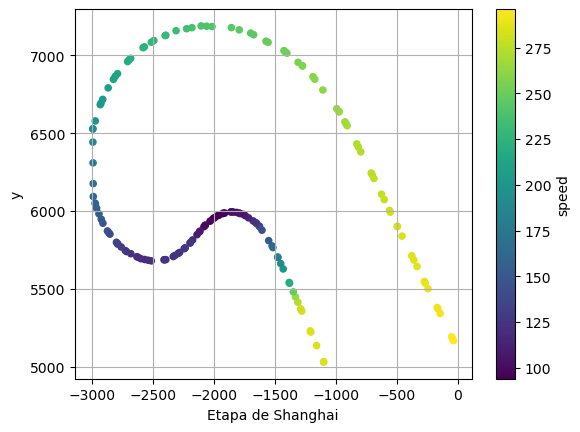

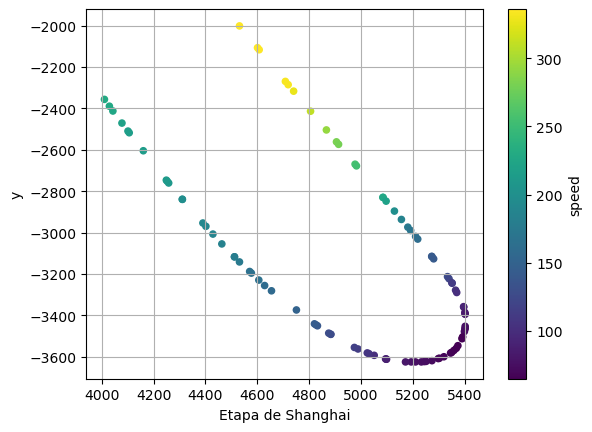

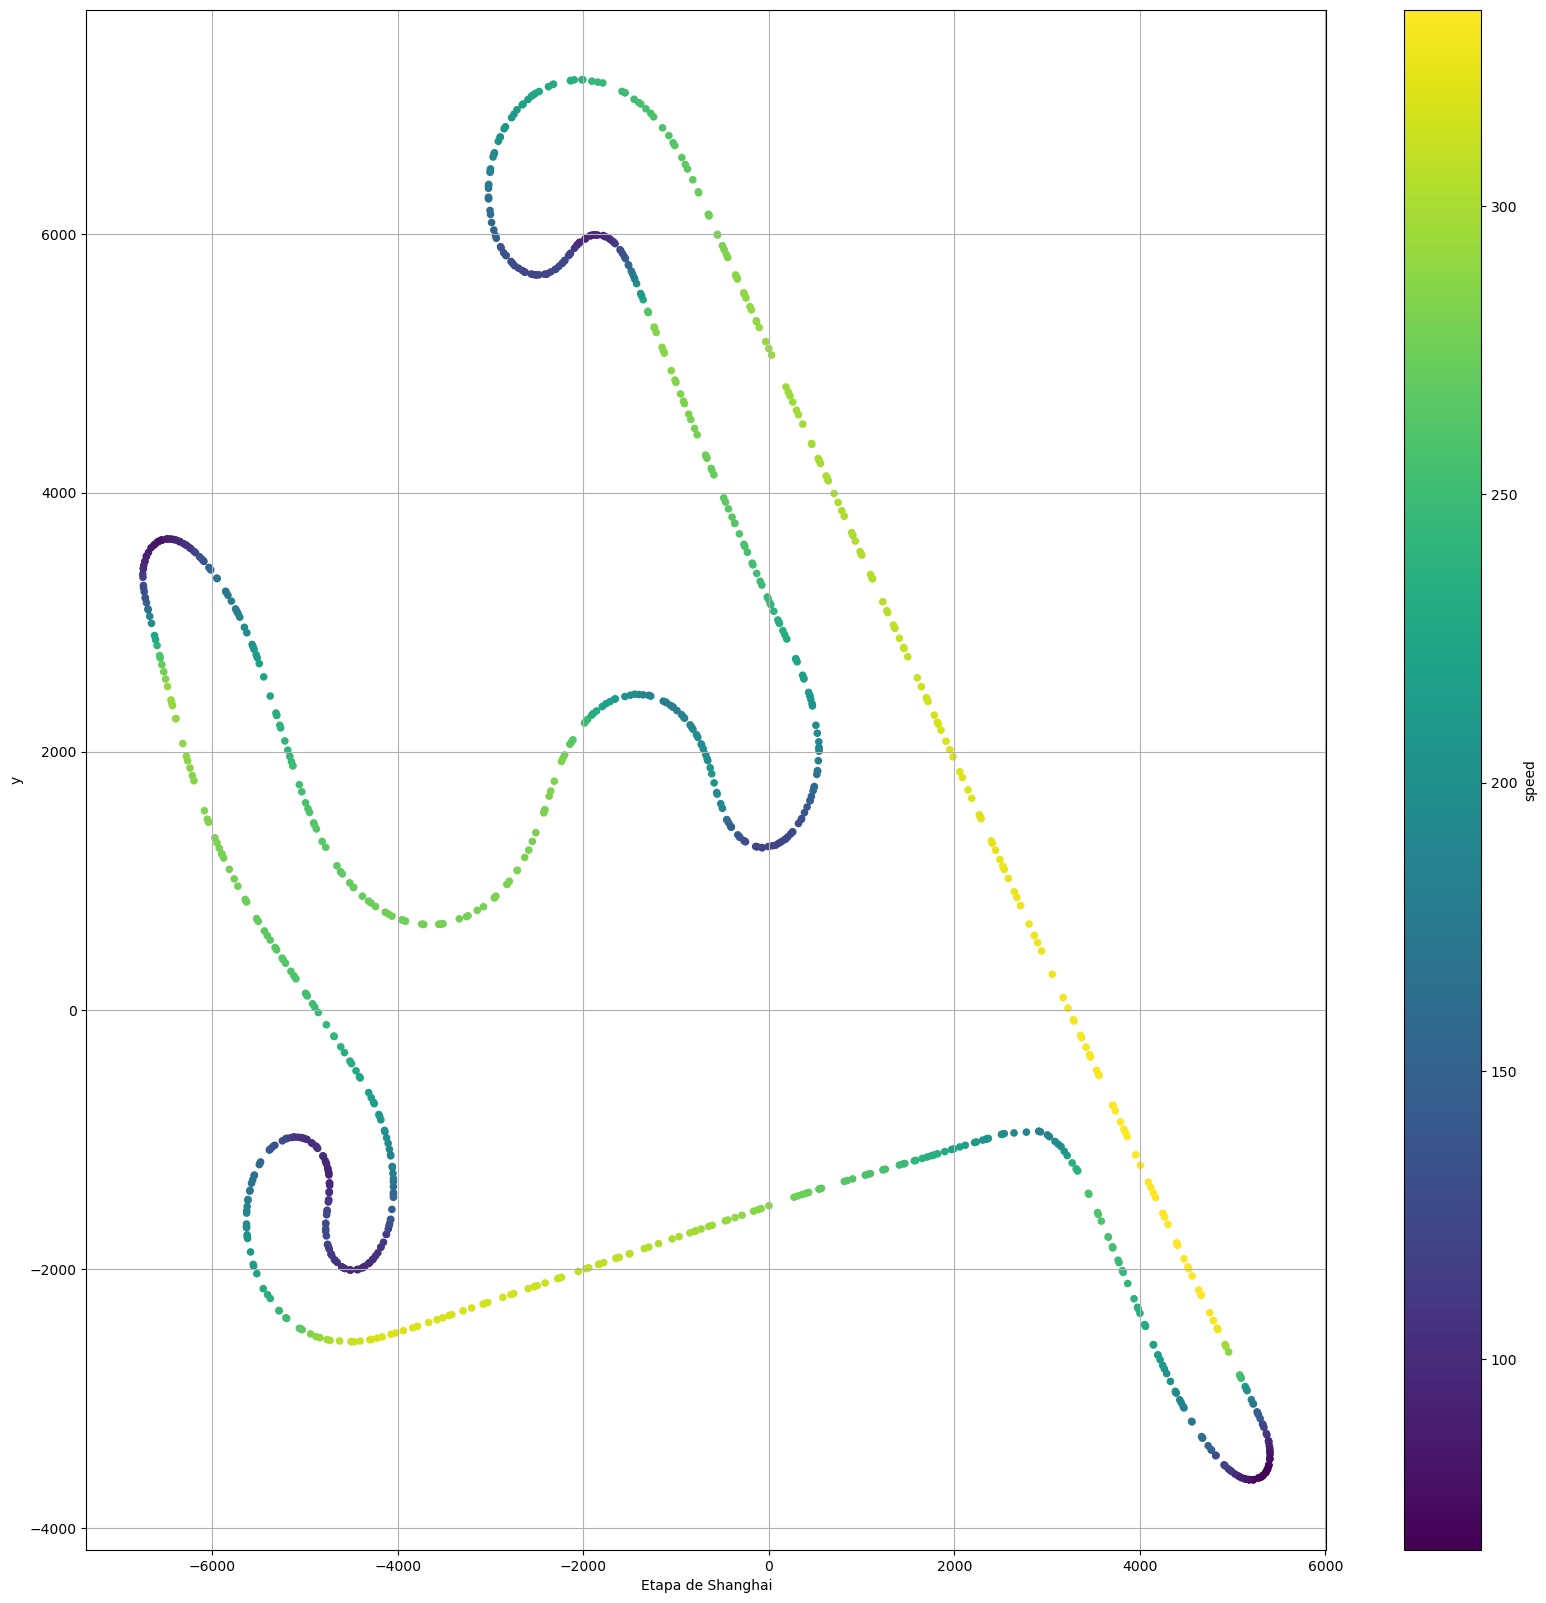

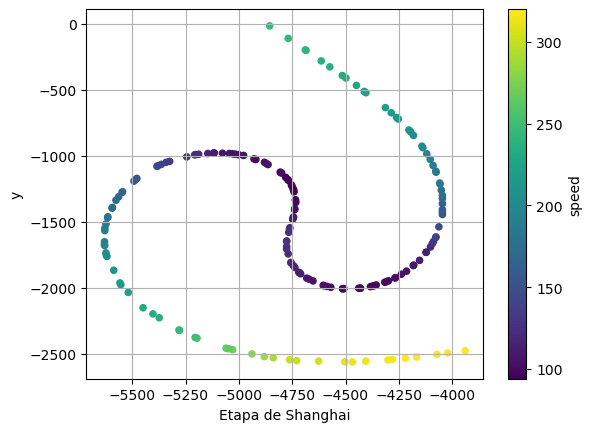

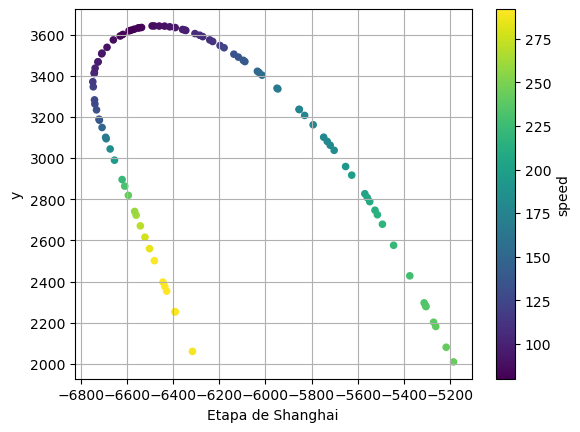

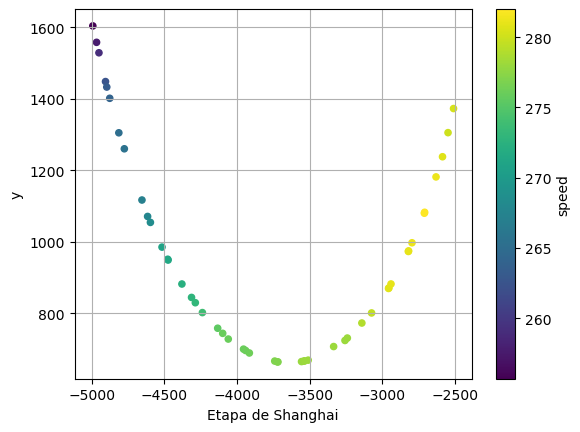

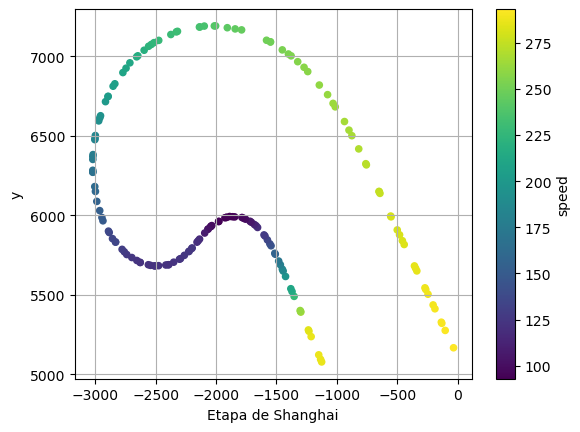

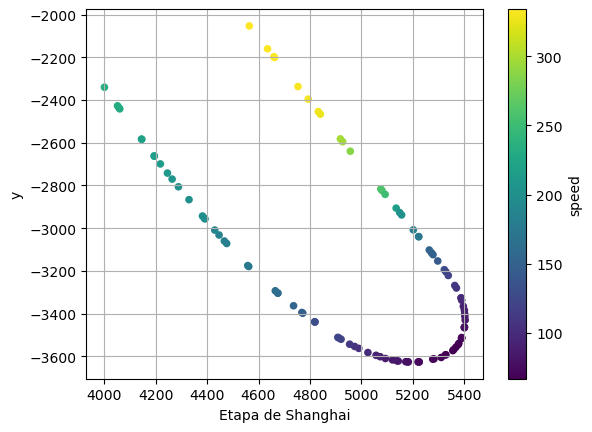

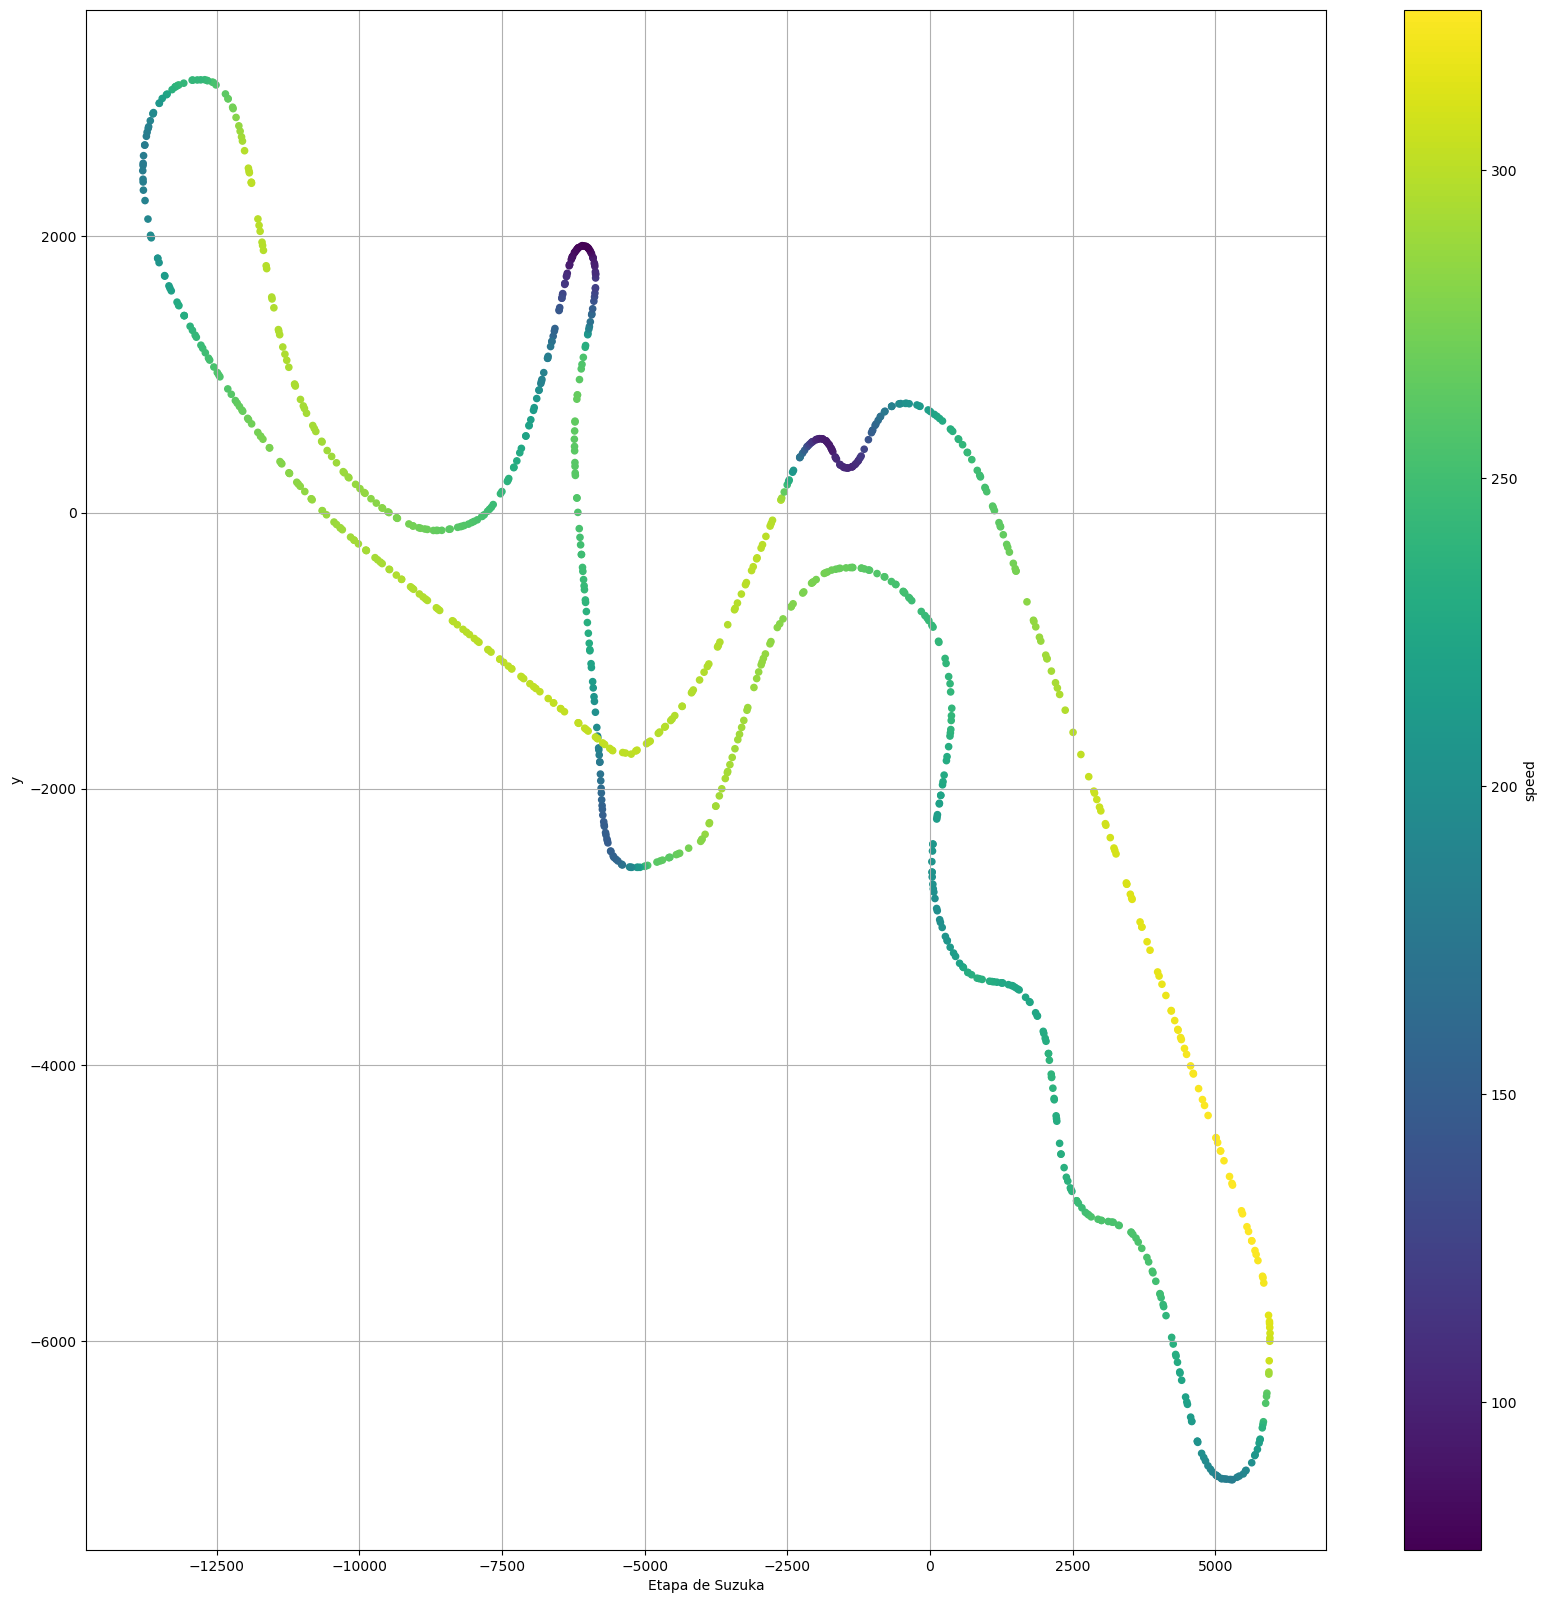

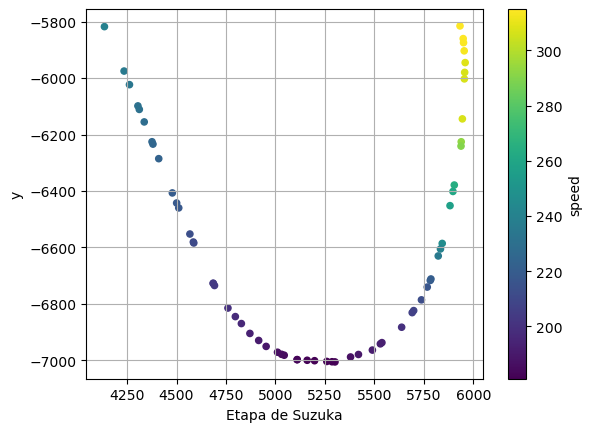

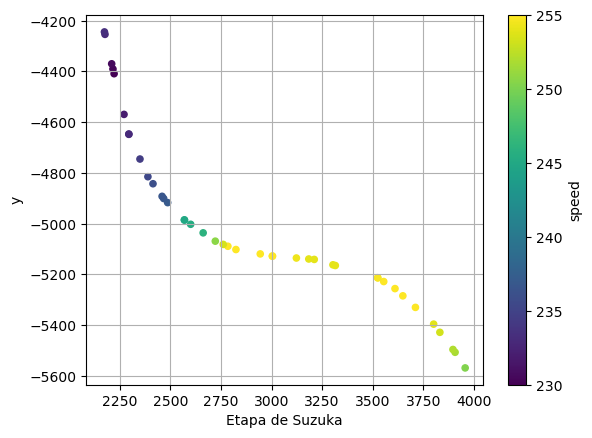

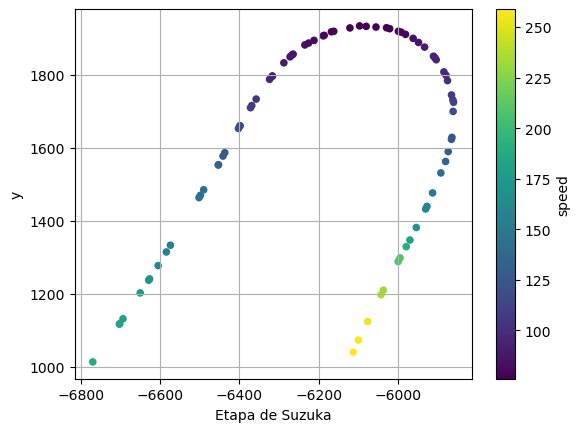

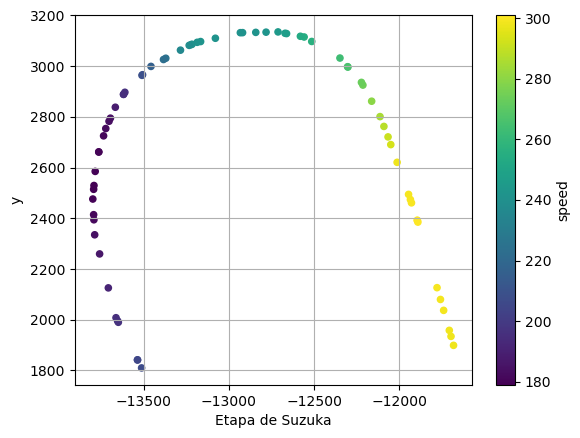

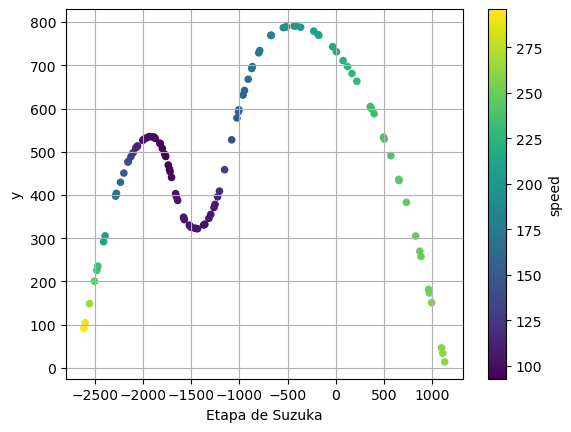

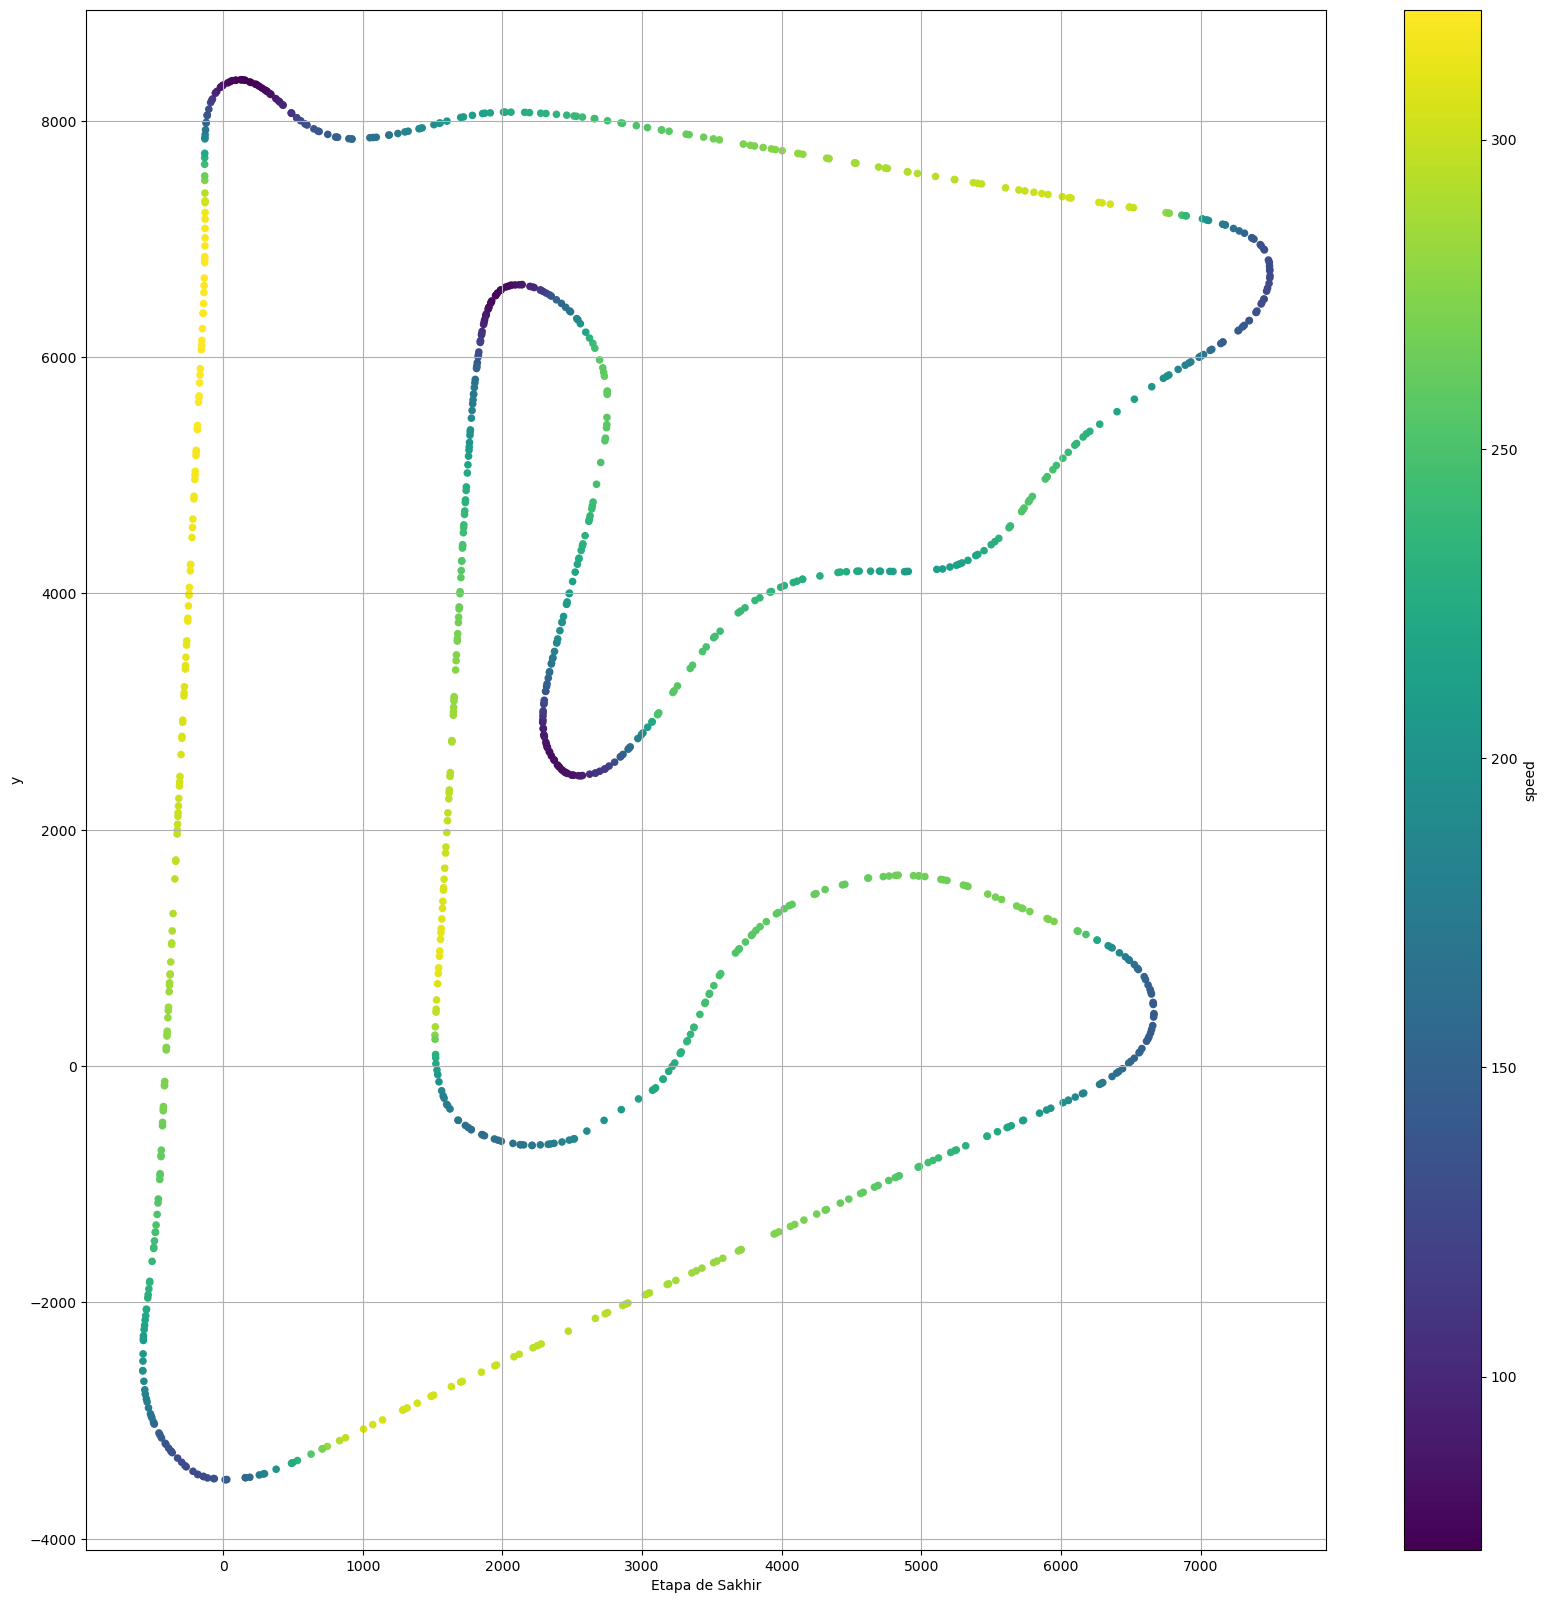

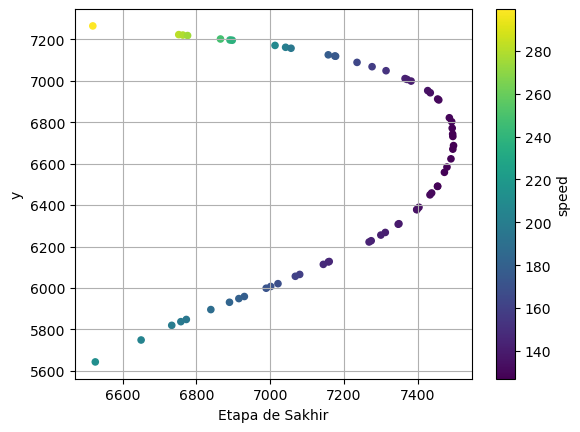

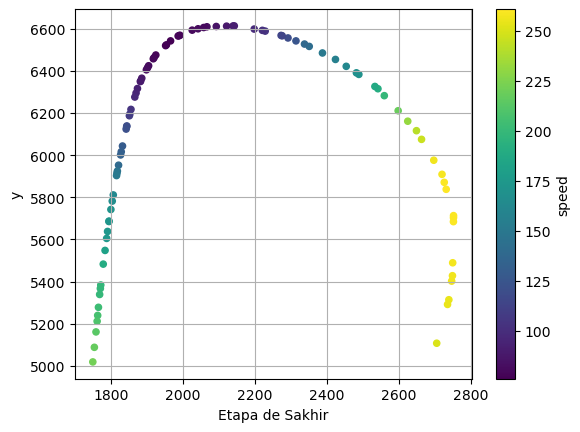

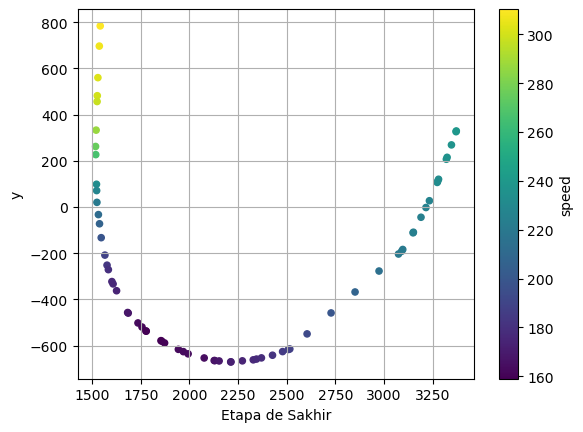

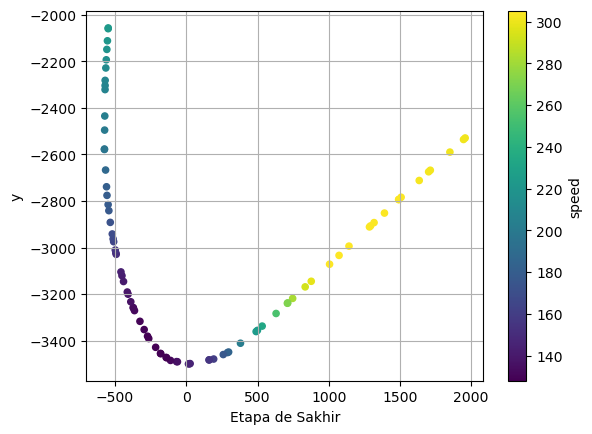

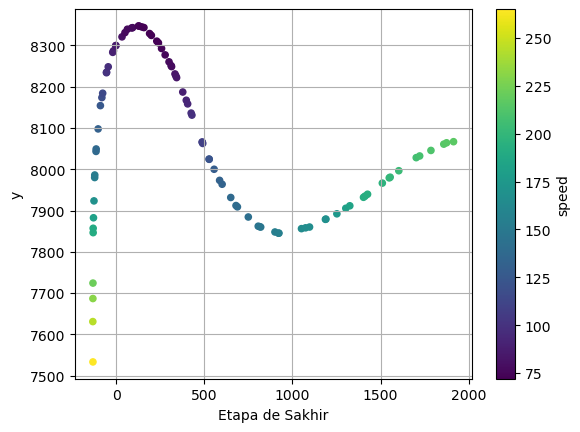

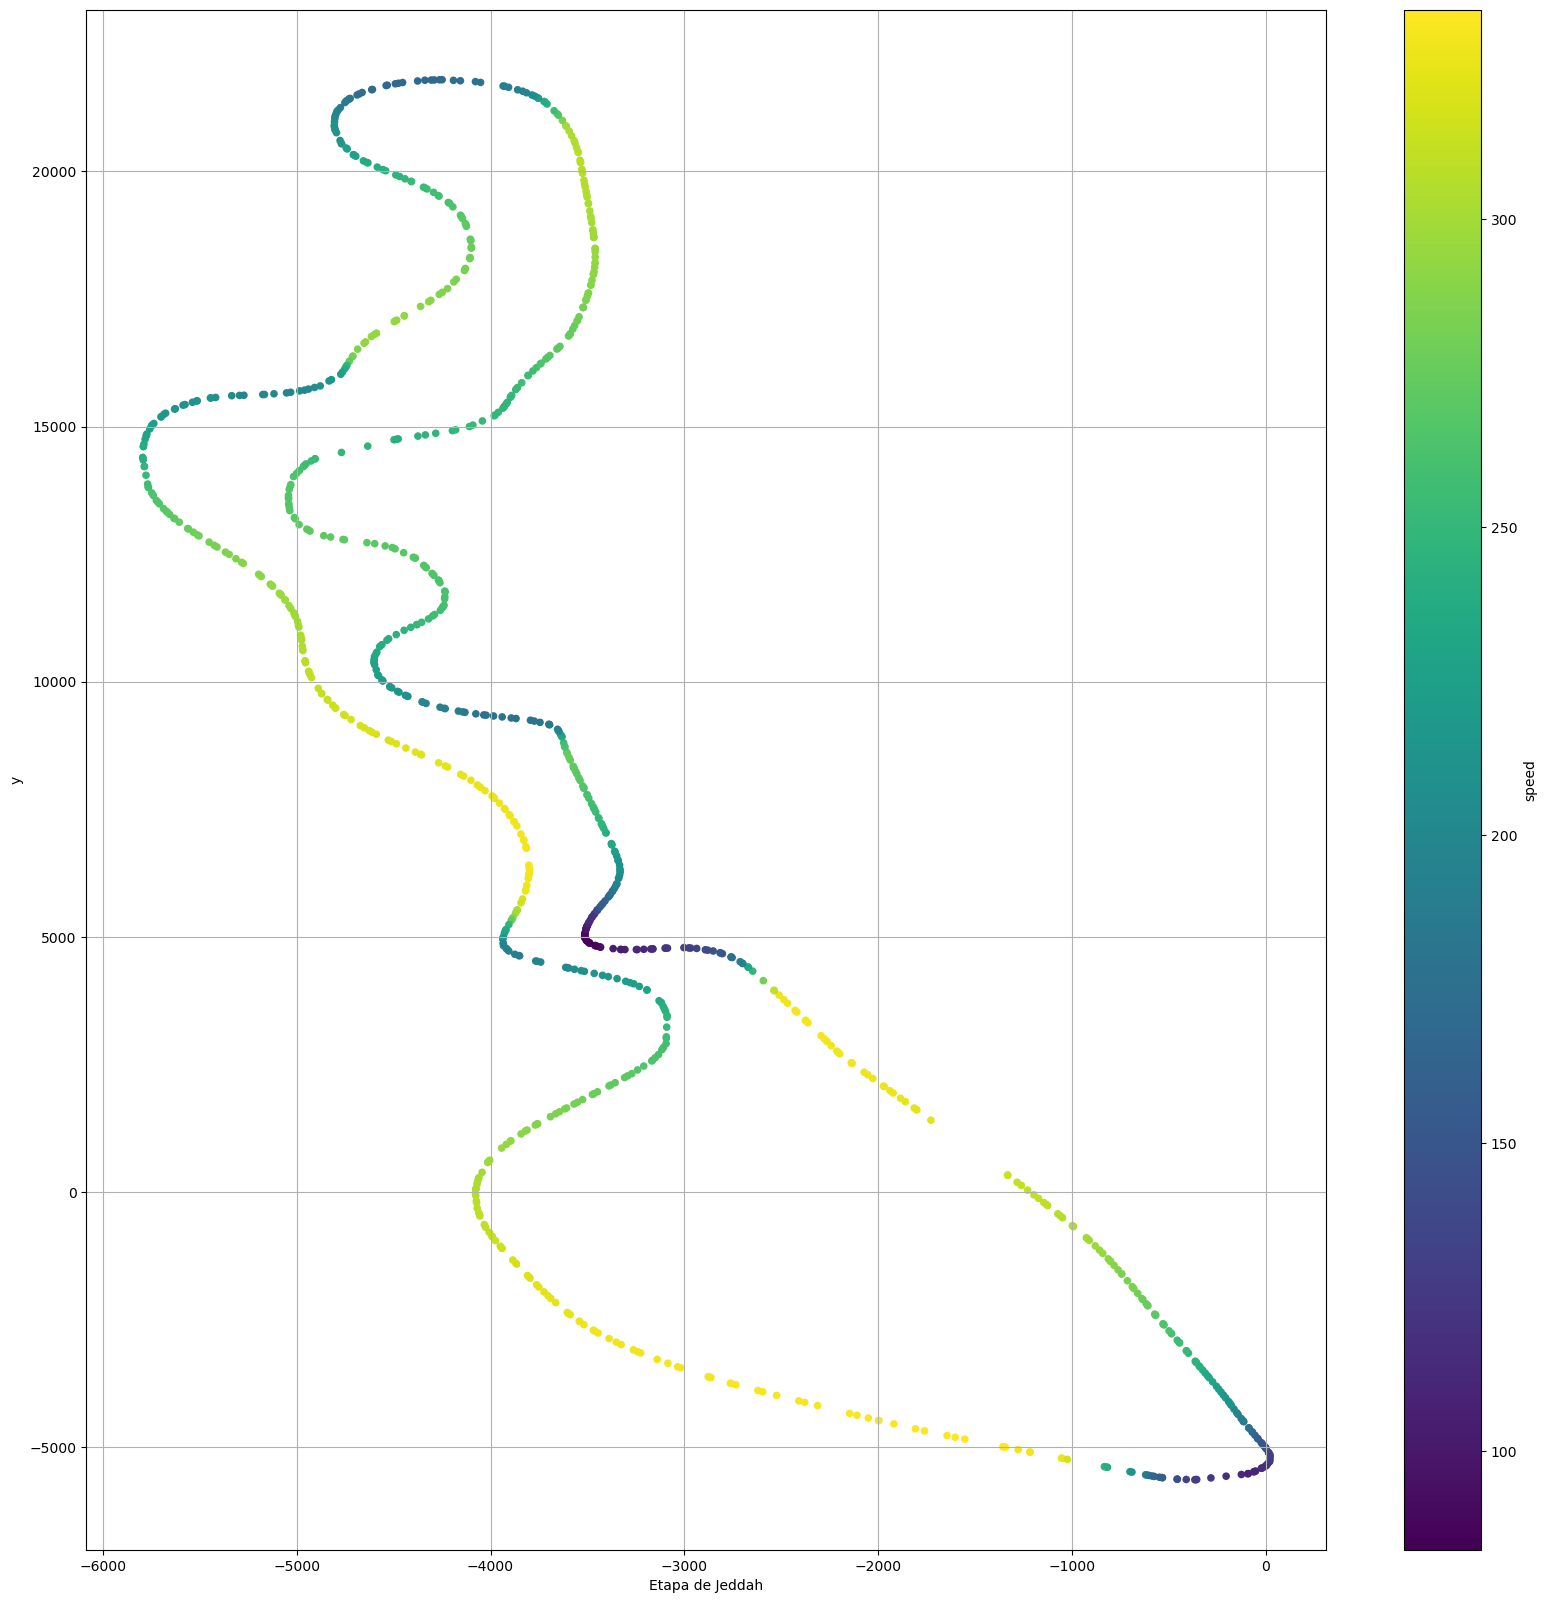

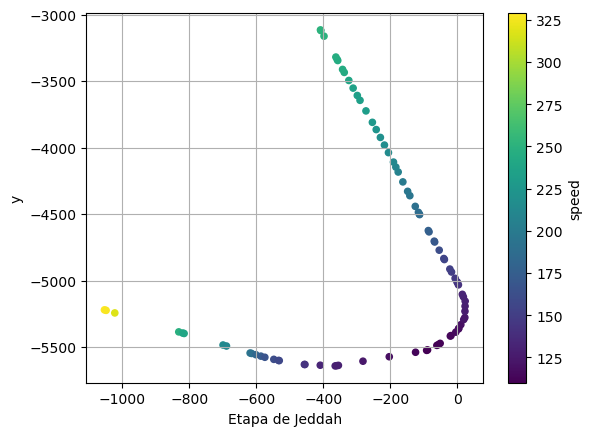

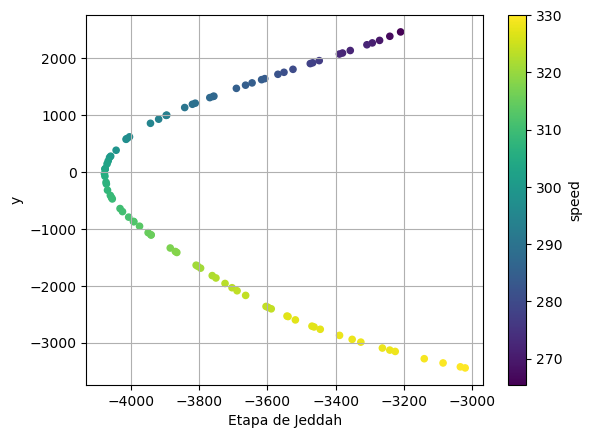

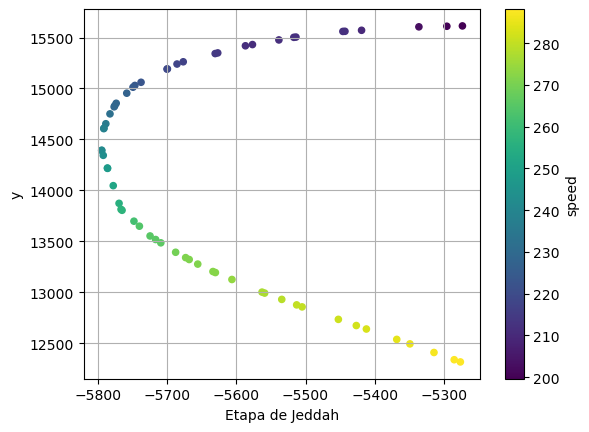

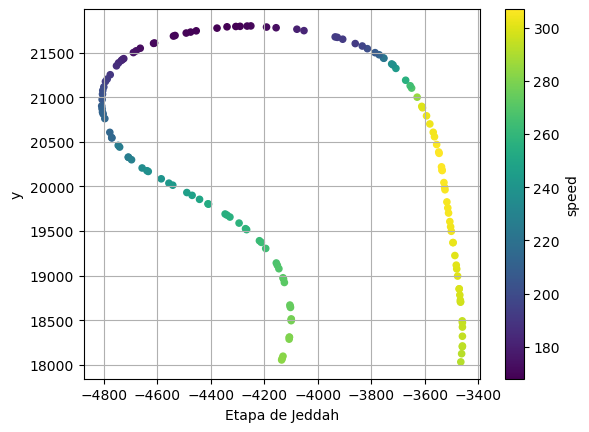

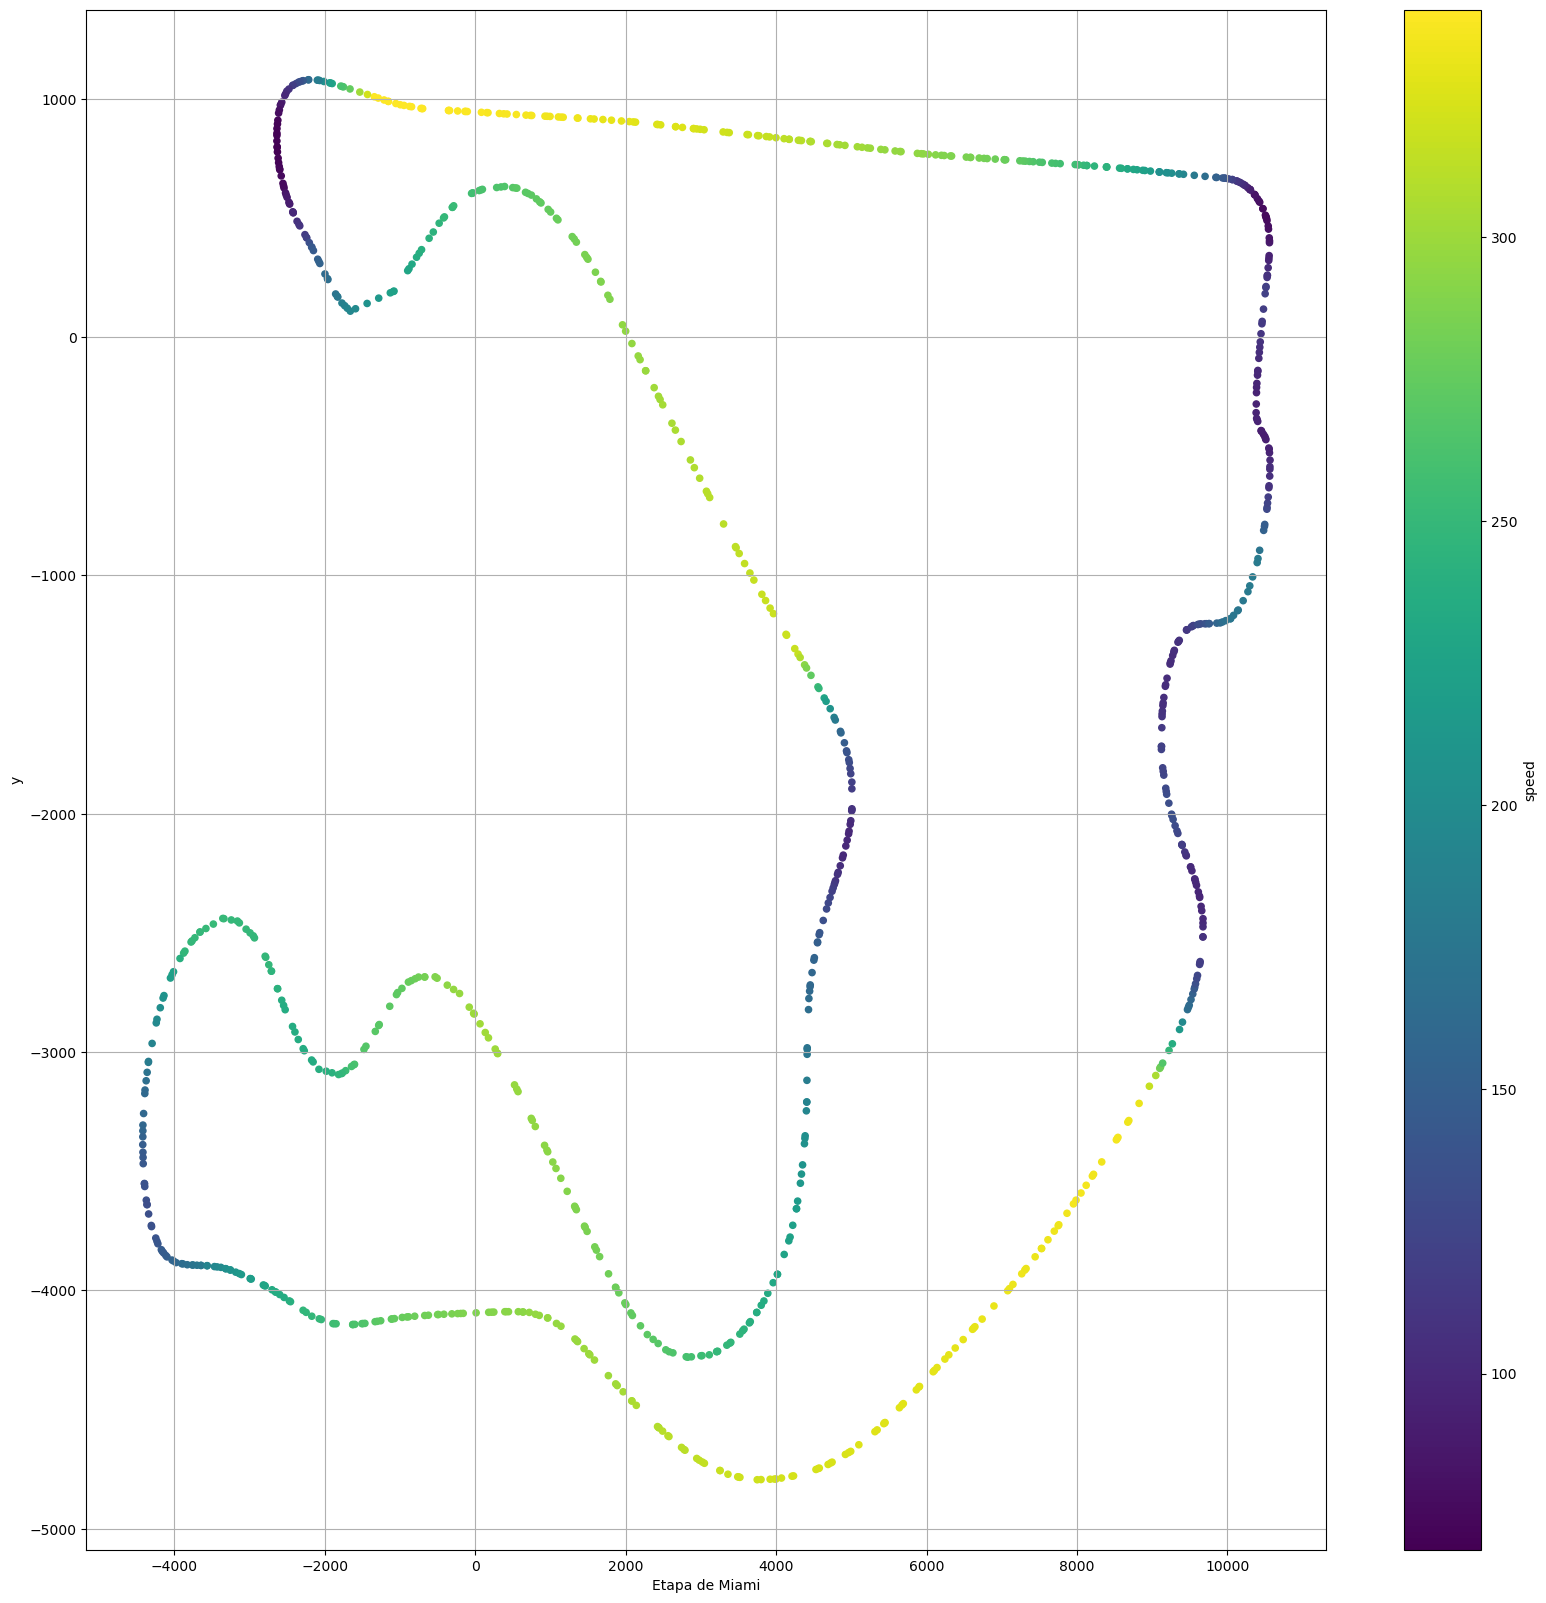

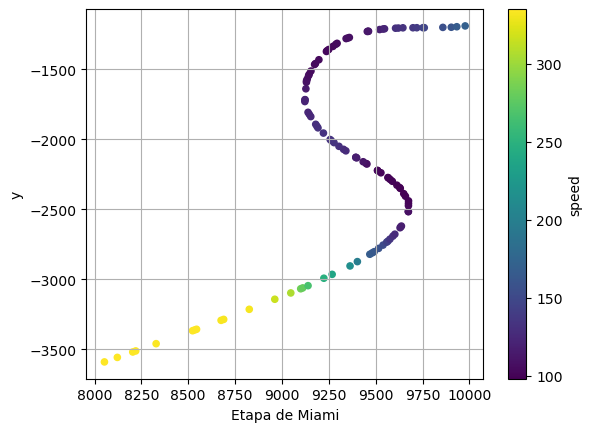

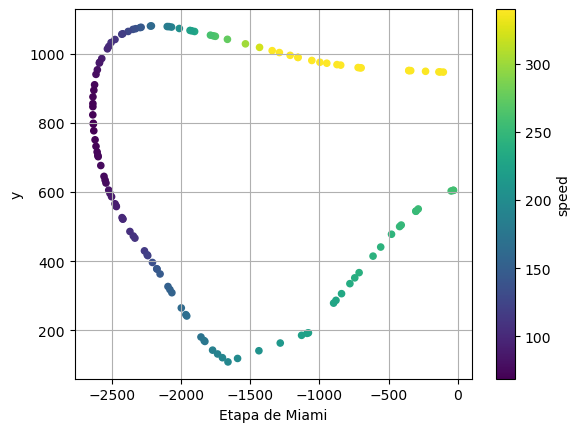

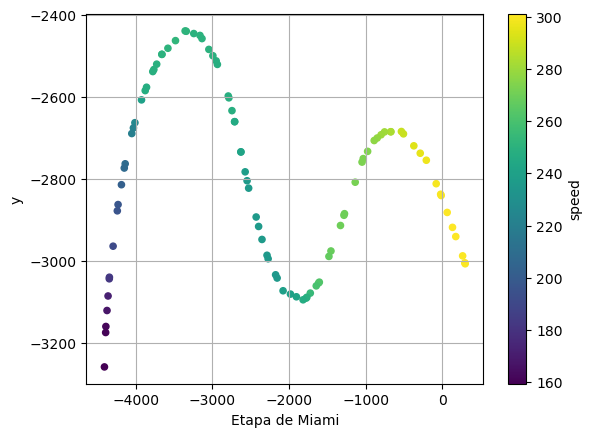

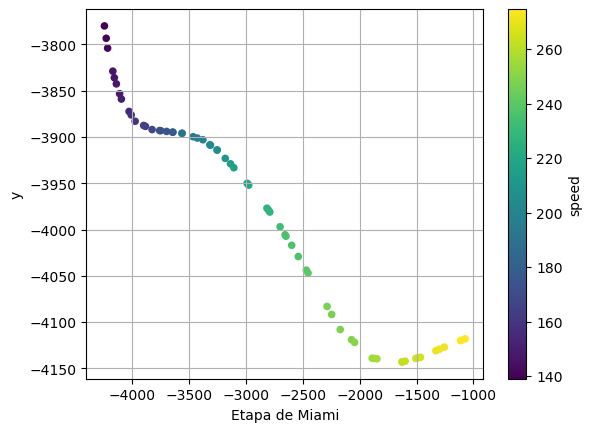

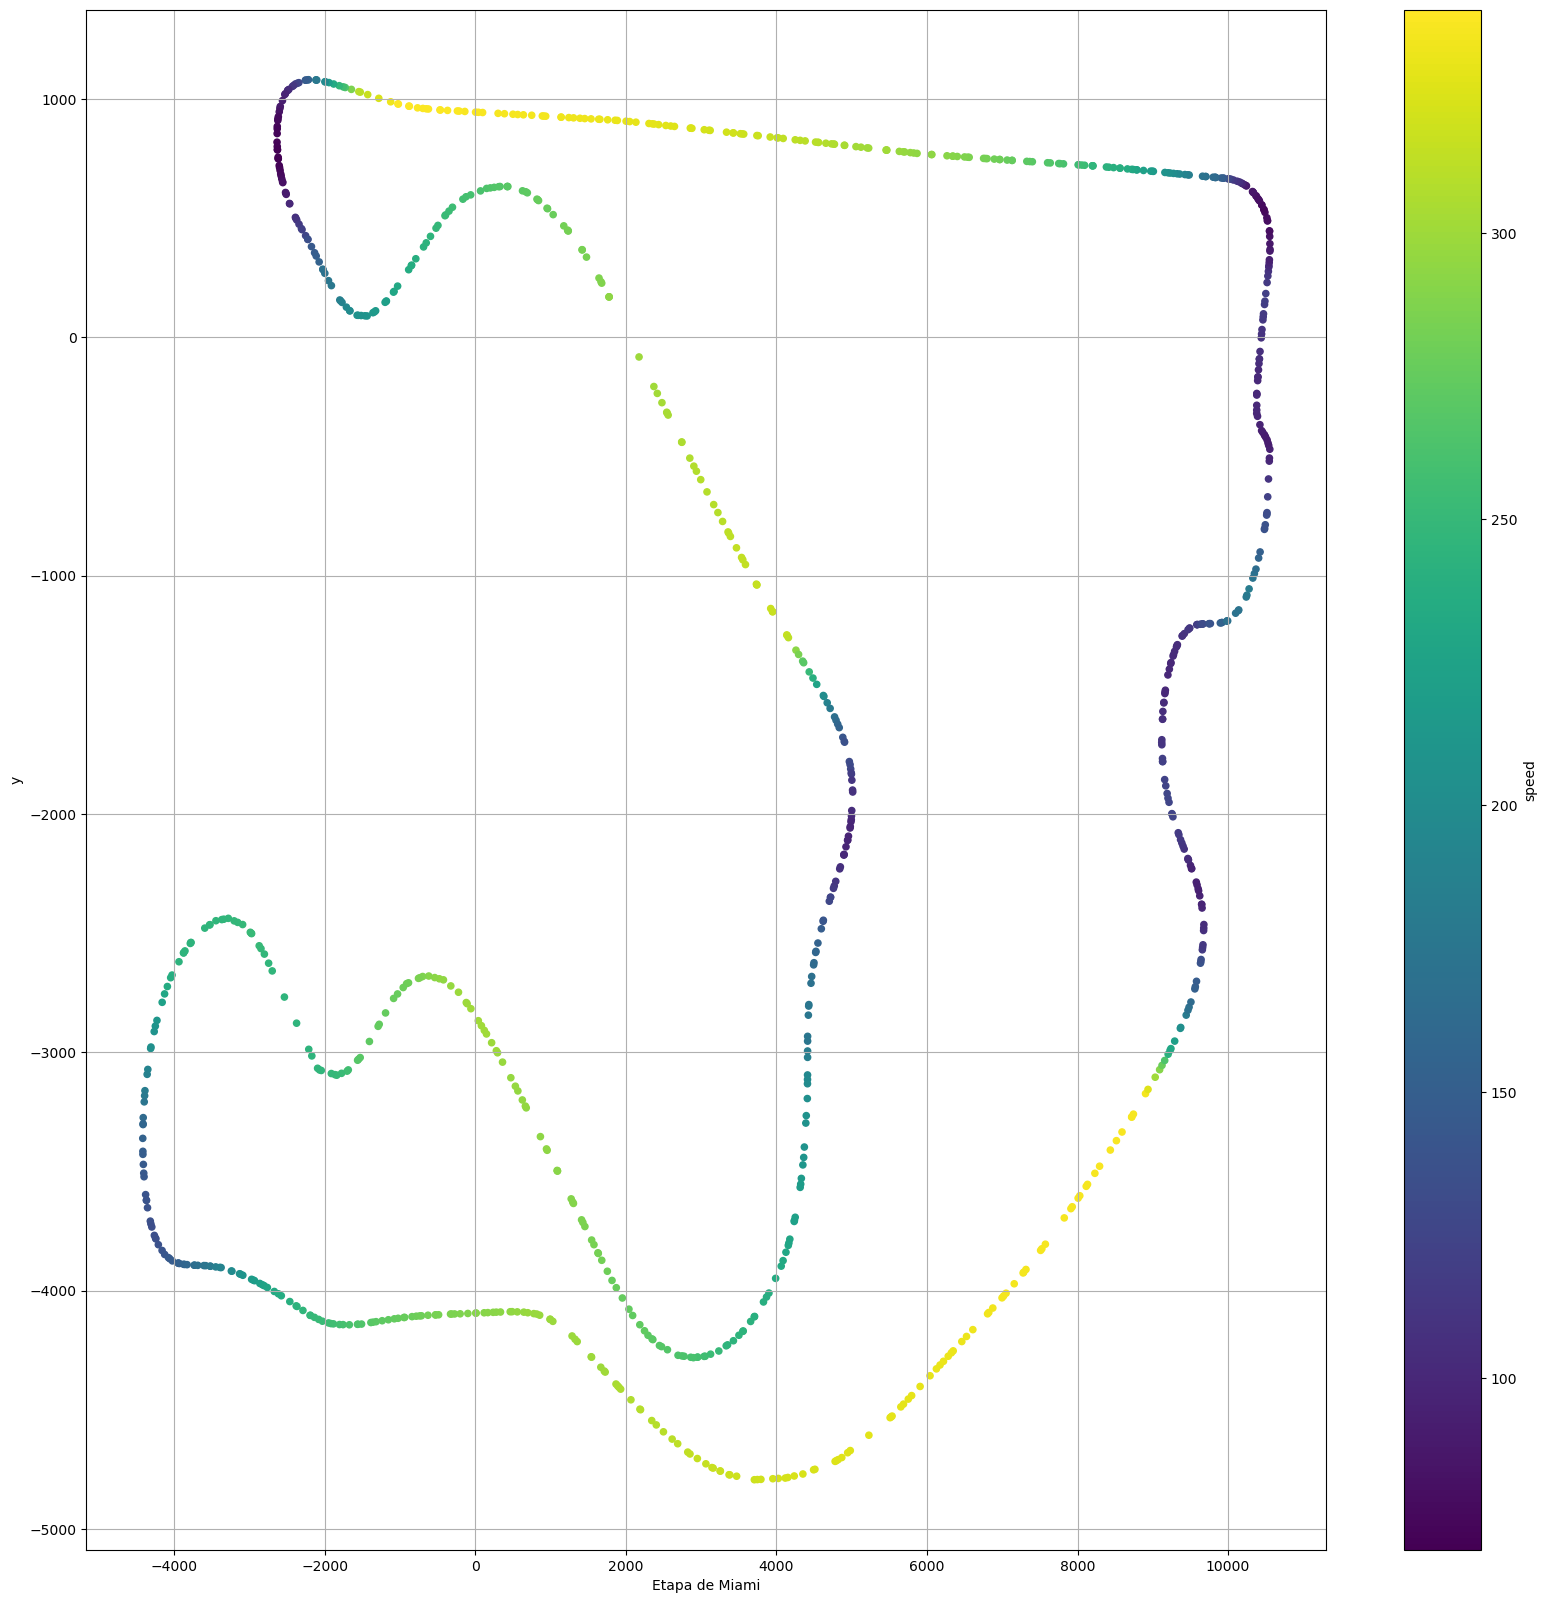

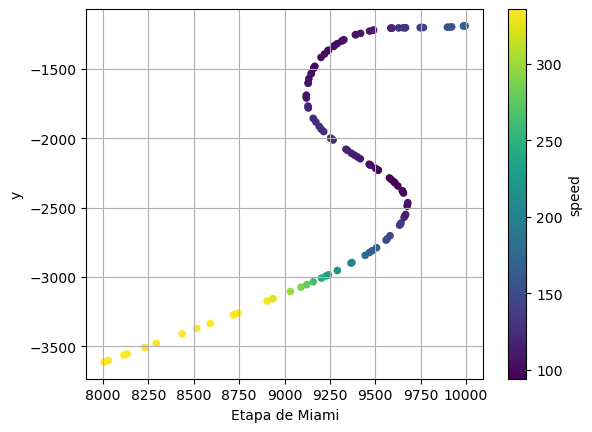

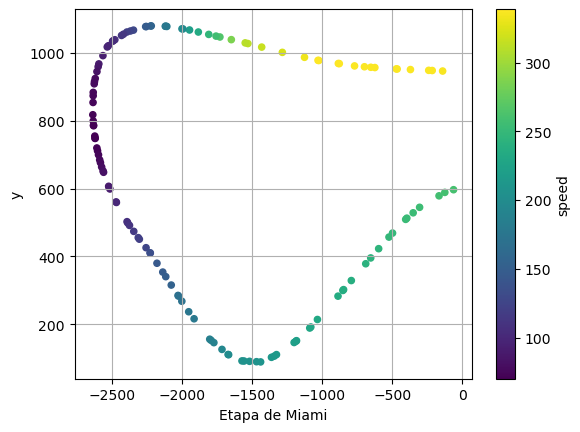

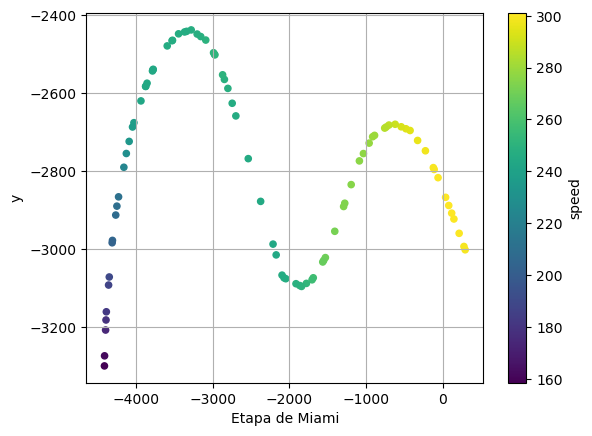

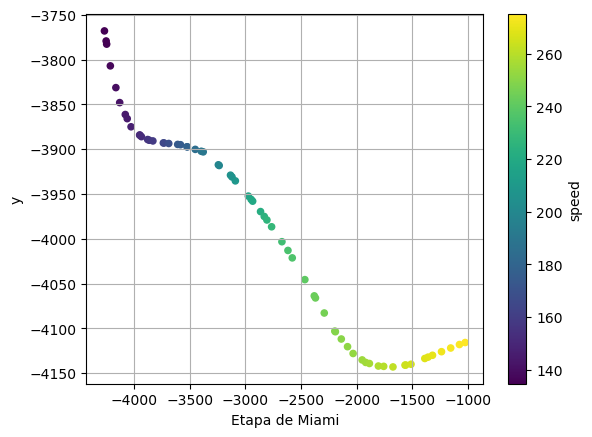

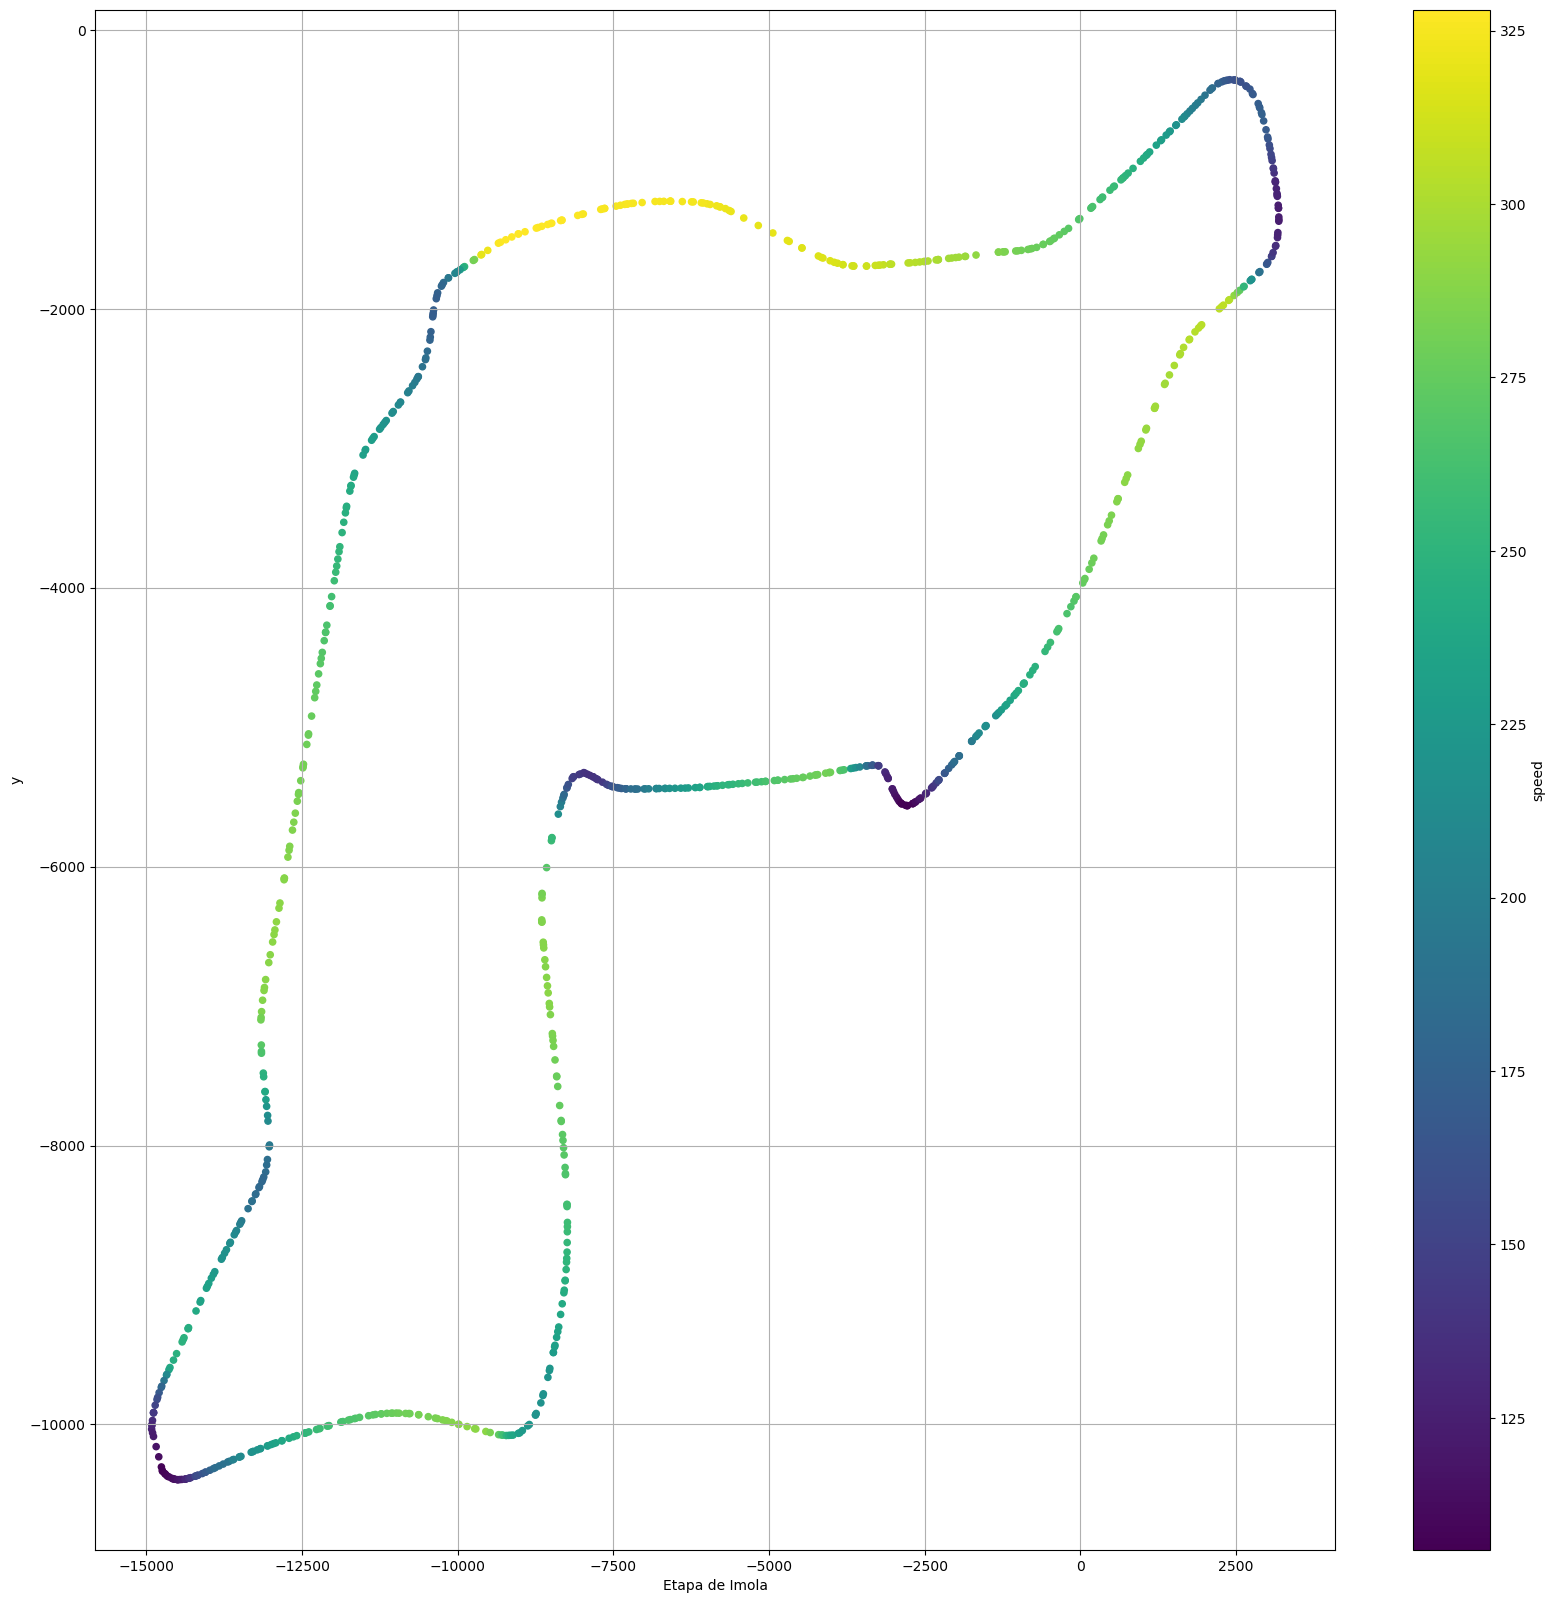

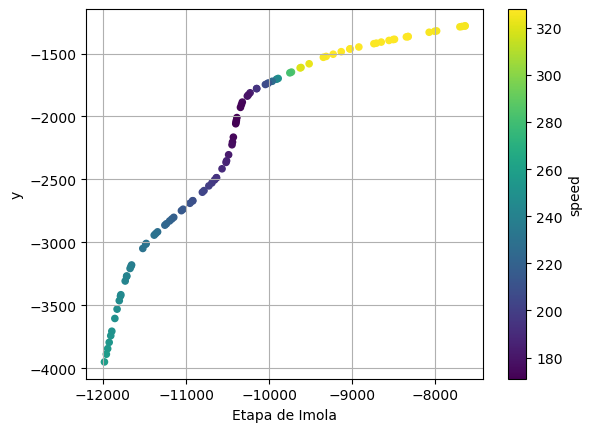

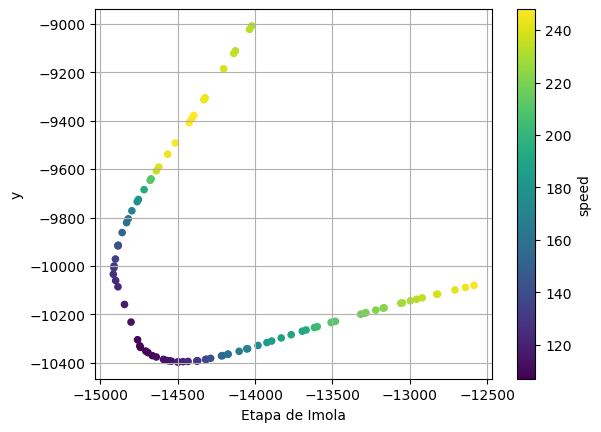

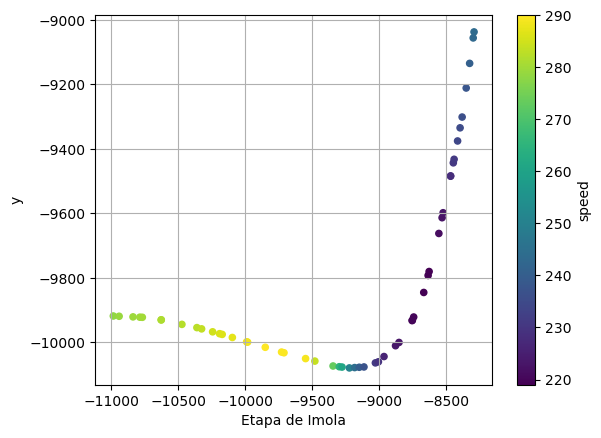

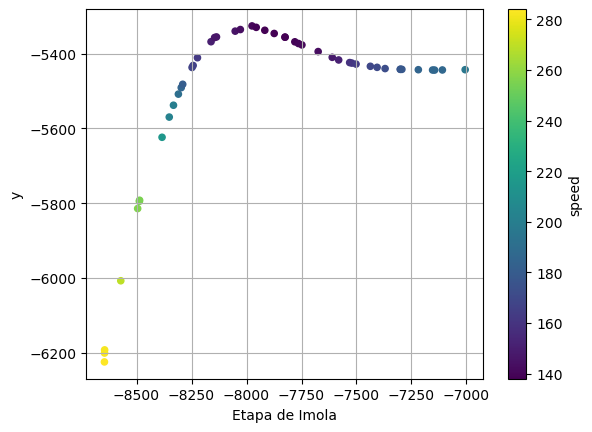

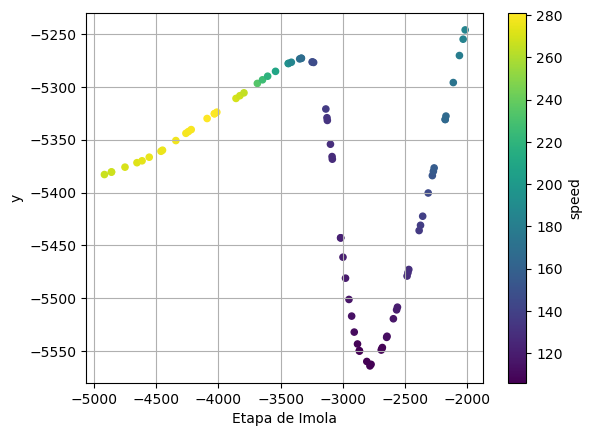

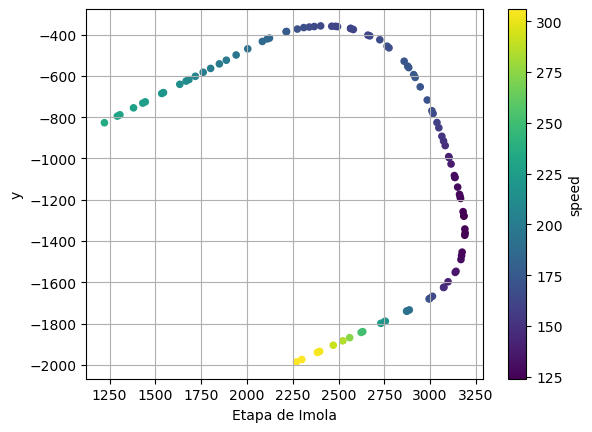

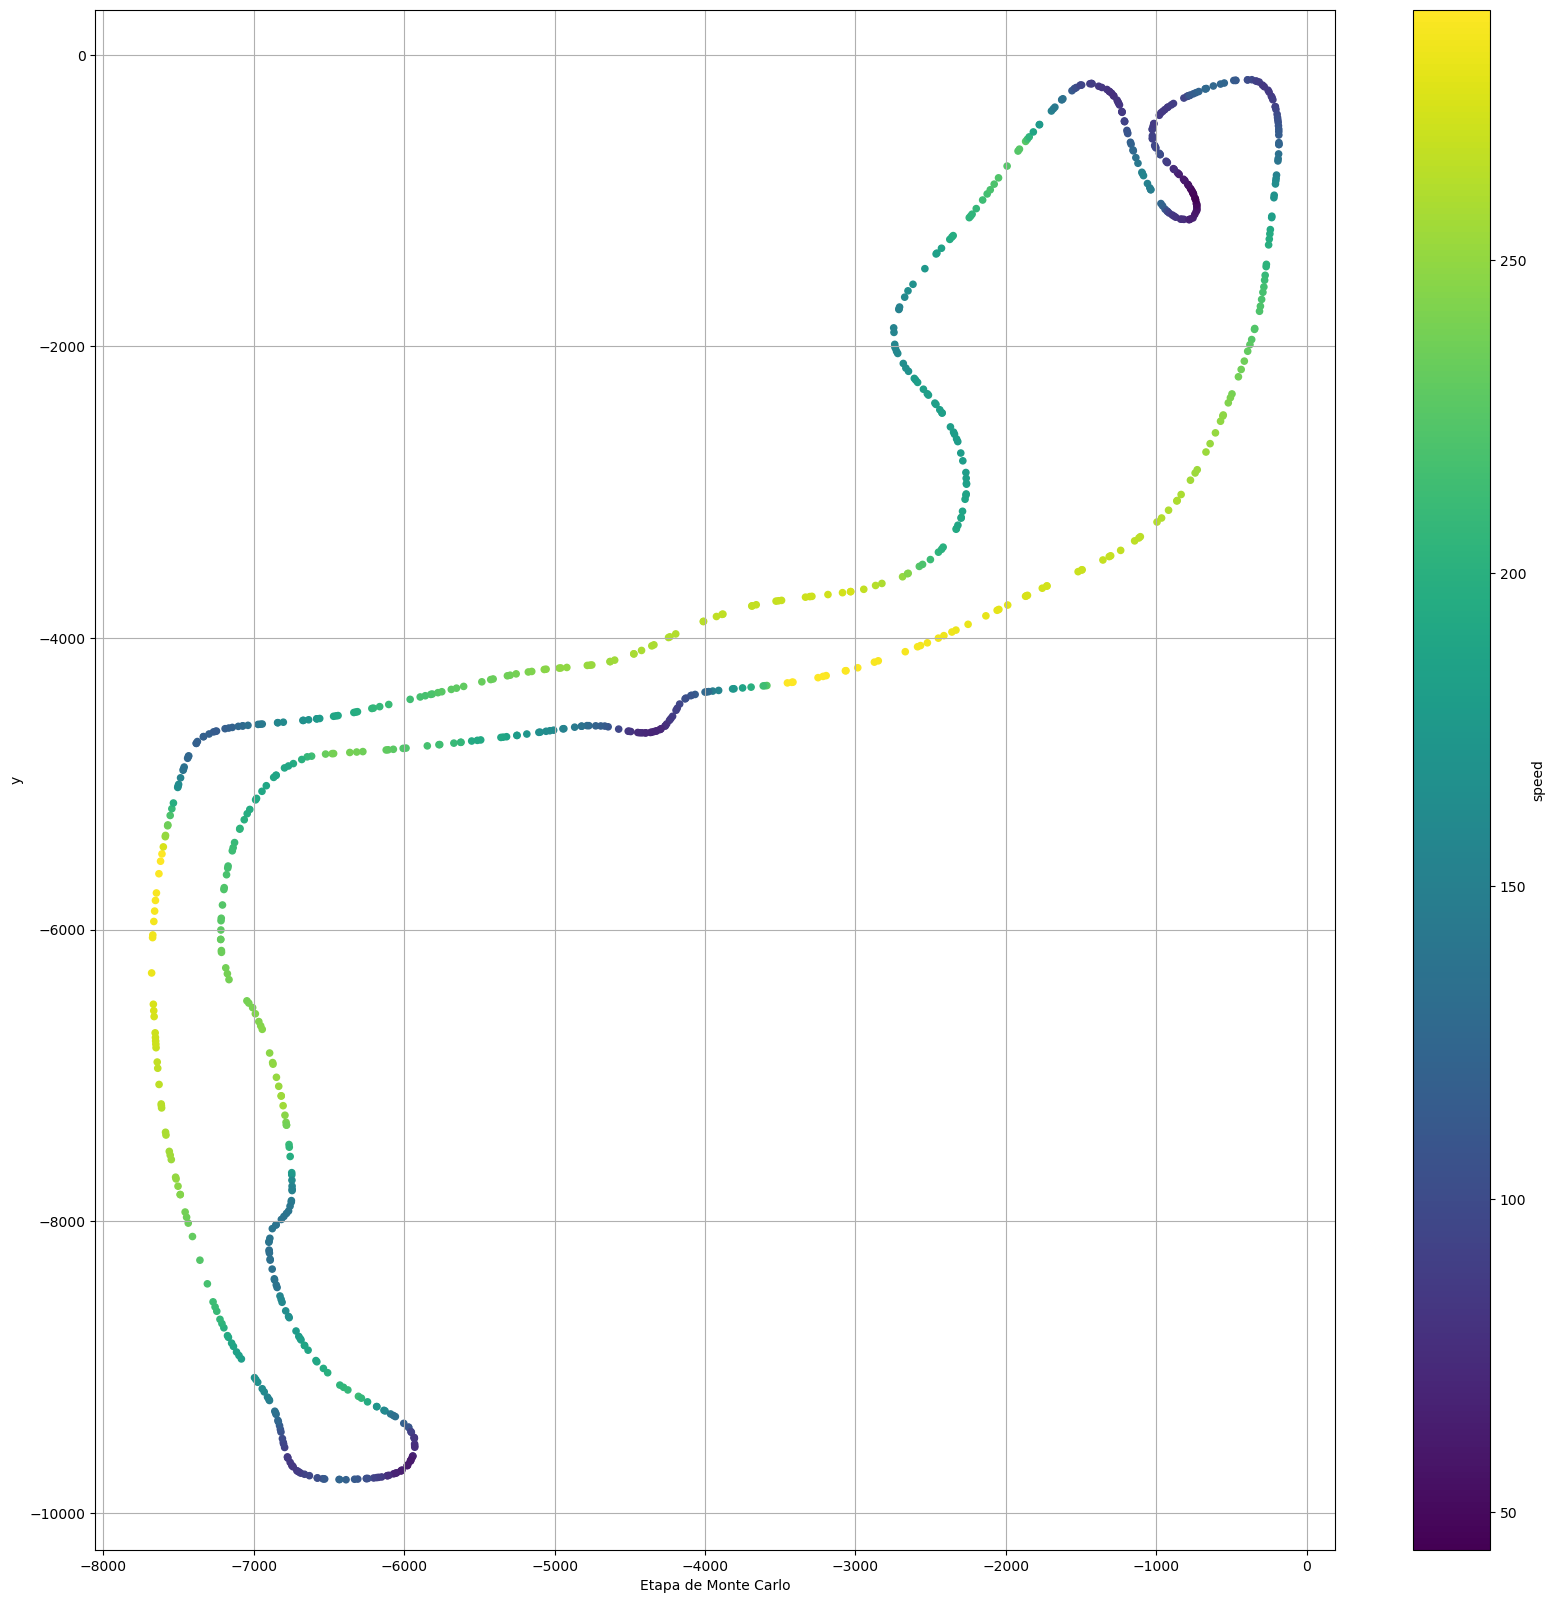

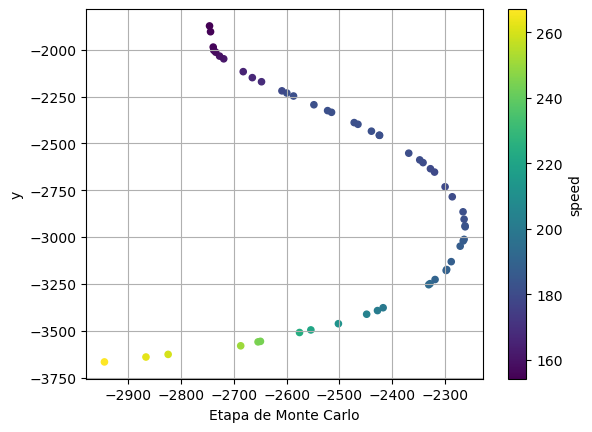

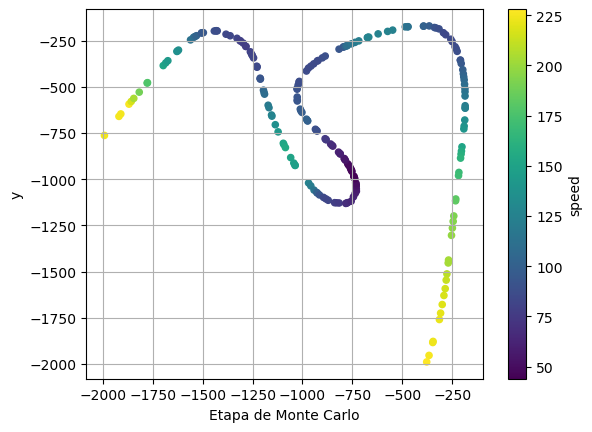

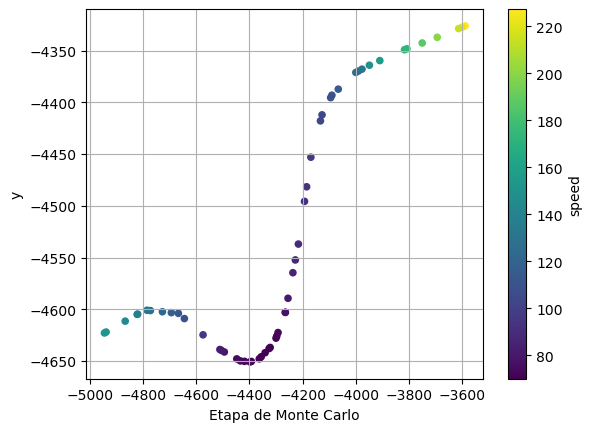

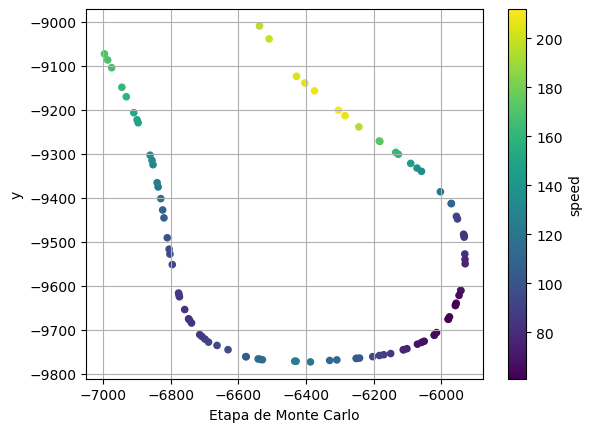

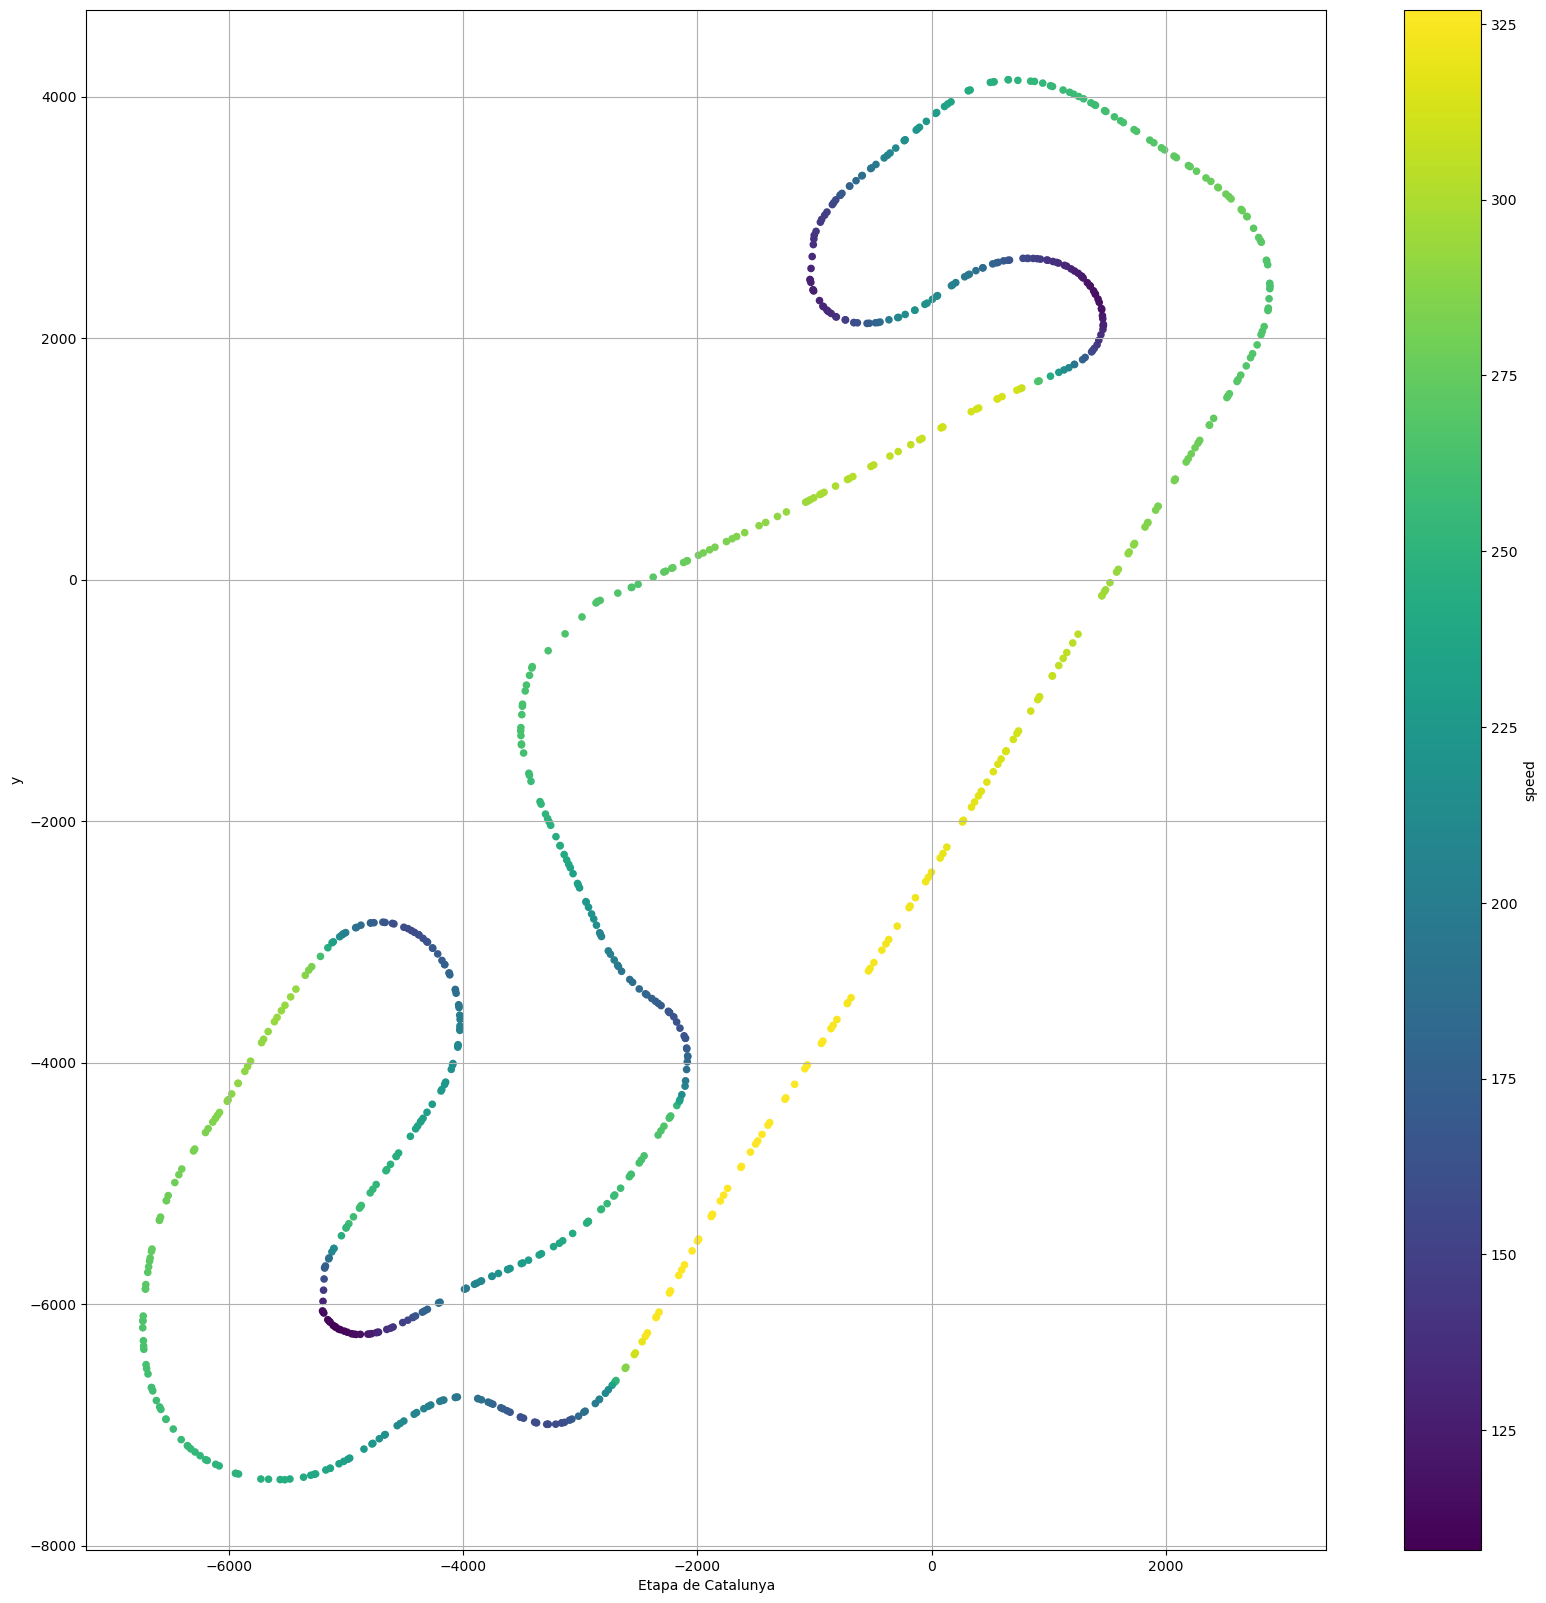

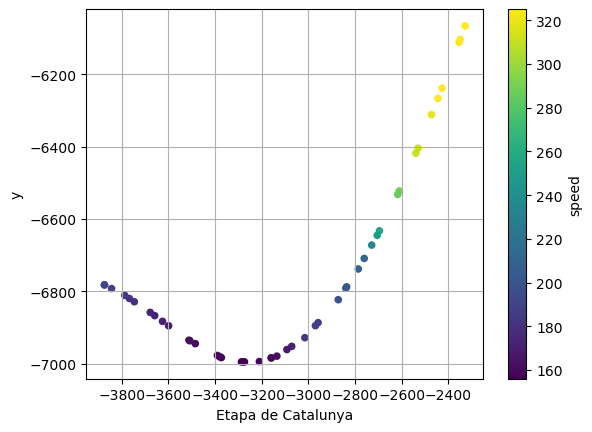

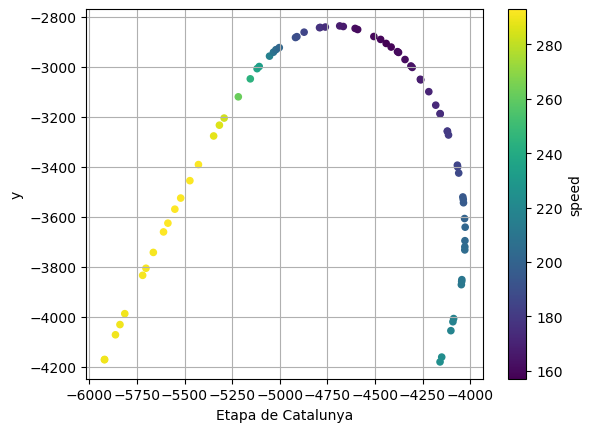

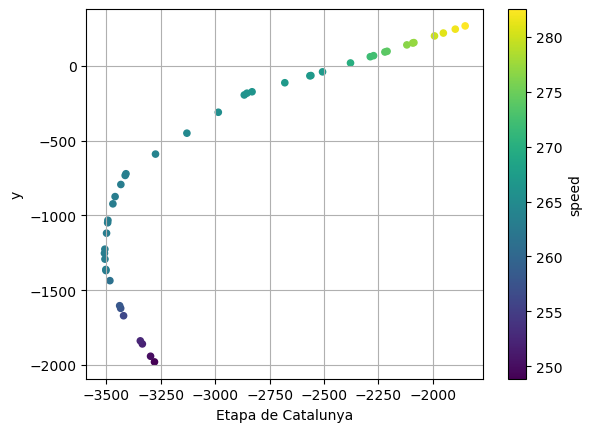

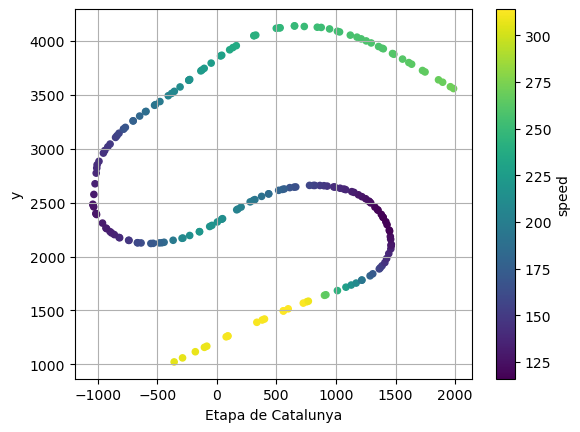

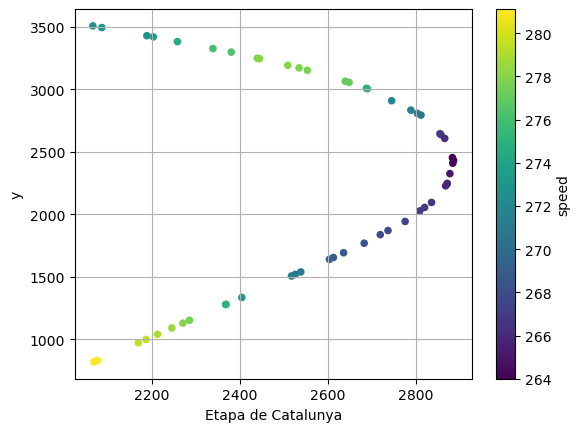

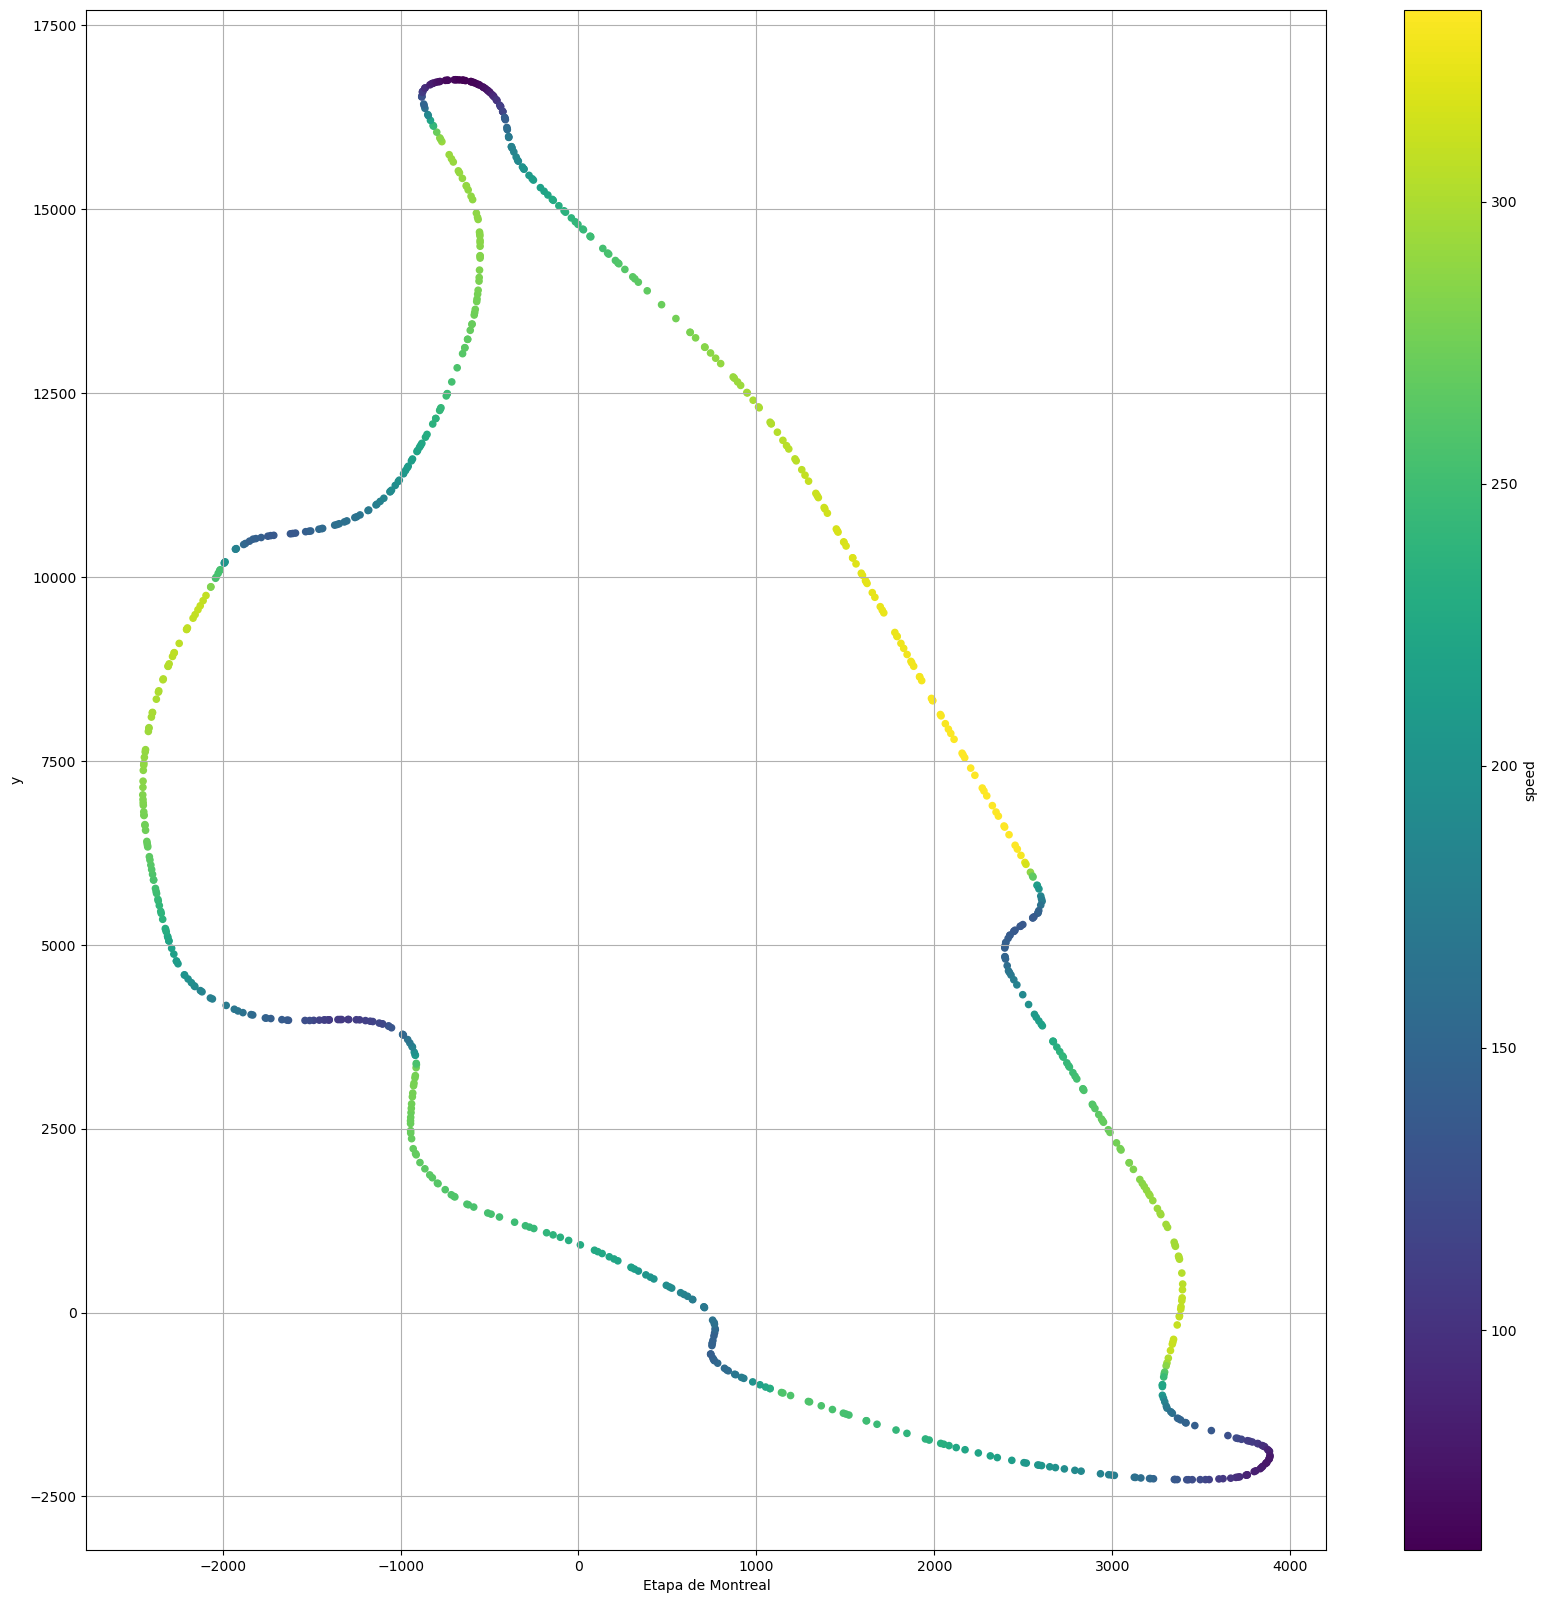

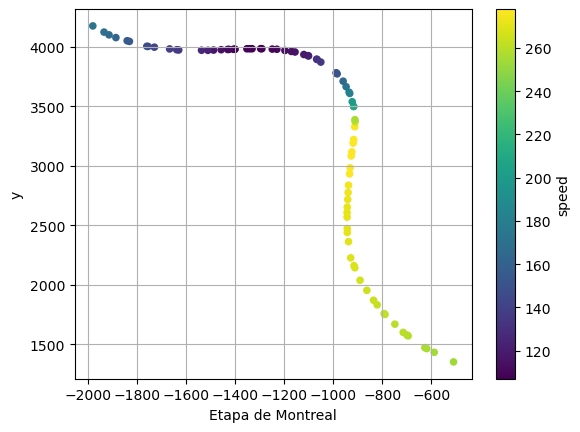

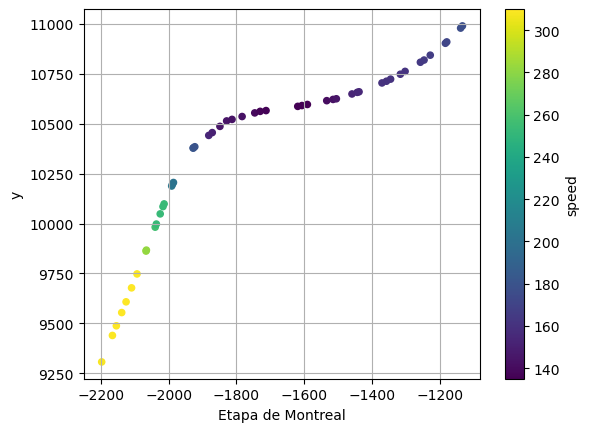

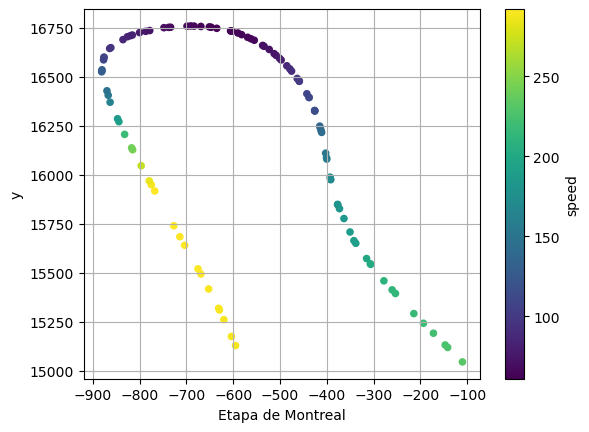

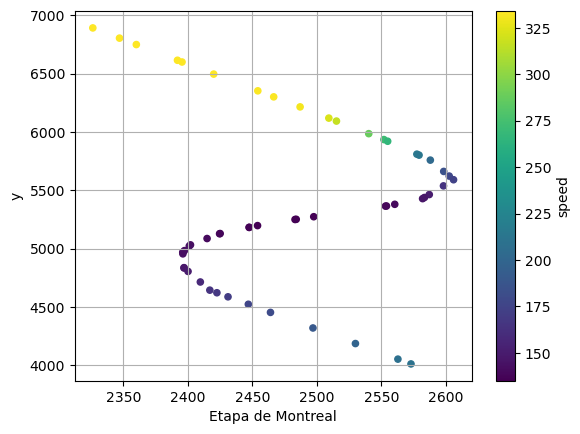

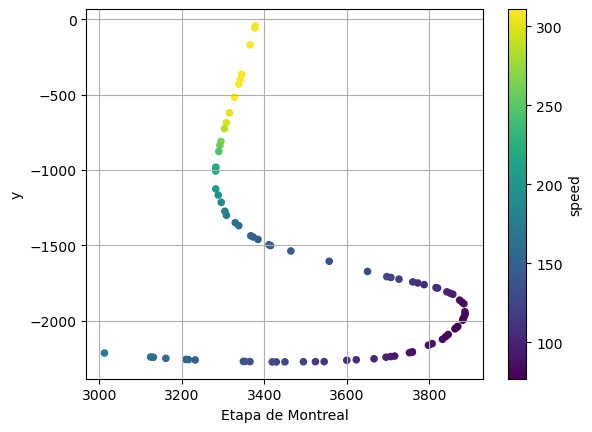

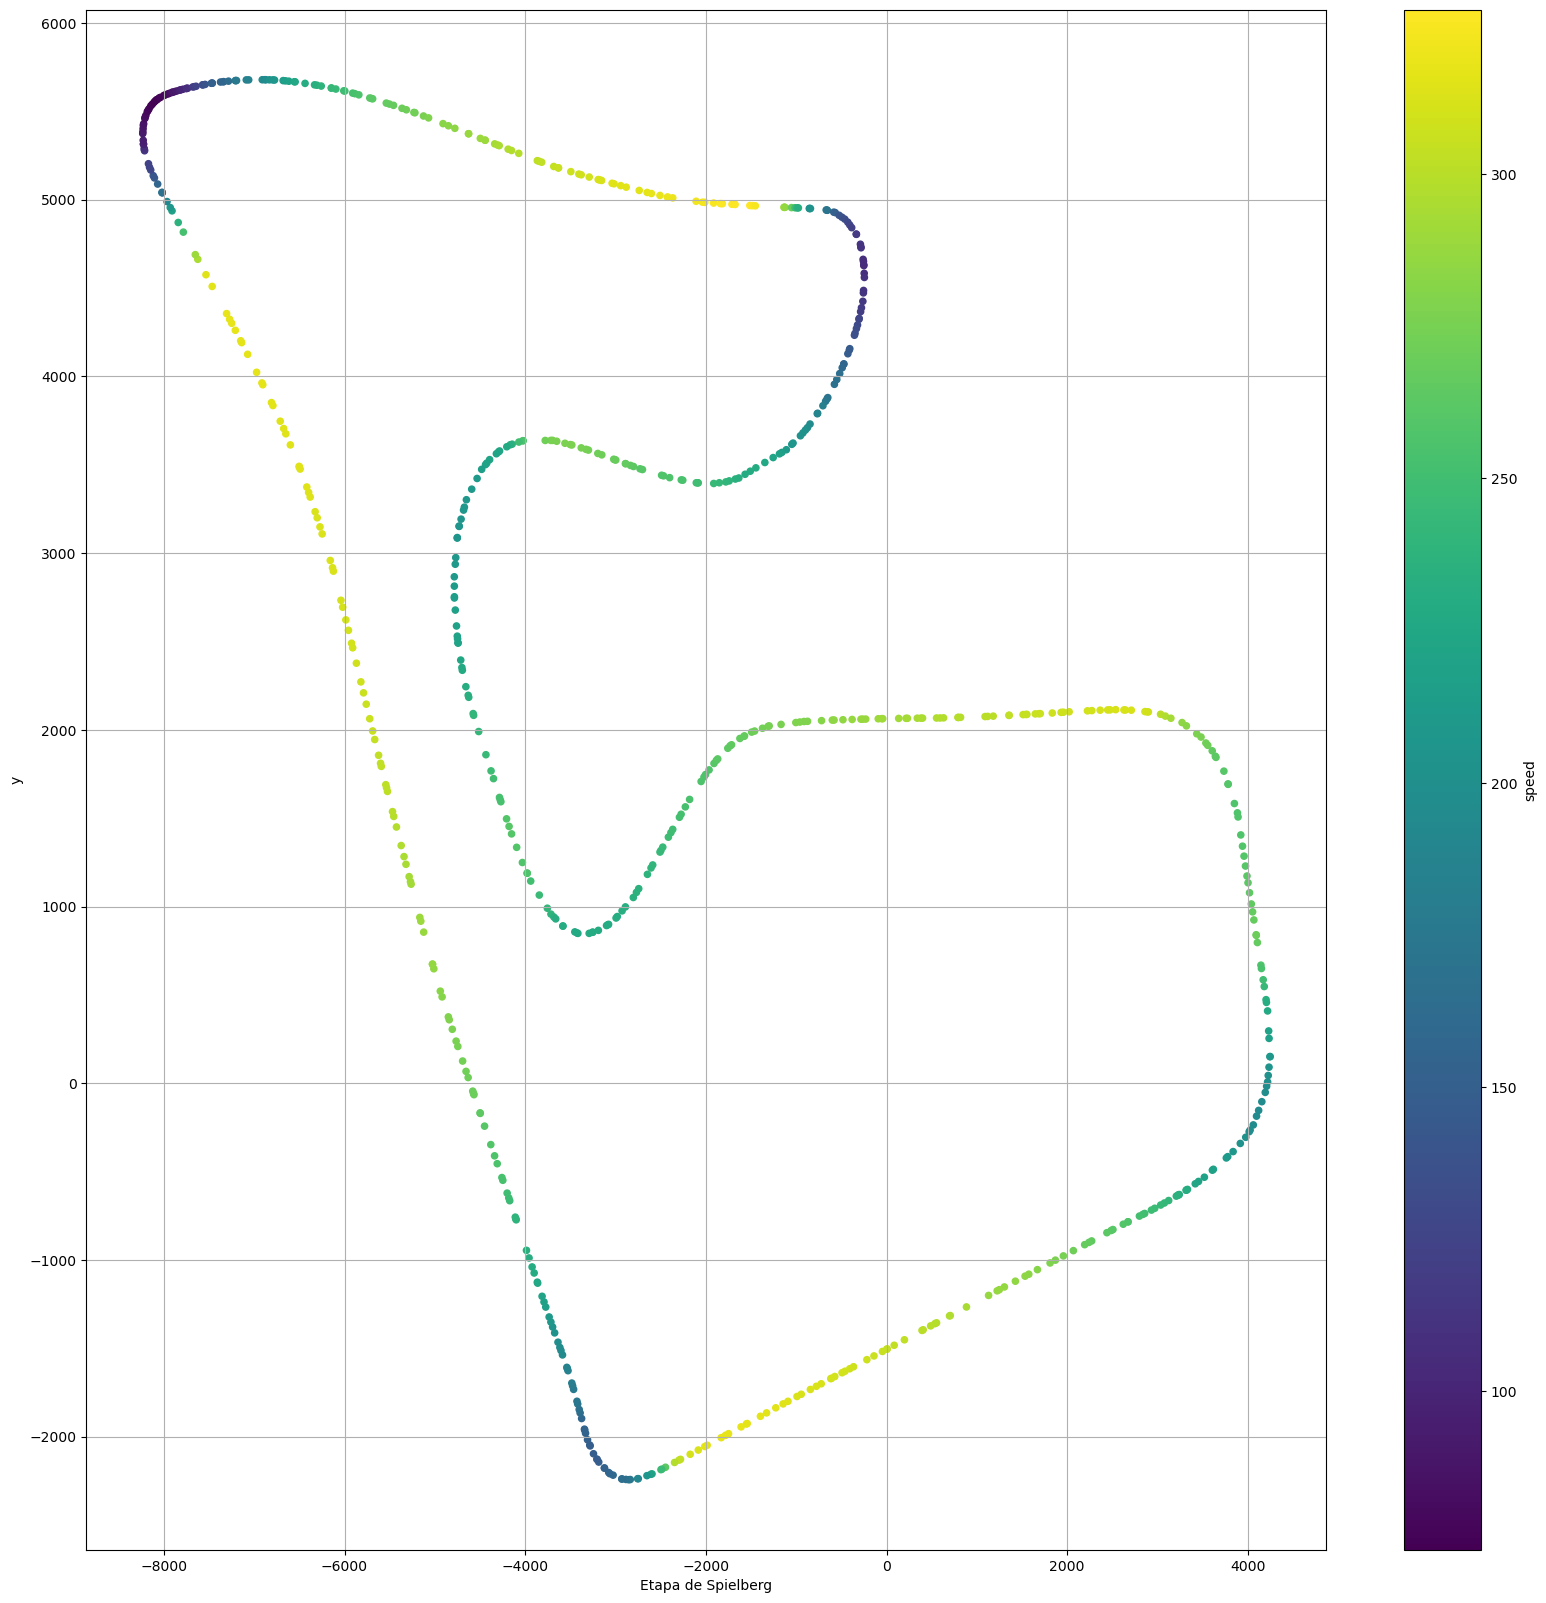

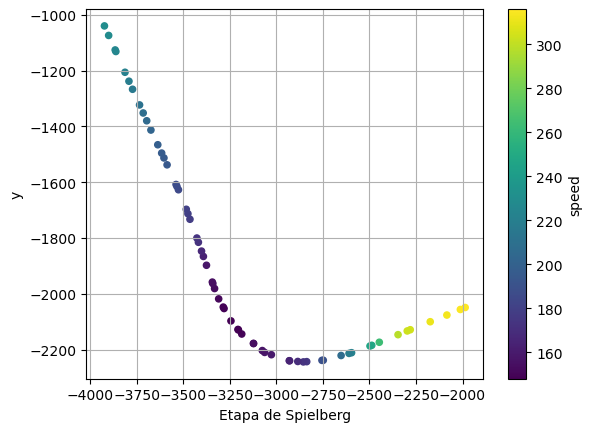

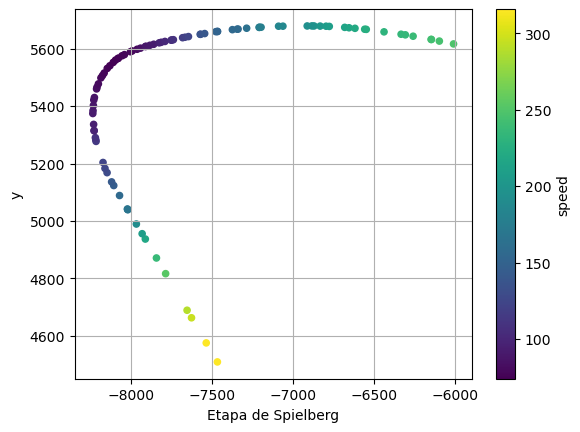

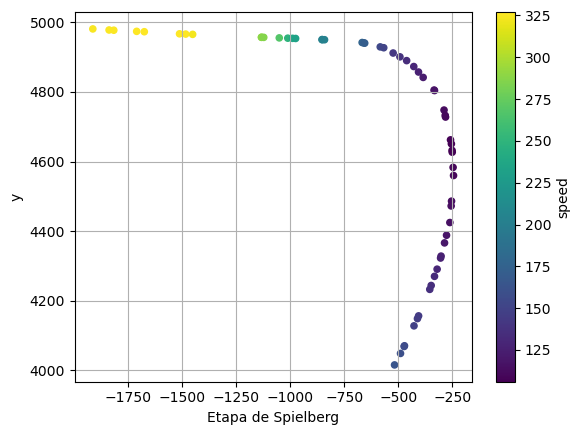

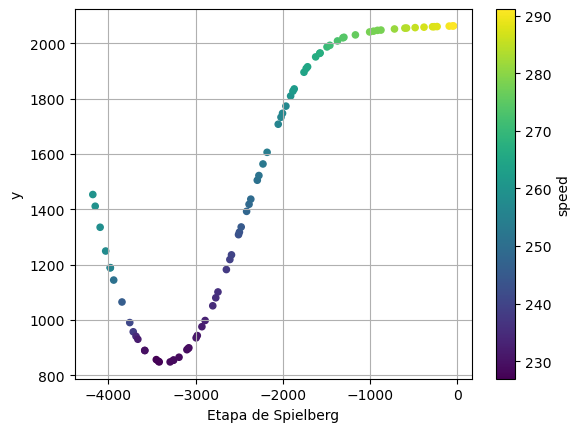

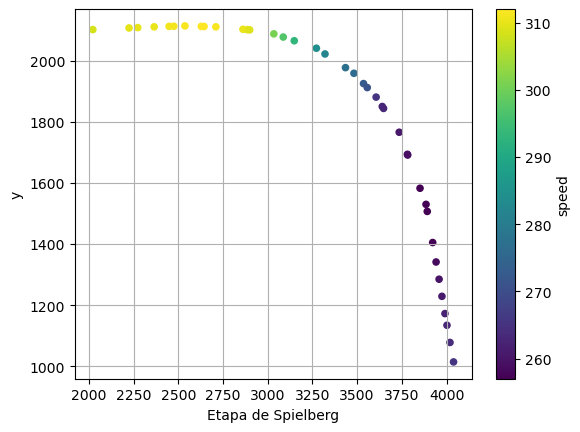

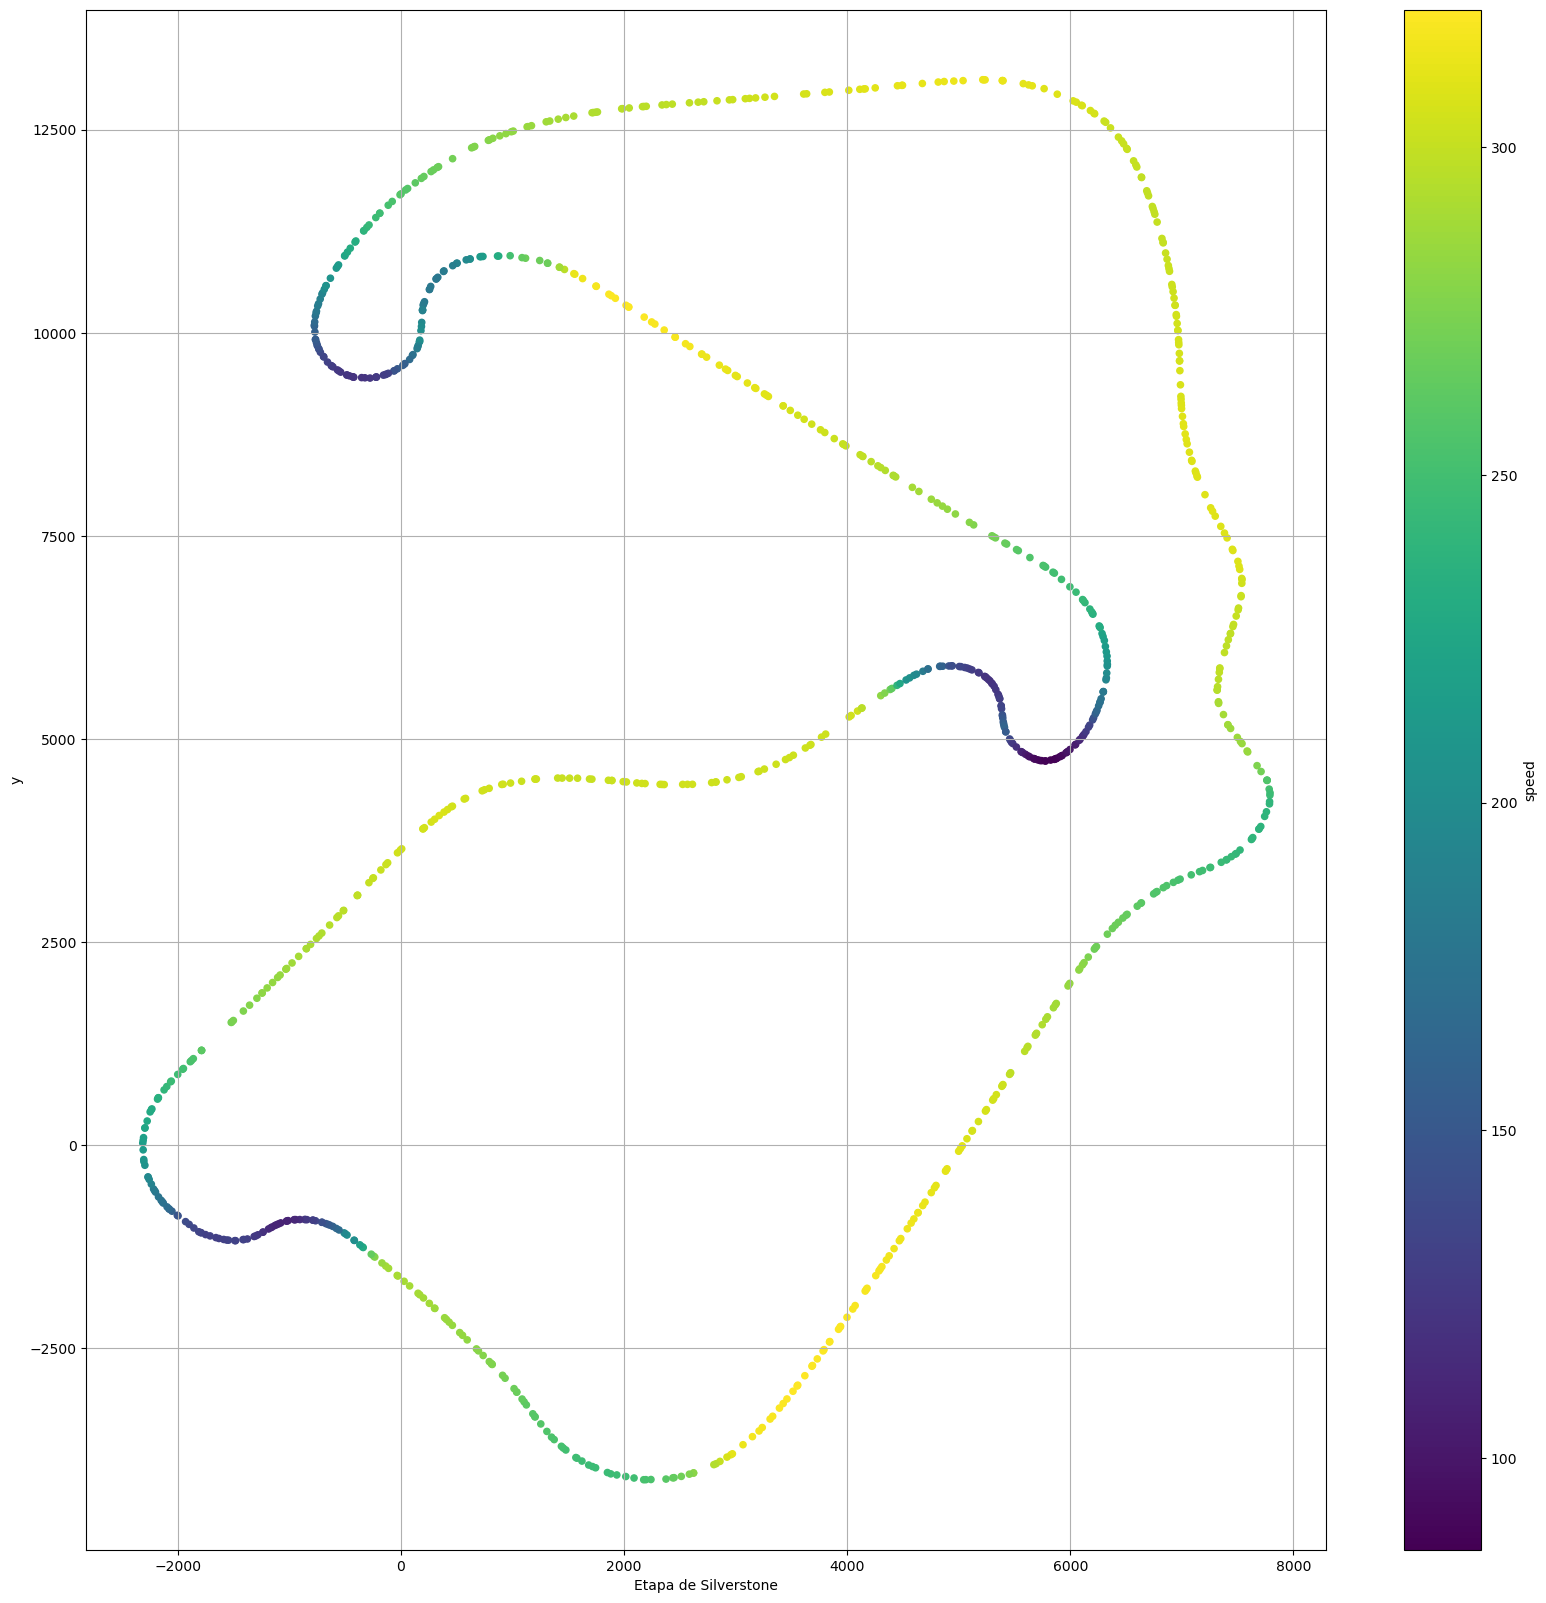

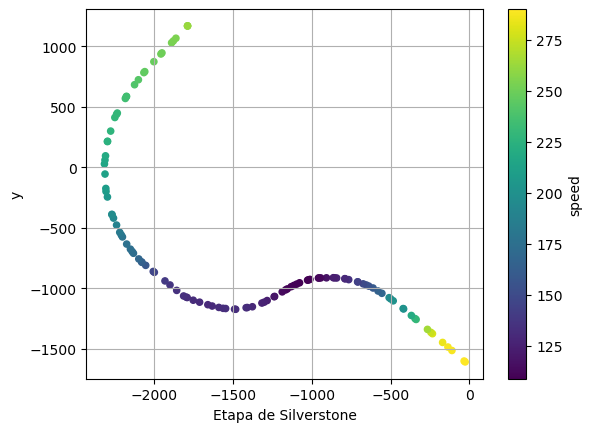

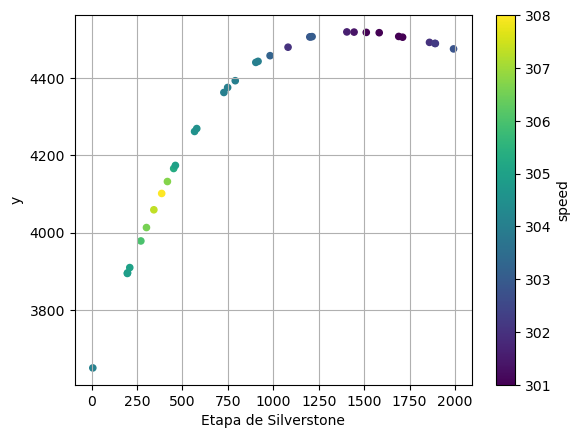

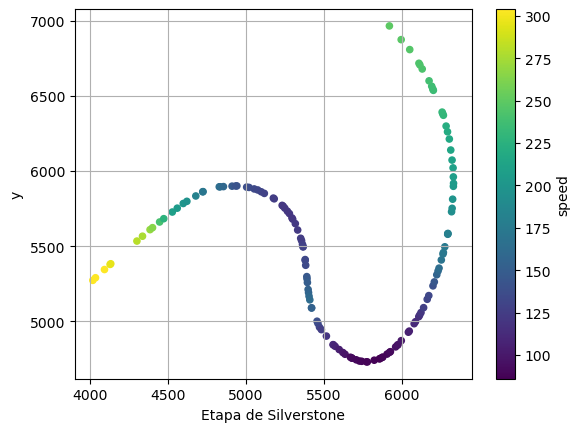

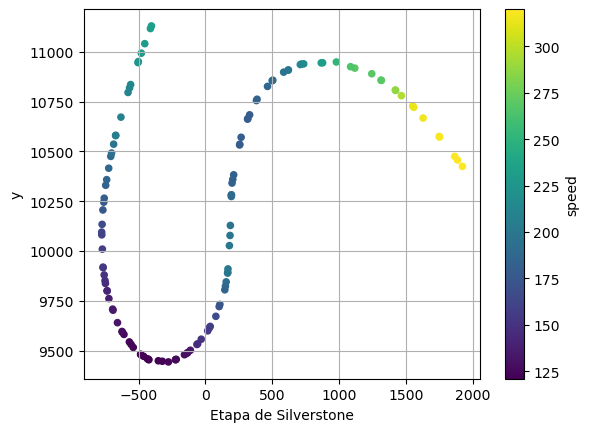

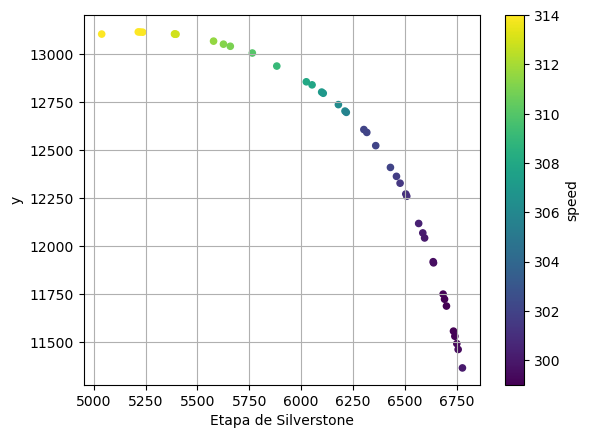

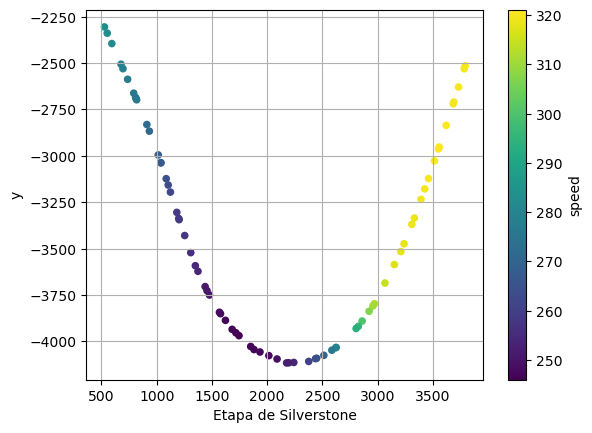

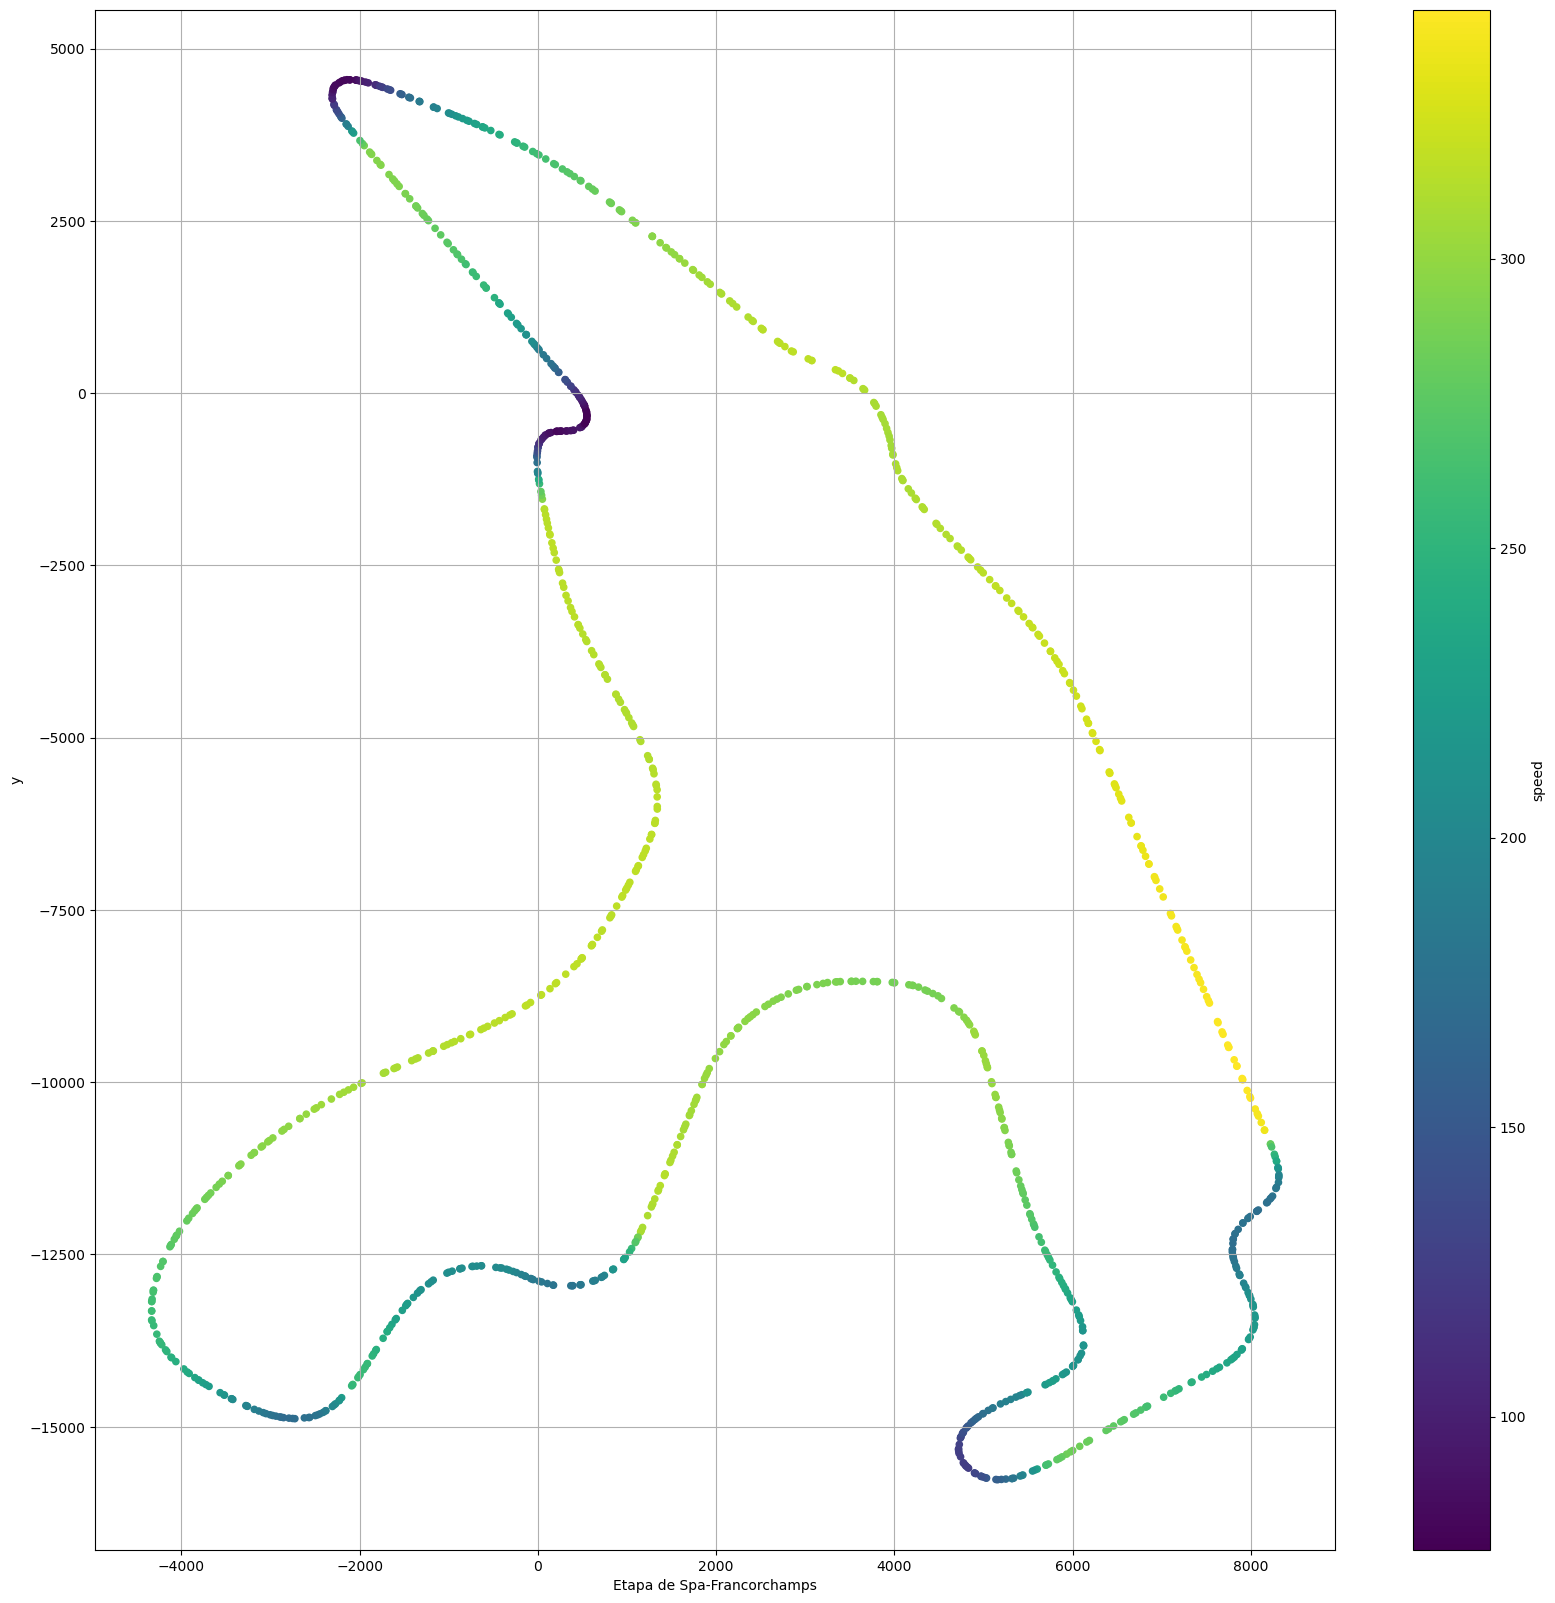

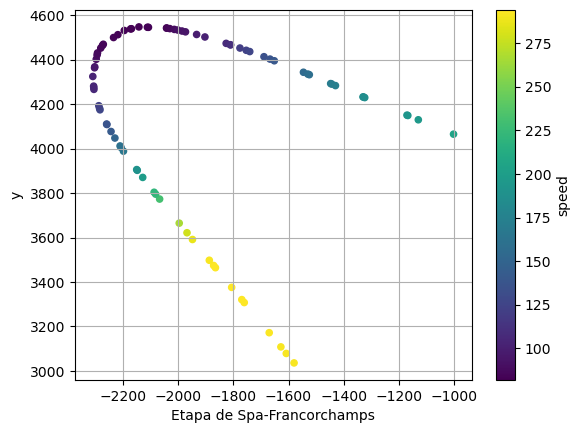

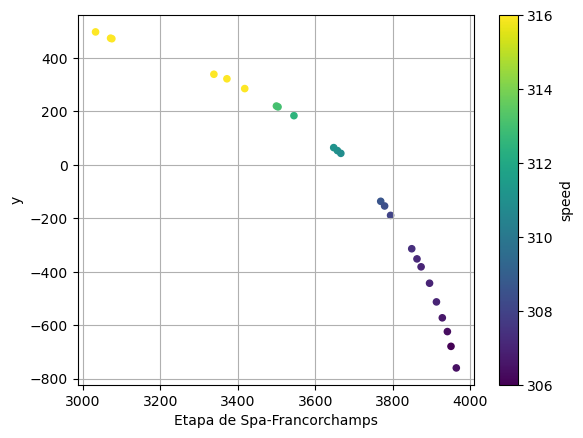

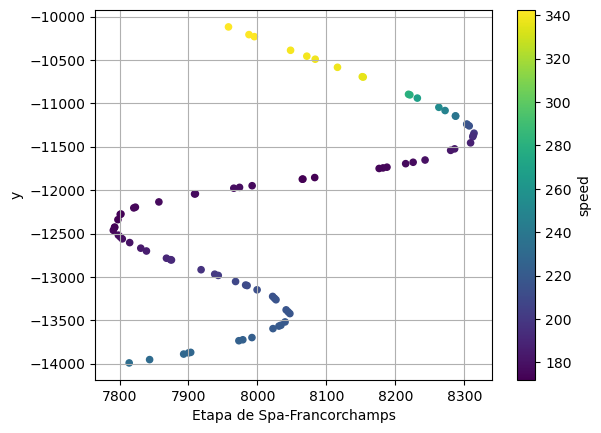

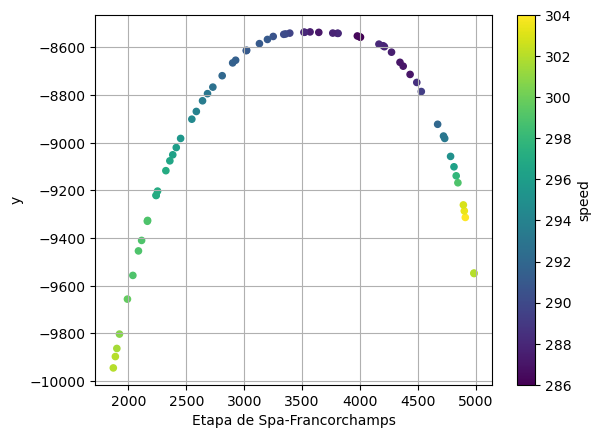

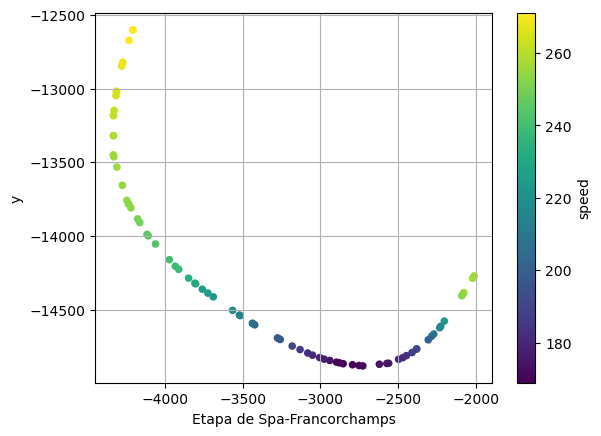

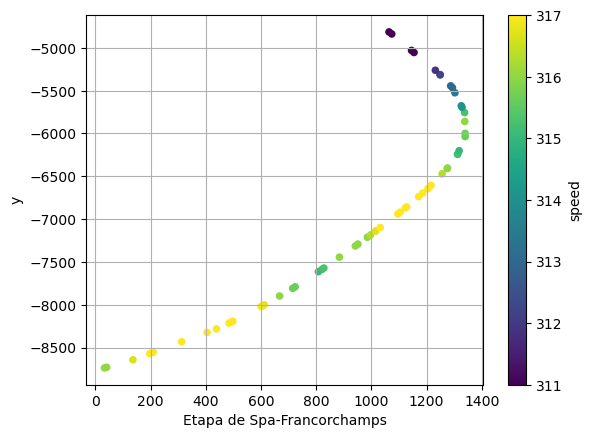

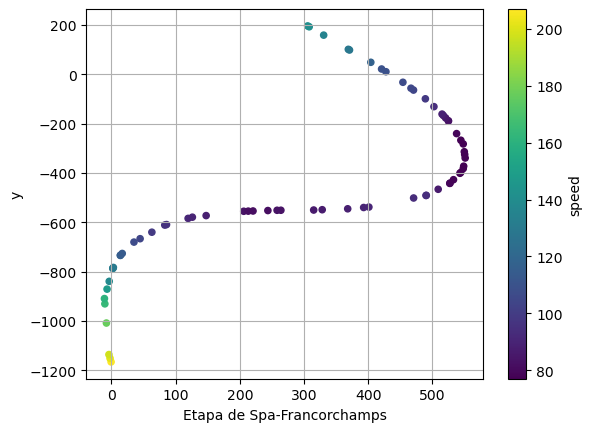

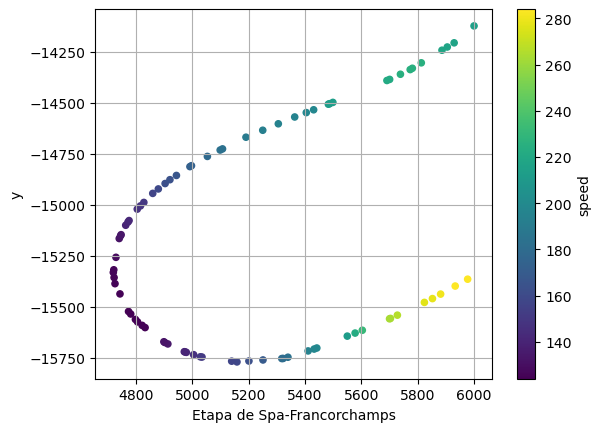

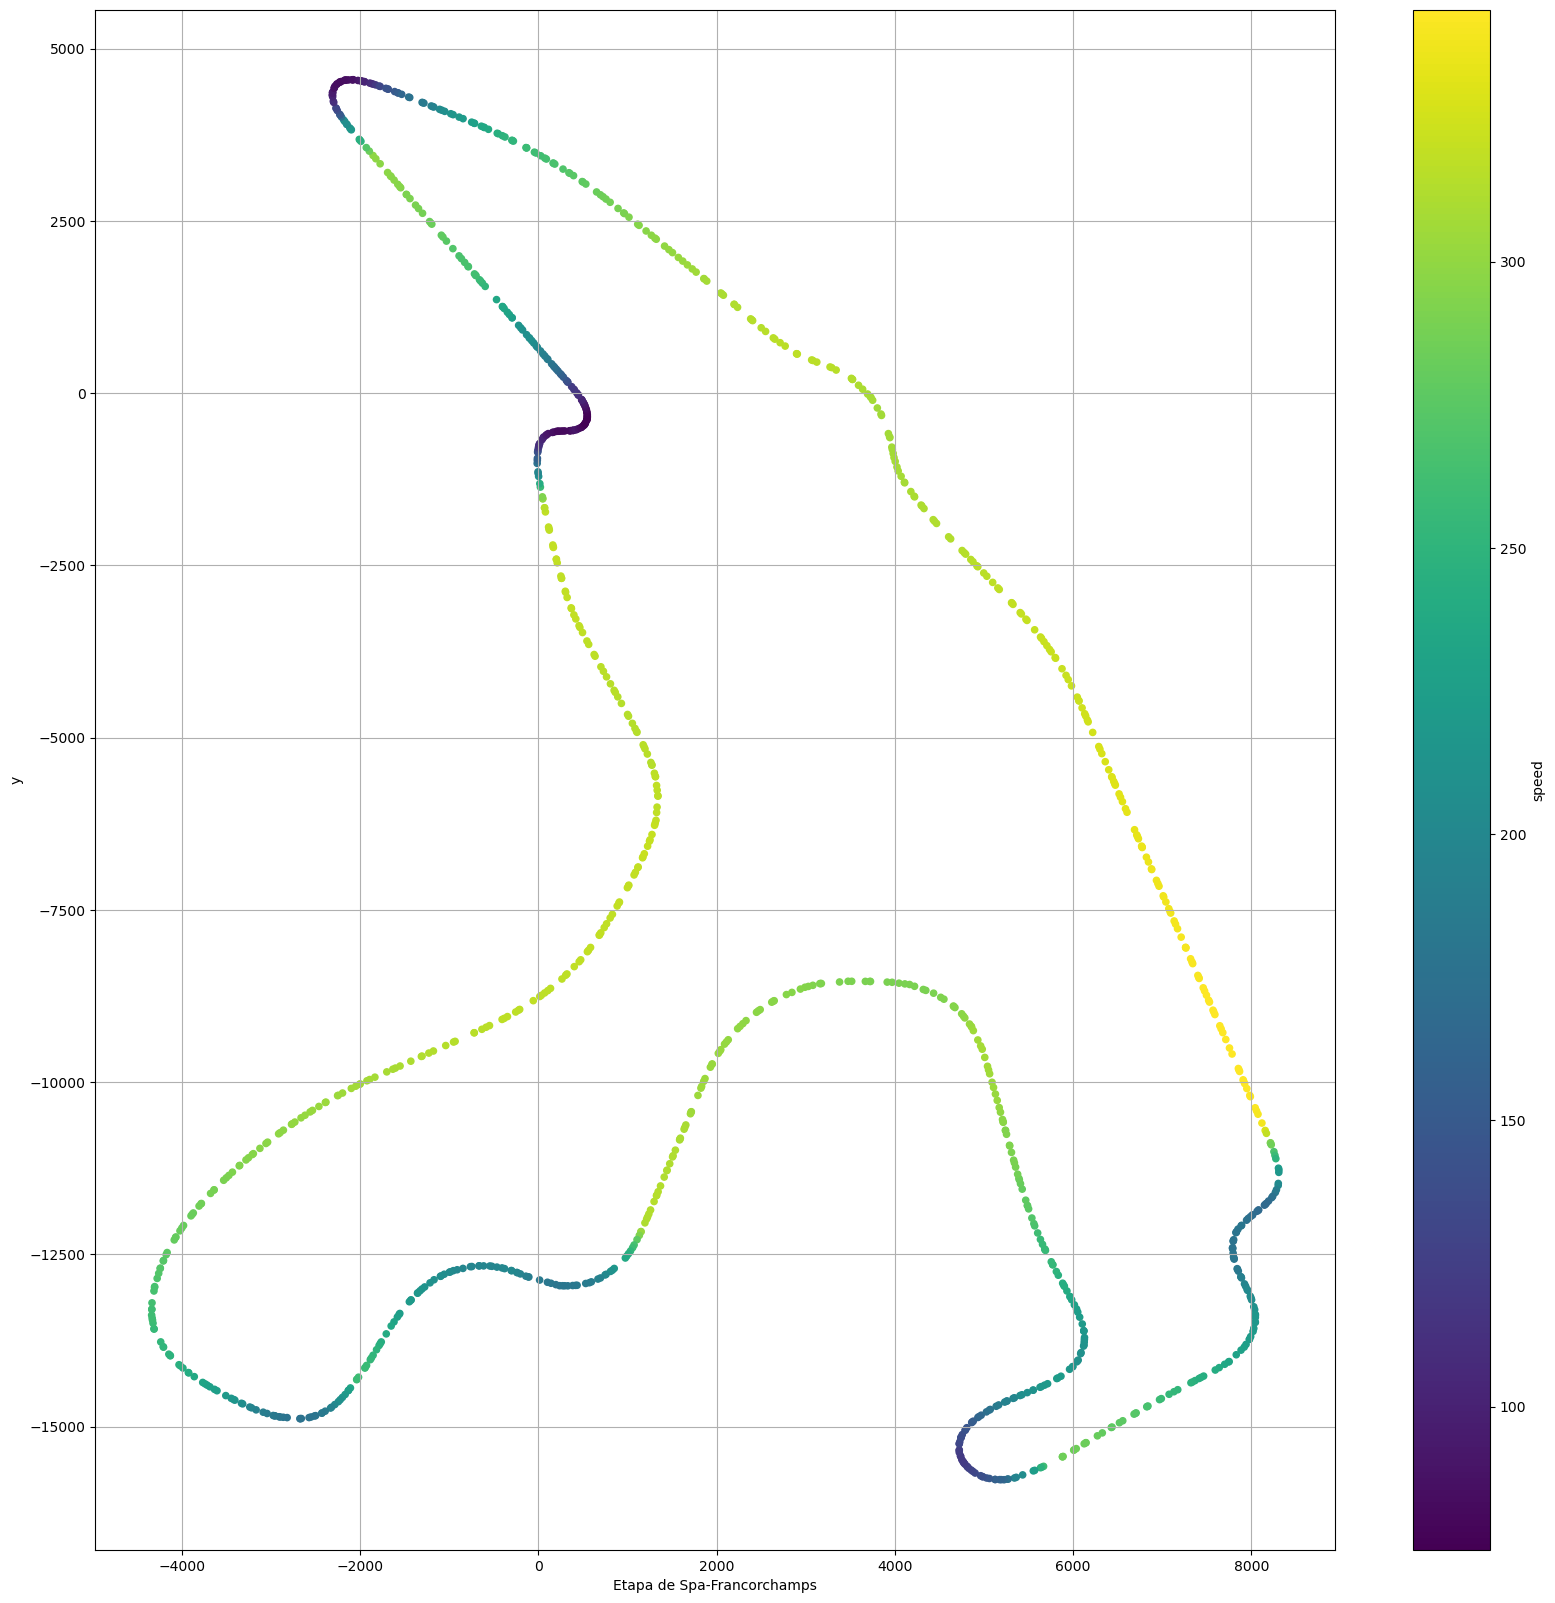

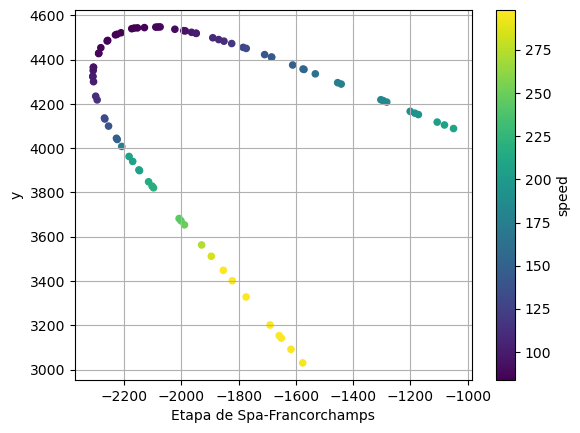

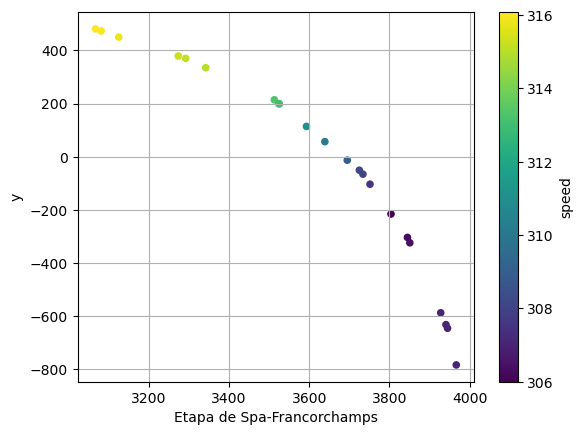

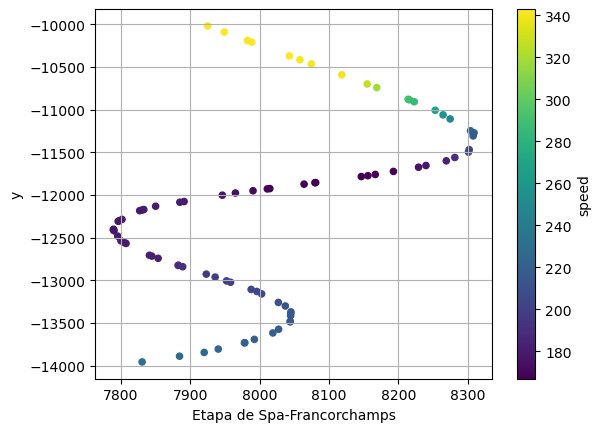

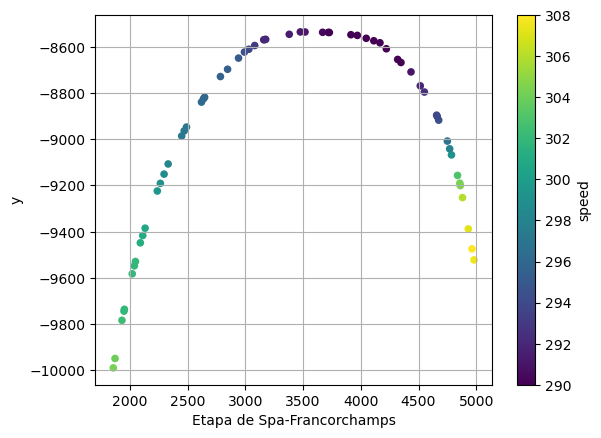

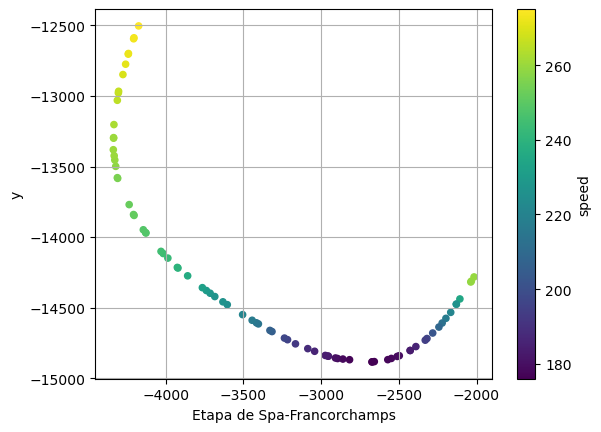

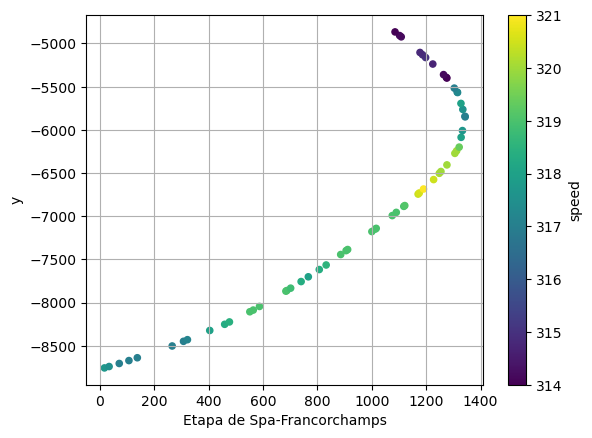

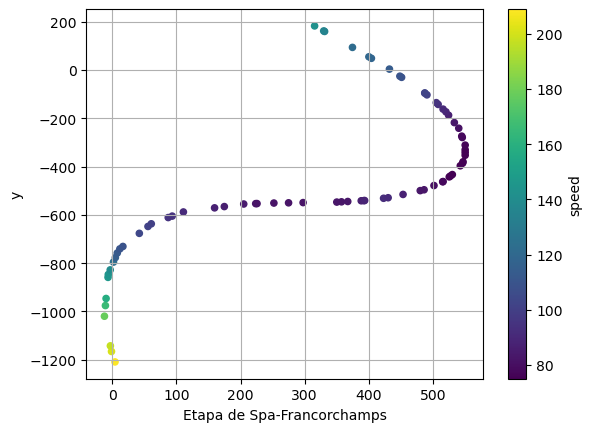

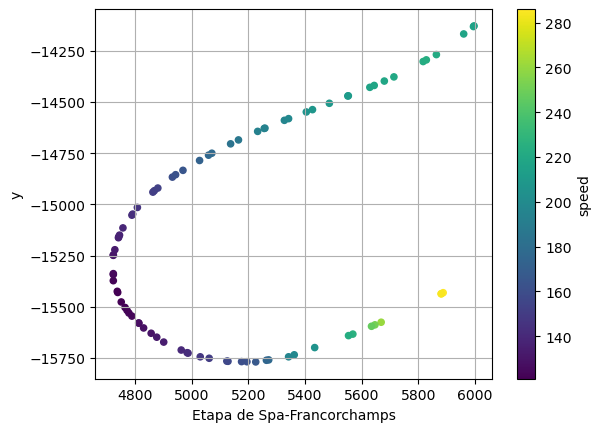

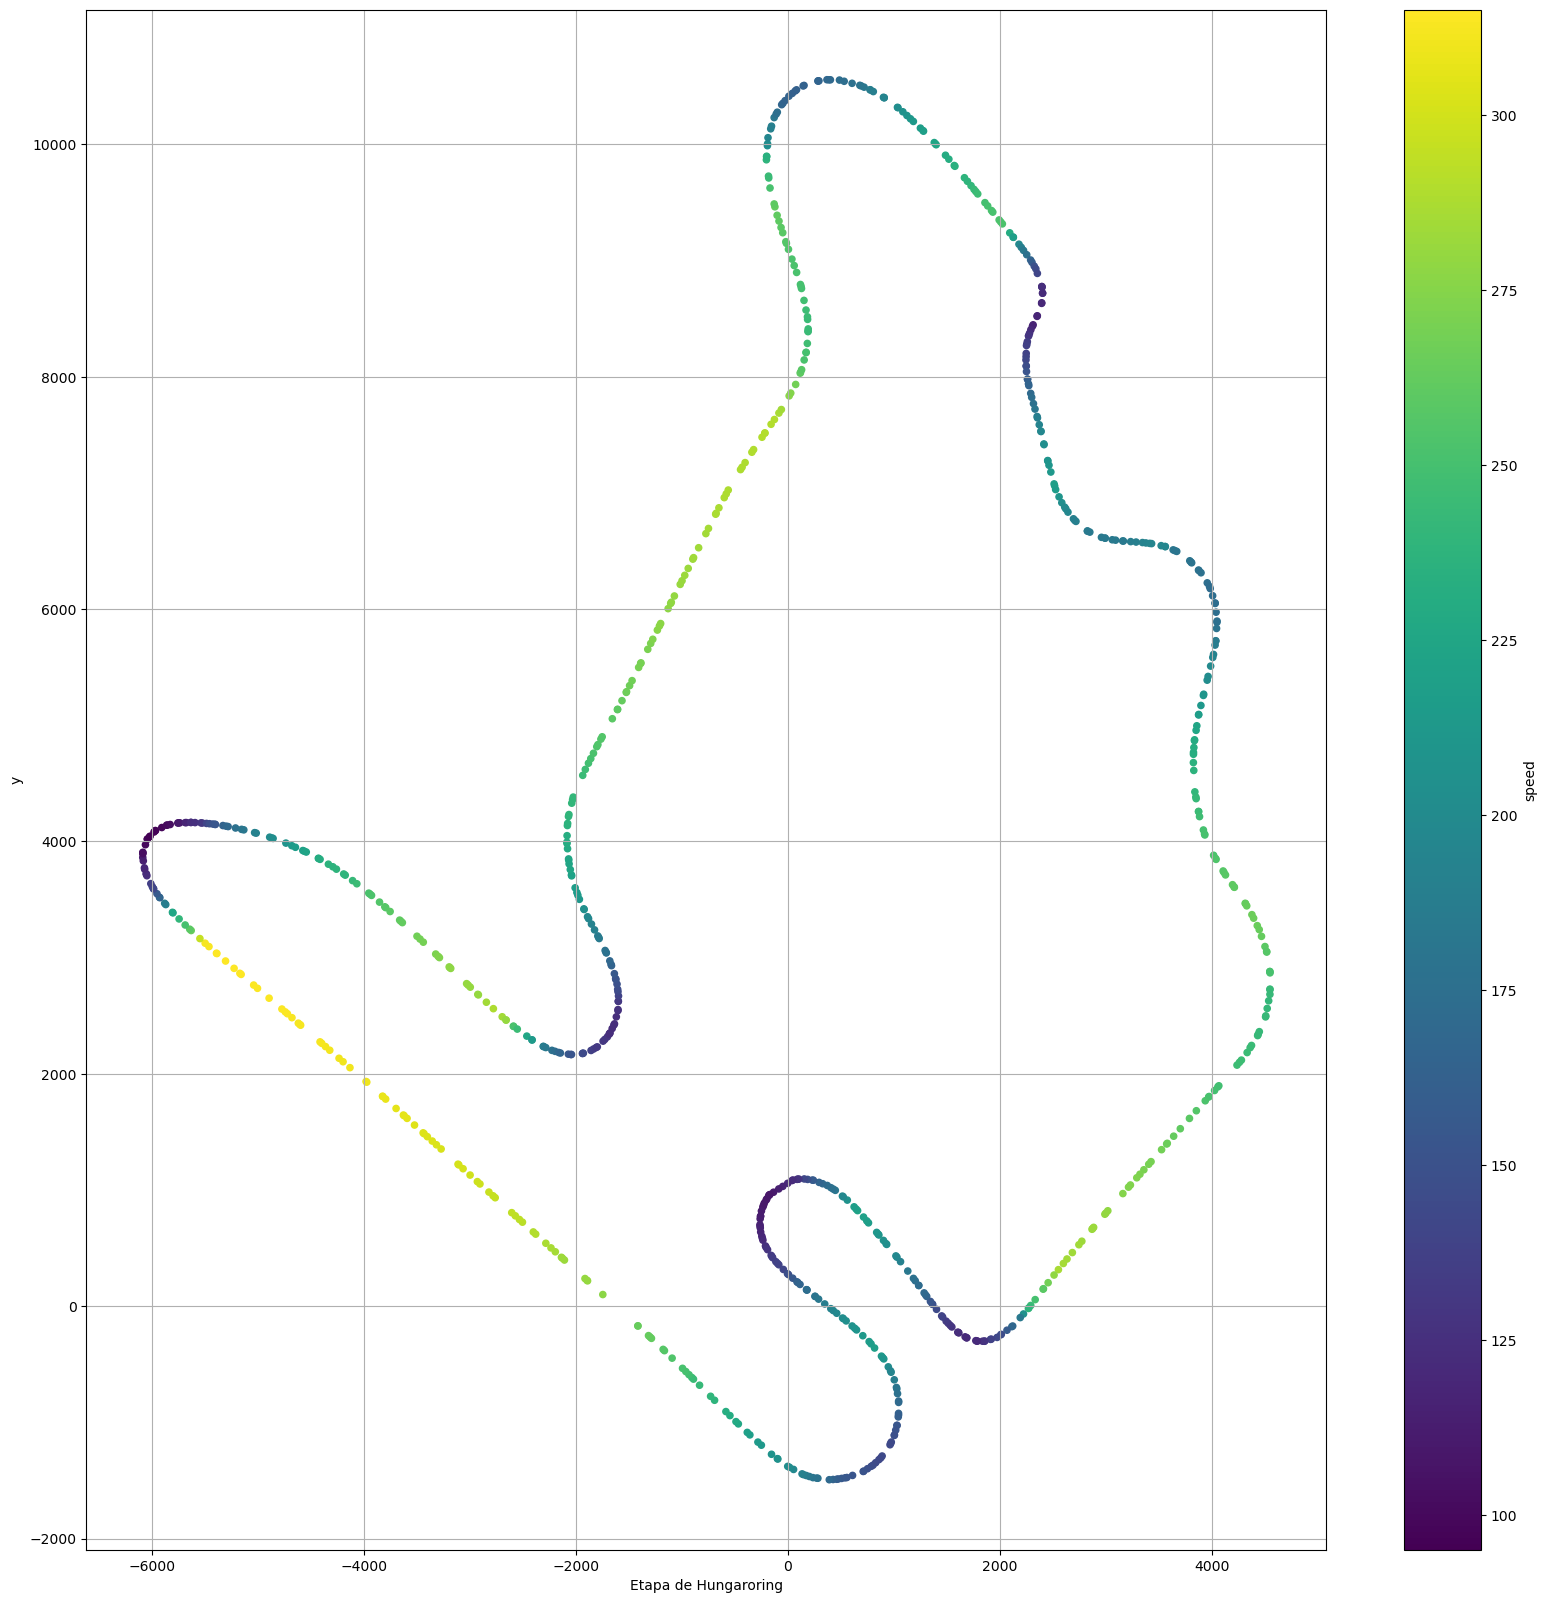

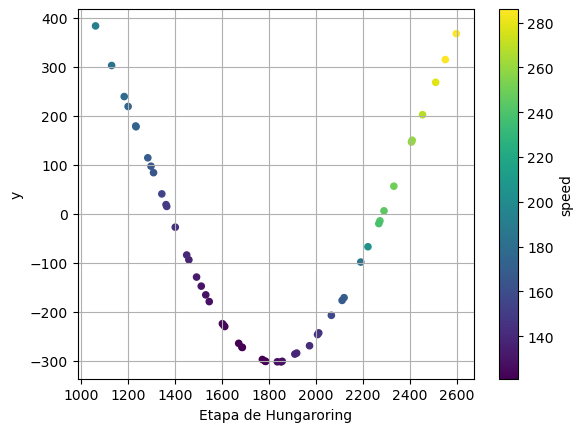

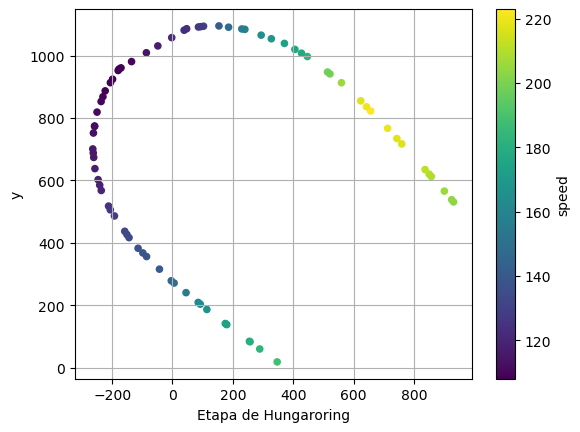

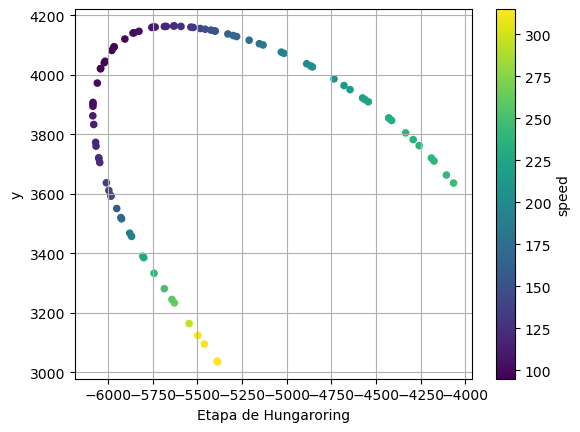

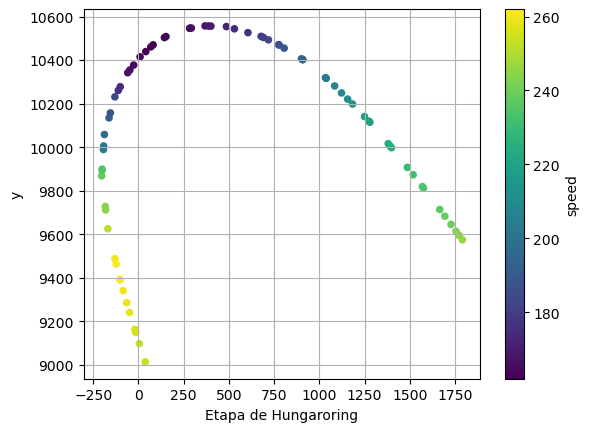

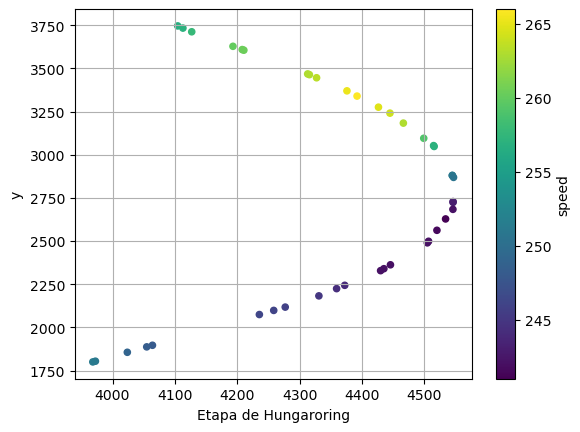

In [ ]:
j = 0
for sessao in sessoes['session_key']:
    final = exemplo(sessao)
    setores = curvas_piloto(final,todas_curvas[j])
    for curva in setores:
        curva.plot.scatter(x='x',y='y',c='speed',xlabel = f'Etapa de {sessoes.loc[sessoes[sessoes['session_key']== sessao].index[0], 'circuit_short_name']}', grid = True, )
    j+=1


#### A coleta geral:

Faz o processo de coleta para todas as etapas, pilotos e curvas, criando os arquivos .csv.
Threads são utilizados para agilizar a coleta.

In [ ]:
i=0
for sessao in sessoes['session_key']:
    thread = threading.Thread(target = coletar_salvar, args=(sessao,distancias,todas_curvas,i))
    thread.start()
    i+=1


Piloto 1,Etapa de Sakhir OK!
Piloto 1,Etapa de Imola OK!
Piloto 1,Etapa de Shanghai OK!
Piloto 1,Etapa de Miami OK!
Piloto 1,Etapa de Melbourne OK!
Piloto 1,Etapa de Silverstone OK!
Piloto 4,Etapa de Sakhir OK!
Piloto 1,Etapa de Suzuka OK!
Piloto 4,Etapa de Imola OK!
Piloto 1,Etapa de Hungaroring OK!
Piloto 4,Etapa de Miami OK!
Piloto 4,Etapa de Shanghai OK!
Piloto 4,Etapa de Silverstone OK!
Piloto 4,Etapa de Suzuka OK!
Piloto 1,Etapa de Montreal OK!
Piloto 1,Etapa de Miami OK!
Piloto 1,Etapa de Shanghai OK!
Piloto 4,Etapa de Melbourne OK!
Piloto 1,Etapa de Spa-Francorchamps OK!
Piloto 5,Etapa de Shanghai OK!
Piloto 5,Etapa de Sakhir OK!
Piloto 4,Etapa de Montreal OK!
Piloto 1,Etapa de Catalunya OK!
Piloto 4,Etapa de Miami OK!
Piloto 5,Etapa de Miami OK!
Piloto 1,Etapa de Spa-Francorchamps OK!
Piloto 5,Etapa de Suzuka OK!
Piloto 4,Etapa de Spa-Francorchamps OK!
Piloto 6,Etapa de Sakhir OK!
Piloto 5,Etapa de Silverstone OK!
Piloto 4,Etapa de Catalunya OK!
Piloto 1,Etapa de Spielberg OK!

Exception in thread Thread-39 (coletar_salvar):
Traceback (most recent call last):
  File "/usr/lib/python3.13/threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/usr/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/usr/lib/python3.13/threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8351/3897095748.py", line 2, in coletar_salvar
    pilotos = coleta(sessao,distancias[i],todas_curvas[i])
  File "/tmp/ipykernel_8351/3206029179.py", line 23, in coleta
    pilotos.at[indice, f'curva {i+1}']= velocidade_curva(setores[i],escala)
                                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8351/1402717843.py", line 2, in velocidade_curva
    distancia(curva)
    ~~~~~~~~~^^^^^^^
  File "/tmp/ipykernel_8351/2194786789.py", line

Piloto 55,Etapa de Melbourne OK!
Piloto 44,Etapa de Shanghai OK!
Piloto 55,Etapa de Imola OK!
Piloto 31,Etapa de Spa-Francorchamps OK!
Piloto 55,Etapa de Shanghai OK!
Piloto 43,Etapa de Spielberg OK!
Piloto 44,Etapa de Hungaroring OK!
Piloto 63,Etapa de Melbourne OK!
Piloto 31,Etapa de Spa-Francorchamps OK!
Piloto 30,Etapa de Montreal OK!
Piloto 55,Etapa de Shanghai OK!
Piloto 55,Etapa de Miami OK!
Piloto 63,Etapa de Shanghai OK!
Piloto 30,Etapa de Monte Carlo OK!
Piloto 63,Etapa de Imola OK!
Piloto 31,Etapa de Montreal OK!
Piloto 44,Etapa de Spielberg OK!
Piloto 27,Etapa de Jeddah OK!
Piloto 55,Etapa de Sakhir OK!
Piloto 63,Etapa de Miami OK!
Piloto 81,Etapa de Shanghai OK!
Piloto 81,Etapa de Imola OK!
Piloto 43,Etapa de Montreal OK!
Piloto 43,Etapa de Spa-Francorchamps OK!
Piloto 87,Etapa de Shanghai OK!
Piloto 55,Etapa de Silverstone OK!
Piloto 81,Etapa de Suzuka OK!
Piloto 31,Etapa de Monte Carlo OK!
Piloto 43,Etapa de Catalunya OK!
Piloto 55,Etapa de Hungaroring OK!
Piloto 43,Etap